# Introduction

- This is the jupyter notebook that contain the most part of the *Python* code that has been developed for the bachelor final project of *Fabio Scielzo Ortiz* (LINK DE LINKEDIN). 
 
    - You can find the document of that project here (INSERT LINK).



- If you use any of this content, please, reference it appropriately.

## Index

- Requirements
- Classic distances
- Mahalanobis robust distance
- Generalized Gower and RelMS distances
- Distance hyperparameter tunning in $k$-medoids
- Empirical test
   - Tables with TAC and ARI
   - Analysing the influence of $\alpha$ in Mahalanobis robust distance
   - Descriptive summary of each data-set

# Requirements

In [1]:
# Manejo de data-frames y arrays
import pandas as pd
import numpy as np

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Para poder usar random search con la función
from sklearn.utils import resample

# Para implementar k-medoids (versión de Park y Jun (2009))
import sklearn_extra
from sklearn_extra.cluster import KMedoids

# Para tareas con bucles
import itertools

# Para implementar MDS
from sklearn.manifold import MDS

# Para generar los data-set sintéticos
from sklearn.datasets import make_classification, make_blobs

# Para calcular el Rand index ajustado
from sklearn import metrics

# Para realizar tareas de preprocesado en algunos conjuntos de datos
from sklearn.preprocessing import OrdinalEncoder

# Para llevar a cabo algunas operaciones matematicas
import math as math

# Para guardar diccionarios en formato pickle
import pickle


# Classic Distances

In [6]:
def Dist_Euclidea(x_i, x_r): 
    """
    Calcula la distancia Euclidea entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    x_i , x_r: vectores de observaciones. Arrays de una dimension.       

    Devuelve (outputs)
    -------
    d: la distancia Euclidea entre x_i y x_r.
    """
    Dist_Euclidea = ( ( x_i - x_r )**2 ).sum()
    Dist_Euclidea = np.sqrt(Dist_Euclidea)
    return Dist_Euclidea

def Matrix_Dist_Euclidea(Data):
    """
    Calcula la matriz de distancias Euclideas para un conjunto de datos.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.       

    Devuelve (outputs)
    -------
    M: la matriz de distancias Euclideas entrelas observaciones (filas) del data-frame Data.
    """
    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    else:
        pass
    n = len(Data)
    M =  np.zeros((n , n))   
    for i in range(0, n):
        for r in range(i+1, n):        
                M[i,r] = Dist_Euclidea(Data[i,:], Data[r,:])
    M = M + M.T
    return M 

def Dist_Minkowski(x_i, x_r, q):
    """
    Calcula la distancia de Minkowski entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    x_i , x_r: vectores de observaciones. Arrays de una dimension.   
    q : debe ser un numero entero positivo.    

    Devuelve (outputs)
    -------
    d: la distancia de Minkowski entre x_i y x_r.
    """
    Dist_Minkowski = ( ( ( abs( x_i - x_r) )**q ).sum() )**(1/q)
    return Dist_Minkowski

def Matrix_Dist_Minkowski(Data, q):
    """
    Calcula la matriz de distancias de Minkowski para un conjunto de datos.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.       

    Devuelve (outputs)
    -------
    M: la matriz de distancias de Minkowski entrelas observaciones (filas) del data-frame Data.
    """
    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    else:  
        pass
    n = len(Data)
    M =  np.zeros((n , n))   
    for i in range(0, n):
        for r in range(i+1, n):        
                M[i,r] = Dist_Minkowski(Data[i,:] , Data[r,:], q)   
    M = M + M.T          
    return M 

def Dist_Canberra(x_i, x_r):
    """
    Calcula la distancia de Canberra entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    x_i , x_r: vectores de observaciones. Arrays de una dimension.       

    Devuelve (outputs)
    -------
    d: la distancia de Canberra entre x_i y x_r.
    """
    numerator =  abs( x_i - x_r )
    denominator =  ( abs(x_i) + abs(x_r) )
    numerator=np.array([numerator], dtype=float)
    denominator=np.array([denominator], dtype=float)
    # Se usa np.divide para evitar problemas con la division. En el caso de denominator=0, devuelve numerator. En otro caso, efectua la division.
    Dist_Canberra = ( np.divide( numerator , denominator , out=np.zeros_like(numerator), where=denominator!=0) ).sum() 
    return Dist_Canberra

def Matrix_Dist_Canberra(Data):
    """
    Calcula la matriz de distancias de Canberra para un conjunto de datos.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.       

    Devuelve (outputs)
    -------
    M: la matriz de distancias de Canberra entrelas observaciones (filas) del data-frame Data.
    """
    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    else:
        pass
    n = len(Data)
    M =  np.zeros((n , n))
    for i in range(0, n):
         for r in range(i+1, n):
            M[i,r] = Dist_Canberra(Data[i,:] , Data[r,:])  
    M = M + M.T              
    return M 

def Dist_Pearson(x_i, x_r, variance) :
    """
    Calcula la distancia de Pearson entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    x_i , x_r: vectores de observaciones. Arrays de una dimension.    
    variance : vector de varianzas de las variables (columnas) de un data-frame o array.   

    Devuelve (outputs)
    -------
    d: la distancia de Pearson entre x_i y x_r.
    """
    Dist_Pearson = ( ( x_i - x_r )**2 / variance ).sum()
    Dist_Pearson = np.sqrt(Dist_Pearson)
    return Dist_Pearson

def Matrix_Dist_Pearson(Data):
    """
    Calcula la matriz de distancias de Pearson para un conjunto de datos.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.       

    Devuelve (outputs)
    -------
    M: la matriz de distancias de Pearson entre las observaciones (filas) del data-frame Data.
    """
    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    else:
        pass
    n = len(Data)
    M =  np.zeros((n , n))
    var = np.var(Data, axis=0, ddof=1)
    for i in range(0, n): 
         for r in range(i+1, n):
            M[i,r] = Dist_Pearson(Data[i,:] , Data[r,:], var)   
    M = M + M.T                 
    return M 

def Dist_Mahalanobis(x, S_inv):  
    """
    Calcula la distancia de Mahalanobis entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    x : se debe definir como x = np.array([x_i - x_r]), siendo x_i y x_r arrays de una dimension.
    S_inv : inversa de la matriz de covarianzas de un data-frame o array.
          
    Devuelve (outputs)
    ----------
    d: la distancia de Mahalanobis entre x_i y x_r.

    Comentarios
    ----------
    Todas las columnas del data-frame o array deben ser type = 'float' or 'int' (especialemtne no 'object'), en otro caso habra problema de dimensionalidad al calcular x @ S_inv @ x.T
    """
    Dist_Maha = np.sqrt( x @ S_inv @ x.T )
    Dist_Maha = float(Dist_Maha)
    return Dist_Maha

def Matrix_Dist_Mahalanobis(Data):
    """
    Calcula la matriz de distancias de Mahalanobis para un conjunto de datos.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.       

    Devuelve (outputs)
    -------
    M: la matriz de distancias de Mahalanobis entre las observaciones (filas) del data-frame Data.
    """
    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    else:
        pass
    n = len(Data)
    M =  np.zeros((n , n))
    S_inv=np.linalg.inv( np.cov(Data , rowvar=False) )
    for i in range(0, n):
         for r in range(i+1, n):
            M[i,r] = Dist_Mahalanobis(x = np.array([Data[i,:] - Data[r,:]]) , S_inv=S_inv ) 
    M = M + M.T
    return M 

def a_b_c_d_Matrix(Data):
    """
    Calcula las matrices con los parametros a,b,c y d usados en las distancias de Jaccard, Sokal y Gower.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.       

    Devuelve (outputs)
    -------
    a,b,c,d : matrices con los parametros a,b,c y d calculados para Data.
    p : numero de columnas de Data.
    """
    if isinstance(Data, pd.DataFrame):
        X = Data.to_numpy()
    else:
        X = Data
    a = X @ X.T
    n = X.shape[0]
    p = X.shape[1]
    ones_matrix = np.ones((n, p)) 
    b = (ones_matrix - X) @ X.T
    c = b.T
    d = (ones_matrix - X) @ (ones_matrix - X).T
    return a , b , c , d , p

def Sokal_Similarity(i , r, a , d, p):
    """
    Calcula la similaridad de Sokal entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    i , r: numeros enteros no negativos. Son los indices de las observaciones entre las que se quiere calcular la similaridad.
    a, d: matrices con los parametros a y d usados en la similaridad de Sokal.
    p : numero de columnas del conjunto de datos.       

    Devuelve (outputs)
    -------
    d: la similaridad de Sokal entre las observaciones con indice i y r.
    """
    if a[i,r] + d[i,r] == 0 :
        Sokal_Similarity = 0
    else :
        Sokal_Similarity = (a[i,r] + d[i,r]) / p
    return Sokal_Similarity

def Dist_Sokal(i, r, a, d, p):
    """
    Calcula la distancia de Sokal entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    i , r: numeros enteros no negativos. Son los indices de las observaciones entre las que se quiere calcular la similaridad.
    a, d: matrices con los parametros a y d usados en la similaridad de Sokal.
    p : numero de columnas del conjunto de datos.       

    Devuelve (outputs)
    -------
    d: la distancia de Sokal entre las observaciones con indice i y r.
    """
    dist_Sokal = np.sqrt( Sokal_Similarity(i , i, a , d, p) + Sokal_Similarity(r , r, a , d, p) - 2*Sokal_Similarity(i , r, a , d, p) )
    return dist_Sokal  

def Matrix_Dist_Sokal(Data):
    """
    Calcula la matriz de distancias de Sokal para un conjunto de datos.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.       

    Devuelve (outputs)
    -------
    M: la matriz de distancias de Sokal entre las observaciones (filas) del data-frame Data.
    """
    n = len(Data)
    M =  np.zeros((n , n))
    a, b, c, d, p = a_b_c_d_Matrix(Data)
    for i in range(0, n):
         for r in range(i+1, n):
            M[i,r] = Dist_Sokal(i=i, r=r, a=a, d=d, p=p)  
    M = M + M.T                    
    return M 

def Jaccard_Similarity(i , r, a, d, p):
    """
    Calcula la similaridad de Jaccard entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    i , r: numeros enteros no negativos. Son los indices de las observaciones entre las que se quiere calcular la similaridad.
    a, d: matrices con los parametros a y d usados en la similaridad de Sokal.
    p : numero de columnas del conjunto de datos.       

    Devuelve (outputs)
    -------
    d: la similaridad de Jaccard entre las observaciones con indice i y r.
    """
    if a[i,r] == 0 and  (p-d[i,r]) == 0 :
        Jaccard_Similarity = 1
    else :
        Jaccard_Similarity = a[i,r] / (p-d[i,r])
    return Jaccard_Similarity

def Dist_Jaccard(i , r, a, d, p):
    """
    Calcula la distancia de Jaccard entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    i , r: numeros enteros no negativos. Son los indices de las observaciones entre las que se quiere calcular la similaridad.
    a, d: matrices con los parametros a y d usados en la similaridad de Sokal.
    p : numero de columnas del conjunto de datos.       

    Devuelve (outputs)
    -------
    d: la distancia de Jaccard entre las observaciones con indice i y r.
    """
    Dist_Jaccard = np.sqrt( Jaccard_Similarity(i , i, a, d, p) + Jaccard_Similarity(r , r, a, d, p) - 2*Jaccard_Similarity(i , r, a, d, p) )
    return Dist_Jaccard 
 
def Matrix_Dist_Jaccard(Data):
    """
    Calcula la matriz de distancias de Jaccard para un conjunto de datos.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.       

    Devuelve (outputs)
    -------
    M: la matriz de distancias de Jaccard entrelas observaciones (filas) del data-frame Data.
    """
    n = len(Data)
    M =  np.zeros((n , n))
    a, b, c, d, p = a_b_c_d_Matrix(Data)
    for i in range(0, n):
        for r in range(i+1, n):
            M[i,r] = Dist_Jaccard(i=i, r=r, a=a, p=p, d=d)
    M = M + M.T                  
    return M 

def alpha(x_i, x_r):
    """
    Calcula el parametro alpha usado en la similaridad Matching.

    Parametros (inputs)
    ----------
    x_i , x_r: vectores de observaciones. Arrays de una dimension.   
    Data: un data-frame Pandas o un array Numpy.       

    Devuelve (outputs)
    -------
    alpha : valor del parametro alpha para las observaciones x_i y x_r.
    """
    alpha = sum(x_i == x_r)
    return(alpha) 
  
def matching_similarity(x_i, x_r, Data):
    """
    Calcula la similaridad Matching entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    x_i , x_r: vectores de observaciones. Arrays de una dimension.     
     

    Devuelve (outputs)
    -------
    d: la distancia de Matching entre x_i y x_r.
    """
    p = Data.shape[1]
    matching_similarity = alpha(x_i, x_r) / p
    return(matching_similarity)

def Dist_Matching(x_i, x_r, Data):
    """
    Calcula la distancia de Matching entre dos vectores de observaciones.

    Parametros (inputs)
    ----------
    x_i , x_r: vectores de observaciones. Arrays de una dimension.       

    Devuelve (outputs)
    -------
    d: la distancia de Matching entre x_i y x_r.
    """
    Dist_Matching = np.sqrt(matching_similarity(x_i, x_i, Data) +  matching_similarity(x_r, x_r, Data) - 2*matching_similarity(x_i, x_r, Data) )
    return( Dist_Matching )

def Matrix_Dist_Matching(Data):
    """
    Calcula la matriz de similaridades Matching para un conjunto de datos.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.       

    Devuelve (outputs)
    -------
    M: la matriz de similaridades Matching entre las observaciones (filas) del data-frame Data.
    """
    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    else:
        pass
    n = len(Data)
    M =  np.zeros((n , n))
    for i in range(0, n):
      for r in range(i+1, n):
         M[i,r] = Dist_Matching(x_i=Data[i,:], x_r=Data[r,:], Data=Data)
    M = M + M.T                  
    return M 

def Matrix_Gower_Similarity(Data, p1, p2, p3):
    """
    Calcula la matriz de similaridades de Gower  para un conjunto de datos.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.  Data debe tener las primeras p1 t variables (columnas) cuantitativas, las siguientes p2 binarias y las restantes p3 multiclase.     
    p1, p2, p3 : numeros enteros no negativos.

    Devuelve (outputs)
    -------
    M: la matriz de similaridades de Gower entre las observaciones (filas) del data-frame Data.

    Comentarios 
    -------
    Si Data no contiene variables cuantitativas: p1=0.
    Si Data no contiene variables binarias: p2=0.
    Si Data no contiene variables multiclase: p3=0.
    """
    if isinstance(Data, pd.DataFrame):
        Data = Data.to_numpy()
    else:
        pass
    n = len(Data)
    M =  np.zeros((n , n))

    G_vector = np.repeat(0.5, p1)
    for k in range(0, p1):
        G_vector[k] = Data[:,k].max() - Data[:,k].min()

    ones = np.repeat(1, p1)
    Quant_Data = Data[: , 0:p1]
    Binary_Data = Data[: , (p1):(p1+p2)]
    Multiple_Data = Data[: , (p1+p2):(p1+p2+p3) ]

    a, b, c, d, p = a_b_c_d_Matrix(Binary_Data)

    for i in range(0, n):
         for r in range(i+1, n):
                numerator_part_1 = ( ones - ( abs(Quant_Data[i,:] - Quant_Data[r,:]) / G_vector ) ).sum() 
                numerator_part_2 = a[i,r]               
                numerator_part_3 = alpha(Multiple_Data[i,:], Multiple_Data[r,:])
                numerator = numerator_part_1 + numerator_part_2 + numerator_part_3
                denominator = p1 + (p2 - d[i,r]) + p3
                if denominator == 0:
                    M[i,r] = 0
                else:    
                    M[i,r] = numerator / denominator
    M = M + M.T
    M = M + np.identity(n)
    return M  

def Matrix_Dist_Gower(Data, p1, p2, p3 ):
    """
    Calcula la matriz de distancias de Gower para un conjunto de datos.

    Parametros (inputs)
    ----------
    Data: un data-frame Pandas o un array Numpy.  Data debe tener las primeras p1 t variables (columnas) cuantitativas, las siguientes p2 binarias y las restantes p3 multiclase.     
    p1, p2, p3 : enteros no negativos.    
    
    Devuelve (outputs)
    -------
    M: la matriz de distancias de Gower entre las observaciones (filas) del data-frame Data.

    Comentarios 
    -------
    Si Data no contiene variables cuantitativas: p1=0.
    Si Data no contiene variables binarias: p2=0.
    Si Data no contiene variables multiclase: p3=0.
    """
    M = Matrix_Gower_Similarity(Data, p1, p2, p3)
    M = np.sqrt( 1 - M )
    return M

# Mahalanobis Robust Distance

In [7]:
def MAD(X_j) :
    """
    Calcula la desviacion absoluta mediana de una variable.

    Parametros (inputs)
    ----------
    X_j: un vector de observaciones de una variable. Debe ser un numpy array de una dimension o una pandas series.  

    Devuelve (outputs)
    -------
    MAD: la desviacion absoluta median de X_j.
    """
    MAD = np.median( np.abs( X_j - np.median(X_j) ) )
    return MAD

def Variable_alpha_trimmed(X_j, alpha) : 
    """
    Genera la variable alpha-recortada (trimmed) de una variable pasada como argumento.

    Parametros (inputs)
    ----------
    X_j : un vector de observaciones de una variable. Debe ser un numpy array de una dimension o una pandas series.  
    alpha : debe ser un numero en el intervalo cerrado [0,1]. 

    Devuelve (outputs)
    -------
    result: la variable alpha-trimmed obtenida a partir de X_j.
    """
    # Se calcula la cota inferior
    lower_bound = np.quantile(X_j, q=alpha/2)  
    # Se calcula la cota superior
    upper_bound = np.quantile(X_j, q=1-alpha/2) 
    # Se usa np.logical_and para generar un vector booleano, cuyo valor i-esimo es True  si la observacion i de X_j esta entre la cota inferior y la superior, y False en otro caso.
    mask = np.logical_and(X_j >= lower_bound, X_j <= upper_bound)
    # Seleccionamos las observaciones de X_j que cumplen la condicion pasada como argumento a np.logical_and. 
    result = X_j[mask]
    return result

def Variable_alpha_winsorized(X_j, alpha) :
    """
    Genera la variable alpha-winsorized de una variable pasada como argumento.

    Parametros (inputs)
    ----------
    X_j : un vector de observaciones de una variable. Debe ser un numpy array de una dimension o una pandas series.  
    alpha : debe ser un numero en el intervalo cerrado [0,1]. 

    Devuelve (outputs)
    -------
    result: la variable alpha-winsorized obtenida a partir de X_j.
    """
    # Si X_j es un vector de ceros, la version winsorized de X_j es la propia X_j.
    if np.all(X_j == 0) :  
        variable_alpha_winsorized = X_j
        variable_alpha_winsorized = pd.Series(variable_alpha_winsorized)
    # Si X_j no es un vector de ceros.
    else :
        # Calculamos las cotas inferiores y superiores.
        lower_bound = np.quantile(X_j, q=alpha/2)
        upper_bound = np.quantile(X_j, q=1-alpha/2)
        # Definimos los vectores A y B, y los valores a  y b. Para mas detalles ver la seccion 7.2.1.
        A = X_j[X_j <= lower_bound]  
        B = X_j[X_j >= upper_bound] 
        a = np.min( X_j[X_j > lower_bound] )
        b = np.max( X_j[X_j < upper_bound] )
       # Se define la funcion h de la varianza winsorizada. Ver la seccion 7.2.1 para mas detalles.
        def h(x):
            # Para que la sentencia 'x in A' funcione se debe usar A.tolist(), que es una lista con los elementos del array A. Y lo mismo para B.
            if x in A.tolist() : 
                  result = a 
            elif x in B.tolist() : 
                  result = b
            else : 
                  result = x
            return result
        # Se vectoriza la funcion h para aplicara poder aplicarla de forma eficiente a cada elemento de X_j
        h_vec = np.vectorize(h)
        # Se aplica h vectorizada sobre el array X_j y con ello se obtiene la variable winsorizada.
        variable_alpha_winsorized = h_vec(X_j)   
        variable_alpha_winsorized = pd.Series(variable_alpha_winsorized)
    return variable_alpha_winsorized

def robust_variance(X_j, Method, alpha=None) :
    """
    Calcula la varianza robusta de una variable, considerando tres metodos diferentes.

    Parametros (inputs)
    ----------
    X_j : un vector de observaciones de una variable. Debe ser un numpy array de una dimension o una pandas series. 
    Method : es el metodo empleado para calcular la varianza robusta. Los metodos disponibles son 'trimmed', 'winsorized' y 'MAD'. 
    alpha : debe ser un numero en el intervalo cerrado [0,1]. Solo debe especificarse si Method es 'trimmed' o 'winsorized'.

    Devuelve (outputs)
    -------
    result: la varianza robusta de la variable X_j.
    """
    if Method == 'MAD' :
        result = MAD(X_j)**2
    if Method == 'trimmed' :
        result = np.var( Variable_alpha_trimmed(X_j, alpha) )
    if Method == 'winsorized' :
        result = np.var( Variable_alpha_winsorized(X_j, alpha) )
    return result

def robust_correlation(X_j, X_r, Method, alpha=None) :
    """
    Calcula la correlacion robusta de una variable.

    Parametros (inputs)
    ----------
    X_j , X_r: vectores de observaciones de dos variables. Deben ser   numpy arrays de una dimension o pandas series. 
    Method : es el metodo empleado para calcular la varianza robusta. Los metodos disponibles son 'trimmed', 'winsorized' y 'MAD'. 
    alpha : debe ser un numero en el intervalo cerrado [0,1]. Solo debe especificarse si Method es 'trimmed' o 'winsorized'.

    Devuelve (outputs)
    -------
    result: la correlacion robusta entre las variables X_j y X_r.
    """
    # Si la varianza robusta de X_j es cero, la version estandarizada de X_j es la propia X_j.
    if np.sqrt(robust_variance(X_j, Method, alpha)) == 0 :
        X_j_std = X_j
    # Si la varianza robusta de X_j es distinta de cero.
    else :
       # Se estandariza X_j como se especifica en la seccion 7.2.2.
        X_j_std = X_j / np.sqrt(robust_variance(X_j, Method, alpha))
    # Si la varianza robusta de X_r es cero, la version estandarizada de X_r es la propia X_r.
    if np.sqrt(robust_variance(X_r, Method, alpha)) == 0 :
        X_r_std = X_r
    # Si la varianza robusta de X_res distinta de cero.
    else :
      # Se estandariza X_j como se especifica en la seccion 7.2.2.  
      X_r_std = X_r / np.sqrt(robust_variance(X_r, Method, alpha))
    # Se calcula la correlacion robusta como se especifica en la seccion 7.2.2, evitando problemas de divisionalidad.
    robust_var_3 = robust_variance(X_j_std + X_r_std, Method, alpha)
    robust_var_4 = robust_variance(X_j_std - X_r_std, Method, alpha)
    if (robust_var_3 + robust_var_4) == 0 :
        robust_corr = (robust_var_3 - robust_var_4) 
    else : 
        robust_corr = (robust_var_3 - robust_var_4) / (robust_var_3 + robust_var_4)
    return robust_corr

def robust_correlation_matrix(Data, Method, alpha=None) :
    """
    Calcula la matriz de correlaciones robusta de un conjunto de datos, utilizando la funcion robust_correlation.

    Parametros (inputs)
    ----------
    Data : debe ser un data-frame de Pandas o un array de Numpy. 
    Method : es el metodo empleado para calcular la varianza robusta. Los metodos disponibles son 'trimmed', 'winsorized' y 'MAD'. 
    alpha : debe ser un numero en el intervalo cerrado [0,1]. Solo debe especificarse si Method es 'trimmed' o 'winsorized'.

    Devuelve (outputs)
    -------
    M : la matriz de correlaciones robusta para el conjunto de datos Data.
    """
    p = len(Data.columns)
    M =  np.zeros((p , p))
    for i in zip(range(0,p), Data.columns) :
        for j in zip(range(0,p), Data.columns) :
            M[i[0],j[0]] = robust_correlation(X_j=Data[i[1]], X_r=Data[j[1]], Method=Method, alpha=alpha)
    M = pd.DataFrame(M, columns=Data.columns, index=Data.columns)
    return M 
 
def robust_correlation_matrix(Data, Method, alpha=None) :
    """
    Calcula la matriz de correlaciones robusta de un conjunto de datos, utilizando la funcion robust_correlation.

    Parametros (inputs)
    ----------
    Data : debe ser un data-frame de Pandas o un array de Numpy. 
    Method : es el metodo empleado para calcular la varianza robusta. Los metodos disponibles son 'trimmed', 'winsorized' y 'MAD'. 
    alpha : debe ser un numero en el intervalo cerrado [0,1]. Solo debe especificarse si Method es 'trimmed' o 'winsorized'.

    Devuelve (outputs)
    -------
    M : la matriz de correlaciones robusta para el conjunto de datos Data.
    """
    p = len(Data.columns)
    M =  np.zeros((p , p))
    for i in zip(range(0,p), Data.columns) :
        for j in zip(range(0,p), Data.columns) :
            M[i[0],j[0]] = robust_correlation(X_j=Data[i[1]], X_r=Data[j[1]], Method=Method, alpha=alpha)
    M = pd.DataFrame(M, columns=Data.columns, index=Data.columns)
    return M 
 
def Delvin_transformation(matrix, epsilon) : 
    """
    Calcula la matriz de correlaciones robusta de un conjunto de datos.

    Parametros (inputs)
    ----------
    Matrix : debe ser un data-frame de Pandas o un array de Numpy. 
    epsilon : debe ser un numero positivo cercano a cero. Se recomienda epsilon=0.05.

    Devuelve (outputs)
    -------
    M : la version tranformada de matrix, tras aplicarle la transformacion de Delvin.
    """
    # Se define la funcion z tal y como se especifica en la seccion POR ANADIR.
    def z(x) : 
       return np.arctanh(x)
    # Se define la funcion z ^{-1} tal y como se especifica en la seccion POR ANADIR.
    def z_inv(x) :  
       # La arctanh es la inversa de tanh, por tanto, la inversa de arctanh es tanh.
       return np.tanh(x) 
    # Se define la funcion g tal y como se especifica en la seccion POR ANADIR.
    def g(i,j, matrix) :
        if isinstance(matrix, pd.DataFrame) : 
            R = matrix.to_numpy()
        else : 
            R = matrix
        if i == j :             
            result = 1
        else:
            if np.abs(R[i,j]) <= z(epsilon) :  
                    result = 0
            elif R[i,j] < - z(epsilon) : 
                    result = z_inv( R[i,j] + epsilon )
            elif R[i,j] > z(epsilon) : 
                    result = z_inv( R[i,j] - epsilon )
        return result
    # Se crea una matriz cuyos elementos osn el resultado de aplicar la funcion g sobre matrix elemento a elemento.
    p = matrix.shape[0]
    M =  np.zeros((p , p))
    for i in range(0,p) :
        for j in range(0,p) :
            M[i,j] = g(i,j, matrix)
    if isinstance(matrix, pd.DataFrame) :
        M = pd.DataFrame(M, columns=matrix.columns, index=matrix.columns)
    else :
        pass
    return M  
      
def Delvin_algorithm(matrix, epsilon, n_iters):
    """
    Aplica el algoritmo de Delvin a una matriz.

    Parametros (inputs)
    ----------
    matrix : debe ser un data-frame de Pandas o un array de Numpy. 
    epsilon : debe ser un numero positivo cercano a cero. Se recomienda epsilon=0.05.
    n_iter : debe ser un numero entero positivo. Es el numero maximo de iteraciones que utiliza el algoritmo de Delvin.

    Devuelve (outputs)
    -------
    new_matrix : la matriz que resulta de aplicar el algoritmo de Delvin a la matriz matrix.
    """
    new_matrix = matrix.copy()
    # Se inicializa  i=0 para entrar en el bucle while
    i = 0
    # Mientras i sea inferior o igual a n_iter, el bucle continua ejecutandose.
    while i < n_iters:
        # Si new_matrix ya es definida positiva (todos sus autovalores son positivos), se devuelve new_matrix. En otro caso, se le aplica la transformacion de Delvin y se vuelve a comprobar si es definida positiva.
        if np.all(np.linalg.eigvals(new_matrix) > 0):
            return new_matrix , i
        else:
            new_matrix = Delvin_transformation(matrix=new_matrix, epsilon=epsilon)
            i = i + 1
    return new_matrix , i

def Matrix_Dist_Mahalanobis_Robust(Data, Method, epsilon, alpha=None, n_iters=20):
    """
    Calcula la matriz de distancias de Mahalanobis robusta para un conjunto de datos dado.

    Parametros (inputs)
    ----------
    Data : debe ser un data-frame de Pandas o un array de Numpy. 
    Method : es el metodo empleado para calcular la varianza robusta. Los metodos disponibles son 'trimmed', 'winsorized' y 'MAD'. 
    alpha : debe ser un numero en el intervalo cerrado [0,1]. Solo debe especificarse si Method es 'trimmed' o 'winsorized'.
    epsilon : debe ser un numero positivo cercano a cero. Se recomienda epsilon=0.05.
    n_iters : debe ser un numero entero positivo. Es el numero maximo de iteraciones que utiliza el algoritmo de Delvin.

    Devuelve (outputs)
    -------
    M :  la matriz de distancias de Mahalanobis robusta entre las observaciones (filas) de Data.
    """
    # Se calcula la matriz de correlaciones robustas para Data.
    robust_corr_matrix = robust_correlation_matrix(Data, Method, alpha)
    # Se aplica el algoritmo de Delvin a la matriz de correlaciones robustas calculada.
    robust_corr_matrix_Delvin_algorithm , i = Delvin_algorithm(matrix=robust_corr_matrix, epsilon=epsilon, n_iters=n_iters)
    # Se calcula la matriz de covarianzas robustas a partir de la matriz de correlaciones robustas.
    robust_cov_matrix_Delvin_algorithm = np.diag(Data.std()) @ robust_corr_matrix_Delvin_algorithm @ np.diag(Data.std()) 
    # Se calcula la inversa de la matriz de covarianzas robusta.
    S_inv = np.linalg.inv( robust_cov_matrix_Delvin_algorithm )
    if isinstance(Data, pd.DataFrame): 
        Data = Data.to_numpy()
    else :
        pass
    n = len(Data)
    M =  np.zeros((n , n))
    # Se calcula la distancia de Mahalanobis entre cada par de filas de Data usando como S_inv la inversa de la matriz de covarianzas robusta.
    for i in range(0, n):
         for r in range(i+1, n):        
             M[i,r] = Dist_Mahalanobis(x = np.array([Data[i,:] - Data[r,:]]) , S_inv=S_inv) 
    M = M + M.T                     
    return M 

# Generalized Gower and RMS Distances

In [8]:
class GeneralizedGowerDistance: 
    """
    Calcula la matriz de distancias de Gower generalizada y RMS para un conjunto de datos.

    Parametros (inputs)
    ----------
      Data : un data-frame Pandas o un array Numpy.  Data debe tener las primeras p1 variables (columnas) cuantitativas, las siguientes p2 binarias y las restantes p3 multiclase.  
     p1, p2, p3 : numeros enteros no negativos.
          - Si Data no contiene variables cuantitativas: p1=0.
          - Si Data no contiene variables binarias: p2=0.
          - Si Data no contiene variables multiclase: p3=0.
     d1 : nombre de la distancias que se desea calcular para las variables cuantitativas.
     d2 : nombre de la distancias que se desea calcular para las variables binarias. 
     d3 : nombre de la distancias que se desea calcular para las variables multiclase. 
          - Para un correcto funcionamiento de la clase, deben definirse prefiamente funciones que calculen matrices de distancia, tales como las que se han presentado en las anteriores secciones. Un requerimiento sintactico de la clase es que dichas funciones tengan como nombre Matrix_Dist_x, donde x debe ser el nombre de la distancia que sera introducido en d1, d2 o d3. Por ejemplo, si d1='Pearson', para que la clase funcione correctamente debe de haber una funcion llamada Matrix_Dist_Pearson definida en nuestro entorno de trabajo, la cual debe calcular la matriz de distancias de Pearson para un data-frame pandas o array numpy pasado como parametro.
     epsilon : deberia ser un numero positivo pequeno. Se recomienda el valor por defecto, que es 0.05. Este parametro solo es usado si d1='Mahalanobis_Robust', y es el parametro epsilon que aparece en la transformacion de Delvin, definida con la funcion Delvin_transformation, la cual es usada en la funcion Matrix_Dist_Mahalanobis_Robust.. Para mas detalles ver el capitulo 7 de este trabajo.
      n_iters : debe ser un numero entero no negativo. Es el numero de iteraciones maximas del algoritmo de Delvin, definido con la funcion Delvin_algorithm, que es usada en la funcion Matrix_Dist_Mahalanobis_Robust.  Para mas detalles ver el capitulo 7 de este trabajo.
     Method : es el nombre del metodo empleado para el calculo de la distancia de Mahalanobis robusta. Solo debe usarse si d1='Mahalanobis_Robust'.  Las tres opciones disponibles para Method si se usa la funcion Matrix_Dist_Mahalanobis_Robust son 'trimmed', 'winsorized' y 'MAD'. Para mas detalles ver el capitulo 7 de este trabajo.
     alpha : debe ser un numero en el intervalo cerrado [0,1]. Solo es necesario especificarlo si d1='Mahalanobis_Robust' y Method es 'trimmed' o 'winsorized'. Es el parametro alpha usado por la funcion Matrix_Dist_Mahalanobis_Robust  para calcular las distancias de Mahalanobis robusta con los metodos trimmed y winsorized. Para mas detalles ver el capitulo 7 de este trabajo.
     q : solo debe especificarse si d1='Minkowski'. Es el parametro que aparece en la definicion de la distancia de Minkowski y es usado por la funcion Matrix_Dist_Minkowski presentada en la seccion anterior.
     Related_Metric_Scaling : toma como valor True o False. Si es False la clase calcula la matriz de distancias de Gower generalizada, con el resto de parametros especificados. Si es True calcula la matriz de distancias RMS con el resto de parametros especificados.
     tol : Solo debe ser especificado si Related_Metric_Scaling=False=True. Debe ser un numero no negativo. Se emplea en algunos procedimientos para comprobar condiciones de manera aproximada.
     d : Debe ser un numero mayor o igual que 2. Solo debe especificarse si Related_Metric_Scaling=False=True. Es el parametro que aparece en la definicion de omega, parametro que aparece en la transformacion que se utiliza para el caso en el que G_h no es semidefinida positiva. Para ver mas detalles puede verse la seccion 6.1.3 de este trabajo.

    Devuelve (outputs)
    -------
    D: la matriz de distancias de Gower generalizada (Related_Metric_Scaling=False) o RMS (Related_Metric_Scaling=True) entre las observaciones (filas) del data-frame Data, teniendo en cuenta el resto de parametros especificados.
    D_2: la matriz de distancias al cuadrado de Gower generalizada (Related_Metric_Scaling=False) o RMS (Related_Metric_Scaling=True) entre las observaciones (filas) del data-frame Data,  teniendo en cuenta el resto de parametros especificados
    
    Comentarios 
    -------
    Para un correcto funcionamiento de la clase, deben definirse prefiamente funciones que calculen matrices de distancia, tales como las que se han presentado en las anteriores secciones. Un requerimiento sintactico de la clase es que dichas funciones tengan como nombre Matrix_Dist_x, donde x debe ser el nombre de la distancia que sera introducido en d1, d2 o d3. Por ejemplo, si d2='Jaccard', para que la clase funcione correctamente debe de haber una funcion llamada Matrix_Dist_Jaccard definida en nuestro entorno de trabajo, la cual debe calcular la matriz de distancias de Jaccard para un data-frame pandas o array numpy pasado como parametro.
    """

    
    def __init__(self,Data,p1,p2,p3,d1,d2,d3,q=None,epsilon=None,Method=None,alpha=None,n_iters=20):
        # Funcion que inicializa la clase. Se inicializan la mayoria de los parametros.
        self.Data = Data
        self.p1 = p1 ; self.p2 = p2 ; self.p3 = p3
        self.d1 = d1 ; self.d2 = d2 ; self.d3 = d3
        self.q = q  
        self.Method = Method ; self.epsilon = epsilon 
        self.alpha = alpha ; self.n_iters = n_iters 
        self.n = len(Data)
        self.Quant_Data = Data.iloc[:,0:p1] 
        self.Binary_Data = Data.iloc[: , (p1):(p1+p2)]
        self.Multiple_Data = Data.iloc[:,(p1+p2):(p1+p2+p3) ]
        self.Matrix_Dist_d1 = globals()["Matrix_Dist_"+d1]  
        self.Matrix_Dist_d2 = globals()["Matrix_Dist_"+d2] 
        self.Matrix_Dist_d3 = globals()["Matrix_Dist_"+d3]

    def compute(self,Related_Metric_Scaling=False,tol=0.009,d=2):
        # Funcion que calcula la distancia de Gower generalizada (Related_Metric_Scaling=False) o RMS (Related_Metric_Scaling=True). para los parametros especificados en la inicializacion.
        self.Related_Metric_Scaling = Related_Metric_Scaling
        self.tol = tol ; n = self.n ; q = self.q 
        Method = self.Method ; epsilon = self.epsilon 
        alpha = self.alpha ; n_iters = self.n_iters
        d1 = self.d1 
        p1 = self.p1 ; p2 = self.p2 ; p3 = self.p3
        Matrix_Dist_d1 = self.Matrix_Dist_d1 
        Matrix_Dist_d2 = self.Matrix_Dist_d2 
        Matrix_Dist_d3 = self.Matrix_Dist_d3   
        Quant_Data = self.Quant_Data  
        Binary_Data = self.Binary_Data 
        Multiple_Data = self.Multiple_Data
        # Se calculan las matrices de distancias D1, D2 y D3, para las variables cuantitativas, binarias y multiclase, respectivamente. Se contemplan los casos en los que el conjunto de datos no tiene alguno/s de estos tipos.
        if p1 == 0 and p2 != 0 and p3 != 0 : 
            D1 = np.zeros((n,n)) 
            D2 = Matrix_Dist_d2(Binary_Data) 
            D3 = Matrix_Dist_d3(Multiple_Data)
        if p2 == 0 and p1 != 0 and p3 != 0 : 
            if d1 == 'Minkowski' :  
                   D1 = Matrix_Dist_d1(Quant_Data, q)
            elif d1 == 'Mahalanobis_Robust' :  
                   D1 = Matrix_Dist_d1(Quant_Data, Method, epsilon, alpha, n_iters)
            else: 
                   D1 = Matrix_Dist_d1(Quant_Data)
            D2 = np.zeros((n,n)) 
            D3 = Matrix_Dist_d3(Multiple_Data)
        if p3 == 0 and p1 != 0 and p2 != 0 : 
            if d1 == 'Minkowski' :  
                   D1 = Matrix_Dist_d1(Quant_Data, q)
            elif d1 == 'Mahalanobis_Robust' :  
                   D1 = Matrix_Dist_d1(Quant_Data, Method, epsilon, alpha, n_iters)
            else: 
                   D1 = Matrix_Dist_d1(Quant_Data)
            D2 = Matrix_Dist_d2(Binary_Data) 
            D3 = np.zeros((n,n))
        if p1 == 0 and p2 == 0 and p3 != 0 : 
            D1 = np.zeros((n,n)) 
            D2 = np.zeros((n,n)) 
            D3 = Matrix_Dist_d3(Multiple_Data)
        if p1 == 0 and p3 == 0 and p2 != 0 : 
            D1 = np.zeros((n,n)) 
            D2 = Matrix_Dist_d2(Binary_Data) 
            D3 = np.zeros((n,n))
        if p2 == 0 and p3 == 0 and p1 != 0 : 
            if d1 == 'Minkowski' :  
                    D1 = Matrix_Dist_d1(Quant_Data, q)
            elif d1 == 'Mahalanobis_Robust' :   
                    D1 = Matrix_Dist_d1(Quant_Data, Method, epsilon, alpha, n_iters)
            else: 
                    D1 = Matrix_Dist_d1(Quant_Data)
            D2 = np.zeros((n,n)) 
            D3 = np.zeros((n,n))
        if p1 != 0 and p2 != 0 and p3 != 0 : 
            if d1 == 'Minkowski' :  
                    D1 = Matrix_Dist_d1(Quant_Data, q)
            elif d1 == 'Mahalanobis_Robust' :  
                    D1 = Matrix_Dist_d1(Quant_Data, Method, epsilon, alpha, n_iters)
            else: 
                    D1 = Matrix_Dist_d1(Quant_Data)
            D2 = Matrix_Dist_d2(Binary_Data) 
            D3 = Matrix_Dist_d3(Multiple_Data)
        # Una vez calculadas D1, D2 y D3, se calculan las matrices de cuadrados de distancias, aplicando np.square sobre ellas.
        D1_2 = np.square(D1) 
        D2_2 = np.square(D2)  
        D3_2 = np.square(D3)
        # Se define una funcion que calcula la  variabilidad geometrica para una matriz pasada como parametro.
        def var_geom(M):
            n = len(M)
            VG = (1/(2*(n**2)))*np.sum(M)
            return VG
        # Se calcula la variabilidad geometrica de D1_2, D2_2 y D3_2 aplicando la funcion  var_geom.
        VG1 = var_geom(D1_2)  
        VG2 = var_geom(D2_2) 
        VG3 = var_geom(D3_2)
        # Se estandarizan las matrices de distancias al cuadrado (D1_2, D2_2 y D3_2) con la variabilidad geometrica. Se contemplan los casos en los que la variabilidad geometrica es nula, para evitar problemas con la division. Notese que si el conjunto de datos no tiene algun tipo de variables, la variabilidad geometrica para ese tipo es nula, porque la matriz de distancias para ese tipo de variables es una matriz nula, tal y como se ha definido anteriormente el codigo.
        if VG1 == 0 : 
            D1_2_standard = D1_2  
        else : 
            D1_2_standard = D1_2 / VG1
        if VG2 == 0 : 
            D2_2_standard = D2_2  
        else : 
            D2_2_standard = D2_2 / VG2
        if VG3 == 0 : 
            D3_2_standard = D3_2  
        else : 
            D3_2_standard = D3_2 / VG3
        
        # Si Related_Metric_Scaling == False, se calcula la distancia de Gower generalizada usando los elementos antes definidos.
        if Related_Metric_Scaling == False :    
           # Se combinan las matrices de cuadrados de distancias estandarizadas   para obtener la matriz de cuadrados de distancias de Gower generalizada.
           D_2 = D1_2_standard + D2_2_standard + D3_2_standard 
           # Se establecen como cero aquellos valores de la matriz D_2 que son aproximadamente cero, con una tolerancia de 0.005.
           D_2[np.isclose(D_2, 0, atol=0.005)] = 0
           # Se calcula la matriz de distancias de Gower generalizada (D) a partir de la matriz de cuadrados de distancias de Gower generalizada (D_2), aplicando la raiz cuadrada a cada elemento de D_2 con la funcion np.sqrt.
           D = np.sqrt(D_2)
           # Se devuelven como outputs D y D_2.
           return D, D_2

        # Si Related_Metric_Scaling == True, se calcula la distancia de Gower generalizada usando los elementos antes definidos.
        elif Related_Metric_Scaling == True :
            # Se define un vector de unos fila y otro columna.
            ones = np.ones((n, 1)) ; ones_T = np.ones((1, n))
            # Se calcula la matriz de centrado
            H = np.identity(n) - (1/n)*(ones @ ones_T)
            # Se calcula G_1, G_2 y G_3.
            G_1 = -(1/2)*(H @ D1_2_standard @ H) ; G_2 = -(1/2)*(H @ D2_2_standard @ H) ; G_3 = -(1/2)*(H @ D3_2_standard @ H)
            # Se comprueba si G_1, G_2 y G_3 son simetricas o aproximadamanete simetricas (usando una tolerancia tol, que se da como input). Deberian serlo por construccion, salvo que haya algun error en el calculo de alguna de las matrices de distancias (por haber usado una funcion Matrix_Dist_x inadecuada).
            G_1_symmetric = np.allclose(G_1, G_1.T, atol=tol) ; G_2_symmetric = np.allclose(G_2, G_2.T, atol=tol) ; G_3_symmetric = np.allclose(G_3, G_3.T, atol=tol)
            
            # Se calculan los autovalores y autovectores de G_1, G_2 y G_3 usando la funcion  np.linalg.eig. vi es el vector con los autovalores de G_i, mientras que Wi es la matriz con los autovectores de G_i.
            v1, W1 = np.linalg.eig(G_1) ; v2, W2 = np.linalg.eig(G_2) ; v3, W3 = np.linalg.eig(G_3)
            # Al calcular autovalores con np.linalg.eig estos pueden aparecer con parte compleja pese a que esta sea nula o aproximadamente nula, por ello solo se considera la parte real de los autovalores, puesto que en la mayoria de casos la parte compleja es inexistente (nula) o despreciable (aprox. nula).
            v1 = np.real(v1) ; v2 = np.real(v2) ;  v3 = np.real(v3)
            # Se establecen como cero aquellos autovalores que son aproximadamente cero, dada una tolerancia tol fijada por el usuario como input.
            v1[np.isclose(v1, 0, atol=tol)] = 0 ; v2[np.isclose(v2, 0, atol=tol)] = 0 ; v3[np.isclose(v3, 0, atol=tol)] = 0
            # Se comprueba si los autovalores de G_1, G_2 y G_3 son mayores o iguales que cero, es decir, si esas matrices son semidefinidas positivas (SDP).
            G1_SDP = np.all(v1 >= 0) ; G2_SDP = np.all(v2 >= 0) ; G3_SDP = np.all(v3 >= 0)
 
             # Si alguna matriz G_1, G_2 o G_3 no es SDP, se aplica una transformacion sobre ella/s para obtener una version transformada que sea SDP.  
            if  not (G1_SDP and G2_SDP and G3_SDP) : 
                # Si G_1 no es SDP, aplicamos la transformacion exxpuesta en la seccion 6.1.3 sobre G_1. 
                if not G1_SDP :
                    # Se calculan los autovalores de G_1, se toma su parte real, se establecen en cero los que son aproximadamente cero.
                    v1, W1 = np.linalg.eig(G_1) 
                    v1 = np.real(v1) 
                    v1[np.isclose(v1, 0, atol=tol)] = 0
                    # Se crea una lista con los autovalores de G_1 que son negativos (sgnificativamente, es decir, mas alla de la tolerancia tol).
                    v1_neg = [x  for x in v1  if x < 0]
                    print(f'Al calcular {d1} se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.')
                    print(f'Autovalores negativos de G_1 (primeros 7): {v1_neg[0:7]}')           
                    # Se define el parametro omega de la transformacion, con un parametro d especificado por el usuario y que por defecto es el minimo recomendable, d=2.
                    omega = d*np.abs(np.min(v1))  
                    # Se aplica la transformacion y se obtiene G_1 transformada.
                    D1_2_standard = D1_2_standard + omega*np.ones((n, n)) - omega*np.identity(n)
                    G_1 = -(1/2)*(H @ D1_2_standard @ H)
                    
                   # Se comprueba si G_1 transformada es SDP, lo cual debe serlo siempre que se haya fijado un d >= 2.
                    v1, W1 = np.linalg.eig(G_1) 
                    v1 = np.real(v1) 
                    v1[np.isclose(v1, 0, atol=tol)] = 0
                    G1_SDP = np.all(v1 >= 0)
                    if G1_SDP :
                        print('G_1 ha sido transformada y ahora es SDP') 
                    else :
                       print('G_1 ha sido transformada y aun no es SDP. Debes haber fijado un d inferior a 2')
 
               # Si G_2 no es SDP, aplicamos la transformacion exxpuesta en la seccion 6.1.3 sobre G_2. Mismo procedimiento que el explicado para el caso de G_1.
                if not G2_SDP :
                    v2, W2 = np.linalg.eig(G_2) 
                    v2 = np.real(v2) 
                    v2[np.isclose(v2, 0, atol=tol)] = 0
                    v2_neg = [x  for x in v2  if x < 0]
                    print(f'Al calcular {d2} se ha comprobado que G_2 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.')
                    print(f'Autovalores negativos de G_2 (primeros 7): {v2_neg[0:7]}')               
                    omega = d*np.abs(np.min(v2))  
                    D2_2_standard = D2_2_standard + omega*np.ones((n, n)) - omega*np.identity(n)
                    G_2 = -(1/2)*(H @ D2_2_standard @ H)

                    v2, W2 = np.linalg.eig(G_1) 
                    v2 = np.real(v2) 
                    v2[np.isclose(v2, 0, atol=tol)] = 0
                    G2_SDP = np.all(v2 >= 0)
                    if G2_SDP  :
                        print('G_2 ha sido transformada y ahora es SDP') 
                    else :
                       print('G_2 ha sido transformada y aun no es SDP. Debes haber fijado un d inferior a 2')

                # Si G_3 no es SDP, aplicamos la transformacion exxpuesta en la seccion 6.1.3 sobre G_3. Mismo procedimiento que el explicado para el caso de G_1.
                if not G3_SDP :
                    v3, W3 = np.linalg.eig(G_3) 
                    v3 = np.real(v3) 
                    v3[np.isclose(v3, 0, atol=tol)] = 0
                    v3_neg = [x  for x in v3  if x < 0]
                    print(f'Al calcular {d3} se ha comprobado que G_3 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.')
                    print(f'Autovalores negativos de G_3 (primeros 7): {v3_neg[0:7]}')               
                    omega = d*np.abs(np.min(v3))  
                    D3_2_standard = D3_2_standard + omega*np.ones((n, n)) - omega*np.identity(n)
                    G_1 = -(1/2)*(H @ D1_2_standard @ H)

                    v3, W3 = np.linalg.eig(G_3) 
                    v3 = np.real(v3) 
                    v3[np.isclose(v3, 0, atol=tol)] = 0
                    G3_SDP = np.all(v3 >= 0)
                    if G3_SDP :
                        print('G_3 ha sido transformada y ahora es SDP') 
                    else :
                       print('G_3 ha sido transformada y aun no es SDP. Debes haber fijado un d inferior a 2')
   
           # Si G_1, G_2 o G_3 no son simentricas, se informa de ello al usuario, puesto que deberian serlo.
            elif (G_1_symmetric and G_2_symmetric and G_3_symmetric) :
                if not G_1_symmetric : 
                        'G_1 deberia ser simetrica, debe haber algun error en las matriz de distancia D1.',
                elif not G_2_symmetric : 
                        'G_2 deberia ser simetrica, debe haber algun error en las matriz de distancia D2.',
                elif not G_3_symmetric : 
                        'G_3 deberia ser simetrica, debe haber algun error en las matriz de distancia D3.'

         # Se aplica la descomposicion en valores singulares (SVD) sobre G_1, G_2 y G_3, y se calcula la raiz cuadrada de G_1, G_2 y G_3.
            U1, S1, V1 = np.linalg.svd(G_1) 
            U2, S2, V2 = np.linalg.svd(G_2)   
            U3, S3, V3 = np.linalg.svd(G_3)
            # Calculo de las raices cuadradas de G_1, G_2 y G_3
            sqrtG1 = U1 @ np.diag(np.sqrt(S1)) @ V1 
            sqrtG2 = U2 @ np.diag(np.sqrt(S2)) @ V2 
            sqrtG3 = U3 @ np.diag(np.sqrt(S3)) @ V3
 
          # Se calcula la matriz G definida en RMS (ver seccion 6.1).  
            G = G_1 + G_2 + G_3 - (1/3)*(sqrtG1@sqrtG2 + sqrtG1@sqrtG3 + sqrtG2@sqrtG1 + sqrtG2@sqrtG3 + sqrtG3@sqrtG1 + sqrtG3@sqrtG2)
          # Se calcula la matriz de cuadrados de distancia RMS asi como la matriz de distancias RMS.
            # Se calcula g como el vector columna que contene la diagonal principal de G
            g = np.diag(G) 
            g =  np.reshape(g, (len(g), 1))  
            g_T = np.reshape(g, (1, len(g)))   
            # Se calcula la matriz de cuadrados de distancias RMS.             
            D_2 = g @ ones_T + ones @ g_T - 2*G
            # Se establecen como cero aquellas distancias que son aproximadamente cero, para la tolerancia 0.001.
            D_2[np.isclose(D_2, 0, atol=0.001)] = 0
            # Se calcula la matriz de distancias RMS aplicando la funcion np.sqrt sobre D_2, la cual aplica la raiz cuadrada a cada elemento de la matriz pasada como parametro.
            D = np.sqrt(D_2)
 
        # Se devuelven como outputs D y D_2.
        return D, D_2

# Distance hyper-parameter tunning in k-medoids

In [9]:
class distance_tunning_kmedoids:
    """
    Permite hacer ajuste del hiperparametro distancia para el algoritmo k-medois a traves de grid search  o random search.

    Parametros (inputs)
    ----------
    search_space : es el espacio de busqueda para el hiperparametro distancia. Debe ser una lista de matrices de distancia calculadas sobre un conjunto de datos. 
    distance_names : son los nombres de las distancias cuyas matrices se han dado como search_space. Si se quieren obtener resultados faciles de interpretar, debe haber una coherencia en el orden entre search_space y distance_name, de modo que si el elemento i-esimo de distance_names es ''Minkowski', entonces el elemento i-esimo de la lista search_space debe ser una matriz de distancias de Minkowski. 
     random_search : toma el valor True o False. Si es True se aplica random search, es decir, en lugar de explorar todos los elementos de search_space, solo se considera un subconjunto de los mismos, extraido aleatoriamente. Esta opcion esta pensada para casos en los que explorar todos los elementos de search_space es demasiado costoso computacionalmente o se quieren reducir los tiempos de computo. Si es False no se aplica random search y se consideran todos los elementos de search_space.
    n_random_samples : es el numero de elementos de la muestra aleatoria que se emplea si random_search=True.
    random_state : es la semilla aleatoria que se utiliza si random_search=True.
    response : es la variable respuesta, y deberia ser categorica. Tiene que ser un array uni-dimensional.

    Devuelve (outputs)
    -------
    df_grid_search_1 , df_grid_search_2 :  un data-frame con los nombres de las distancias utilizadas y la tasa de acierto ( df_grid_search_1) o el rand index ( df_grid_search_2) obtenidos por k-medoids para cada una.

    Comentarios
    -------
    - Se asume que k es igual al numero de categorias de la variable respuesta. 
    - La version del algoritmo k-medoids implementada es la propuesta por Park y Jun, la cual ha sido expuesta en el capitulo 8 de este trabajo. Esta version ha sido implementada por la libreria Scikit-learn, y, en todos los casos, se inicializa con los siguientes parametros: n_clusters=len(response.unique()), metric='precomputed', method='pam', init='heuristic', max_iter=300.
    """

    def __init__(self, search_space, distance_names, random_search=False, n_random_samples=20, random_state=123):
        # Se inicializan algunos parametros de la clase.
        self.search_space = search_space
        self.random_search = random_search
        self.random_state = random_state
        self.n_random_samples = n_random_samples
        self.distance_names = distance_names
        self.clusters_labels_recoded_list = []       

    def fit_TAC(self, response):
        # Se implementa ajuste de hiperparametro usando como metrica la tasa de acierto.
        grid_search_metric_list = []
        hyperparameter_combinations = self.search_space
        
        # Si random_search es True, solo se considera una muestra aleatoria del espacio de busqueda. En caso contrario se considera el espacio de busqueda dado por el usuario con search_space.
        if self.random_search == True:
            hyperparameter_combinations = resample(hyperparameter_combinations, n_samples=self.n_random_samples, replace=False, random_state=self.random_state)
        else:  
            pass
        
        # Para cada matriz de distancias del espacio de busqueda se entrena el algoritmo k-medoids, usando la implementacion de la libreria Scikit-learn, con los parametros n_clusters=len(response.unique()), metric='precomputed', method='pam', init='heuristic', max_iter=300.
        for h in hyperparameter_combinations :
            kmedoids_sk_init = KMedoids(n_clusters=len(response.unique()), metric='precomputed', method='pam', init='heuristic', max_iter=300, random_state=None)
            kmedoids_sk_init.fit(h)
            
            # Se obtienen las predicciones del algoritmo, el cluster en el que clasifica cada observacion.
            cluster_labels =  pd.DataFrame(kmedoids_sk_init.labels_, columns=['cluster_labels'])
            cluster_labels_list = cluster_labels['cluster_labels'].unique()
            # Se calculan todas las posibles codificaciones de los clusters (todas las permutaciones de nombres/etiquetas de los clusteres). Esto sera empleado para el calculo de la tasa de acierto corregida o ajustada.
            TAC_list, perm_list = [], []
            perms = itertools.permutations(cluster_labels_list)
            # Para cada codificacion de los clusters se calcula la tasa de acierto obtenida, esto se hace para posteriormente poder calcular la tasa de acierto ajustada. Como se explica en la seccion 8.3.1 de este trabajo, la tasa de acierto aplicada en clustering tiene el problema de que depende de la codificion (los nombres) de los clusters. Por ello se usa la tasa de acierto ajustada, que basicamente es la tasa de acierto para la codificacion optima, es decir, para aquella que maximiza la tasa de acierto.
            for perm in perms:
                cluster_labels_rename = cluster_labels.replace(dict(zip(cluster_labels_list, perm)))
                cluster_labels_rename.columns = ['cluster_labels_rename']
                TAC_list.append( np.mean(response == cluster_labels_rename['cluster_labels_rename']) )
                perm_list.append(dict(zip(cluster_labels_list, perm)))
            # Se calcula la tasa de acierto ajustada y la codificacion optima. Se almacena esta informacion en listas, para construir el data-frame final.
            df_TAC_recode = pd.DataFrame({'TAC': TAC_list, 'recode': perm_list})
            df_TAC_recode_sorted = df_TAC_recode.sort_values(by='TAC', ascending=False)
            grid_search_metric_list.append( df_TAC_recode_sorted.iloc[0,0] ) 
            self.clusters_labels_recoded_list.append( df_TAC_recode_sorted.iloc[0,1] ) 
        
        # Se genera el data-frame que tiene como columnas las distancias probadas (distance), la tasa de acierto ajustada obtenida (TAC) y la codificacion optima de los clusters (clusters labels recoded). 
        df_grid_search_1 = pd.DataFrame({'distance': self.distance_names, 'TAC': grid_search_metric_list, 'cluster labels recoded': self.clusters_labels_recoded_list})
        # Se ordena este data-frame en base a los valores de TAC en un sentido descendente (de mayor a menor).
        df_grid_search_1 = df_grid_search_1.sort_values(by='TAC', ascending=False)
        # Se devuelve como output dicho data-frame.
        return  df_grid_search_1


    def fit_Rand_Index(self, response):
        # Se implementa ajuste de hiperparametro usando como metrica el rand index.
        grid_search_metric_list = []
        hyperparameter_combinations = self.search_space
        
        # Si random_search es True, solo se considera una muestra aleatoria del espacio de busqueda. En caso contrario se considera el espacio de busqueda dado por el usuario con search_space.
        if self.random_search == True:
            hyperparameter_combinations = resample(hyperparameter_combinations, n_samples=self.n_random_samples, replace=False, random_state=self.random_state)
        else:  
            pass
           
        # Para cada matriz de distancias del espacio de busqueda se entrena el algoritmo k-medoids, usando la implementacion de la libreria Scikit-learn, con los parametros n_clusters=len(response.unique()), metric='precomputed', method='pam', init='heuristic', max_iter=300.
        for h in hyperparameter_combinations :
            kmedoids_sk_init = KMedoids(n_clusters=len(response.unique()), metric='precomputed', method='pam', init='heuristic', max_iter=300, random_state=None)
            kmedoids_sk_init.fit(h)
            # Se calcula el rand index ajustado. Se almacena esta informacion en una lista para construir el data-frame final.
            grid_search_metric_list.append( metrics.adjusted_rand_score(labels_true=response, labels_pred=kmedoids_sk_init.labels_) ) 

        # Se genera el data-frame que tiene como columnas las distancias probadas (distance) y el rand index ajustado obtenido (Rand Index).
        df_grid_search_2 = pd.DataFrame({'distance': self.distance_names, 'Rand Index': grid_search_metric_list})
        # Se ordena este data-frame en base a los valores de Rand Index en un sentido descendente (de mayor a menor).
        df_grid_search_2 = df_grid_search_2.sort_values(by='Rand Index', ascending=False)
   
        # Se devuelve como output dicho data-frame.
        return  df_grid_search_2

# Emprical tests

In [10]:
def outlier_contamination(X, variable_name, below, above, prop_below, prop_above, dil, seed=123) :
    """
    Esta funcion permite contaminar con outliers las variables de un conjunto de datos.

    Parametros (inputs)
    ----------
    X : tiene que ser una pandas data-frame.
    variable_name : es el nombre de la variable que se quiere contaminar con outliers.
    below :  es un booleano (True, False) que inica si se quiere contaminar con outliers inferiores.
    above :  es un booleano (True, False) que inica si se quiere contaminar con outliers superiores.
    prop_below :  es la proporcion de outliers inferiores que se quieren generar. Debe ser un numero entre 0 y 1.
    prop_above :  es la proporcion de outliers superiores que se quieren generar. Debe ser un numero entre 0 y 1.
    dil : es un parametro que modula la dilatacion usada para generar los outliers, se recomienda ver en el codigo su funcion. Debe ser un numero positivo.

    Devuelve (outputs)
    -------
    Se modifica el data-frame X contaminando con outliers la variable incluida en el con nombre variable_name.
    """
    
    # Se calcula los cuantiles 25%, 75% y el rango intercuartilico de la variable.
    Q25 = X[variable_name].quantile(0.25)
    Q75 = X[variable_name].quantile(0.75)
    IQR = Q75 - Q25
    # Se definen las cotas inferior y superior qie definen los outliers.
    lower_bound = Q25 - 1.5*IQR
    upper_bound = Q75 + 1.5*IQR

    if below == True :
        # Se define el numero de outliers inferiores.
        n_outliers_below = int(len(X)*prop_below)
        np.random.seed(seed)
        # Se definen aleatoriamente los indices de las observaciones que seran sustituidas por los outiliers inferiores.
        outlier_indices_below = np.random.choice(len(X), size=n_outliers_below, replace=False)
        # Se generarn aleatoriamente outliers inferiores.
        outliers_below = np.random.uniform(lower_bound - dil*np.abs(lower_bound), lower_bound, size=n_outliers_below)
        # Se contamina la variable con outliers inferiores.
        X.loc[outlier_indices_below, variable_name] = outliers_below

    elif above == True : 
        # Se define el numero de outliers superiores.
        n_outliers_above = int(len(X)*prop_above)
        np.random.seed(seed)
        # Se definen aleatoriamente los indices de las observaciones que seran sustituidas por los outiliers superiores.
        outlier_indices_above = np.random.choice(len(X), size=n_outliers_above, replace=False)
        # Se generarn aleatoriamente outliers superiores.
        outliers_above = np.random.uniform(lower_bound - dil*np.abs(lower_bound), lower_bound, size=n_outliers_above)
        # Se contamina la variable con outliers superiores.
        X.loc[outlier_indices_above, variable_name] = outliers_above

In [ ]:
class Empirical_test :
  """
    Esta clase permite implementar las pruebas empiricas realizadas en el capitulo 10 de este trabajo (excepto la seccion 10.8 para la que se usa otro codigo).

    Parametros (inputs)
    ----------
    data : es el nombre del conjunto de datos que se va a utilizar para realizar las pruebas empiricas. Hay cinco conjuntos de datos disponibles, por tanto, cinco nombres, que son los siguientes : 'Houses', 'Countries', 'Synthetic I', 'Synthetic II' y 'Synthetic III'.
    alpha_ : es el valor del parametro alpha que se va a utilizar en las pruebas empiricas. Debe ser una numero entre 0 y 1.
    only_maha_robust :  es un booleano (True, False) que inica si solo deben computarse las matrices de distancias que usen Mahalanobis robusta (True) o si deben computarse todas las disponibles (False).

    Devuelve (outputs)
    -------
    X,y : es un data-frame con los datos de los predictores y de la respuesta, respectivamente. Estas salidas se obtienen con la funcion get_data().
    dic_distance_matrix : es un diccionario con las matrices de distancias que se han calculado. Esta salida se obtiene con la funcion get_distance_matrix().
    df_distance_tunning_TAC,df_distance_tunning_RandIndex : son data-frames con las tablas de tasa de acierto ajustada y Rand index ajustado, respectivamente, que son las incluidas en el capitulo de pruebas empiricas del trabajo. Estas salidas se obtienen a partir de la funcion get_tables(). 
    Se imprimen por pantalla graficos MDS diferenciando las agrupaciones reales dadas por una variable respuesta agrupadora y las agrupaciones establecidas por el algoritmo k-medoids, con el conjunto de datos y las distancias especificadas. Estos graficos se computan con la funcion get_plots() y son guardados como archivo jpg automaticamente. Estos graficos son los que han sido incluidos en el capitulo de pruebas empiricas del trabajo.
  """

  def __init__(self,) :
    # No se inicializa ningun parametro de la clase.
    pass 
  

  def get_data(self, data) :
    # Esta funcion permite cargar los datos que se utilizaran en la prueba empirica.
    if data == 'Houses' :
      # Se lee el archivo csv que contiene los datos.
      Houses_data = pd.read_csv('House_Price.csv')
      # Se reemplazan las categorias 2 y 3 de la respuesta por la 0.
      Houses_data['quality_recode'] = Houses_data['quality_recode'].replace({3:0, 2:0}) # 0: medium or upper , 1: low
      # Se renombran algunas variables (columnas).
      Houses_data = Houses_data.rename(columns={'quality_recode':'quality'})
      # Se almacenan por separado los datos de la respuesta y de los predictores.
      y = Houses_data['quality']
      X = Houses_data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2', 'balcony_recode', 'barbecue_area_recode', 'private_pool_recode', 'no_of_bedrooms', 'no_of_bathrooms']]

      distances_to_plot = ['GG_Maha_Robust_Jaccard_Matching_trimmed','RelMS_Maha_Robust_Jaccard_Matching_MAD','Euclidean','Minkowski','Gower']
      data_name = 'Houses'
      response_name = 'quality'
      k=2

    elif data == 'Countries' :
      # Se lee el archivo csv que contiene los datos.
      Country_data = pd.read_csv('World_Development.csv')
      # Se recodifican algunas variables categoricas.
      Country_data['Inseguridad'] = OrdinalEncoder().fit_transform(Country_data[['Inseguridad']])
      Country_data['Contaminacion'] = OrdinalEncoder().fit_transform(Country_data[['Contaminacion']])
      Country_data['Inversion_Edcucacion_Sanidad'] = OrdinalEncoder().fit_transform(Country_data[['Inversion_Edcucacion_Sanidad']])
      Country_data['Sistema_Sanitario'] = OrdinalEncoder().fit_transform(Country_data[['Sistema_Sanitario']])
      Country_data['Pobreza'] = OrdinalEncoder().fit_transform(Country_data[['Pobreza']])
      # Se eliminan algunas variables que no van a ser usadas.
      Country_data = Country_data.drop(columns={'Country', 'Homicidios (por 100,000 habitantes , 2015)', 'Inversion en Salud (% del PIB, 2019)', 'Inversion Estatal en Educacion (% del PIB, 2020)', 'Medicos por 1000 habitantes (2014-2019)', 'Enfermeras por 1000 habitantes (2014-2019)', 'Emisiones CO2 (metric tons per capita)', 'Poblacion con menos de 3.20$ por dia (%, 2011 PPP)', 'Tasa Mortalidad Infantil (por 1000 nacimientos vivos, 2020)'})
      # Se almacenan por separado los datos de la respuesta y de los predictores.
      X = Country_data.drop(columns={'Pobreza'})
      y = Country_data['Pobreza']

      distances_to_plot = ['RelMS_Maha_Robust_Jaccard_Matching_trimmed','Euclidean','Minkowski','Pearson']
      data_name = 'Countries'
      response_name = 'Pobreza'
      k = 3

    elif data == 'Synthetic I' :
      # Se genera un data-set simulado usando la funcion de scikit-learn make_blobs, con los parametros n_samples=500, centers=3, cluster_std=[6,5,7], n_features=8, random_state=123.
      # Para mas informacion se recomienda ver la documentacion oficial de scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
      X, y = make_blobs(n_samples=500, centers=3, cluster_std=[6,5,7], n_features=8, random_state=123)
      X = pd.DataFrame(X)      
      X.columns = [f"X_{i}" for i in range(1, X.shape[1]+1)]
      y = pd.DataFrame(y, columns=['Y'])
      y = y['Y']
      # Se convierten dos variables cuantitativas a binarias, y otras dos a multiclase, discretizandolas.
      X['X_5'] = pd.cut(X['X_5'], bins=[X['X_5'].min()-1, X['X_5'].mean(), X['X_5'].max()+1], labels=False)
      X['X_6'] = pd.cut(X['X_6'], bins=[X['X_6'].min()-1, X['X_6'].mean(), X['X_6'].max()+1], labels=False)
      X['X_7'] = pd.cut(X['X_7'], bins=[X['X_7'].min()-1, X['X_7'].quantile(0.25), X['X_7'].quantile(0.50), X['X_7'].quantile(0.75), X['X_7'].max()+1], labels=False)
      X['X_8'] = pd.cut(X['X_8'], bins=[X['X_8'].min()-1, X['X_8'].quantile(0.25), X['X_8'].quantile(0.50), X['X_8'].quantile(0.75), X['X_8'].max()+1], labels=False)
      
      # Se contaminan algunas variables cuantitativas con valores extremos (outliers).
      outlier_contamination(X=X, variable_name='X_1', below=True, above=False, prop_below=0.12, prop_above=None, dil=50, seed=123) 
      outlier_contamination(X=X, variable_name='X_2', below=True, above=False, prop_below=0.1, prop_above=None, dil=50, seed=123) 
      outlier_contamination(X=X, variable_name='X_3', below=True, above=False, prop_below=0.1, prop_above=None, dil=50, seed=123) 
      #outlier_contamination(X=X, variable_name='X_4', below=True, above=False, prop_below=0.1, prop_above=None, dil=20, seed=123) 

      distances_to_plot = ['RelMS_Maha_Robust_Jaccard_Matching_winsorized','GG_Maha_Robust_Jaccard_Matching_trimmed','Euclidean','Minkowski','Gower', 'Pearson']
      data_name = 'Synthetic I'
      response_name = 'Y'
      k=3

    elif data == 'Synthetic II' :
      # Se genera un data-set simulado usando la funcion de scikit-learn make_classification, con los parametros n_samples=650, n_informative=3, n_redundant=5, n_classes=4, n_clusters_per_class=1, n_features=8, random_state=123. 
      # Para mas informacion se recomienda ver la documentacion oficial de scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
      X, y = make_classification(n_samples=650, n_informative=3, n_redundant=5, n_classes=4, n_clusters_per_class=1, n_features=8, random_state=123)
      X = pd.DataFrame(X)
      X.columns = [f"X_{i}" for i in range(1, X.shape[1]+1)]
      y = pd.DataFrame(y, columns=['Y'])
      y = y['Y']

      # Se convierten dos variables cuantitativas a binarias, y otras dos a multiclase, discretizandolas.
      X['X_5'] = pd.cut(X['X_5'], bins=[X['X_5'].min()-1, X['X_5'].mean(), X['X_5'].max()+1], labels=False)
      X['X_6'] = pd.cut(X['X_6'], bins=[X['X_6'].min()-1, X['X_6'].mean(), X['X_6'].max()+1], labels=False)
      X['X_7'] = pd.cut(X['X_7'], bins=[X['X_7'].min()-1, X['X_7'].quantile(0.25), X['X_7'].quantile(0.50), X['X_7'].quantile(0.75), X['X_7'].max()+1], labels=False)
      X['X_8'] = pd.cut(X['X_8'], bins=[X['X_8'].min()-1, X['X_8'].quantile(0.25), X['X_8'].quantile(0.50), X['X_8'].quantile(0.75), X['X_8'].max()+1], labels=False)
 
      # Se contaminan algunas variables cuantitativas con valores extremos (outliers).
      outlier_contamination(X=X, variable_name='X_1', below=False, above=True, prop_below=None, prop_above=0.1, dil=50, seed=123) 
      outlier_contamination(X=X, variable_name='X_2', below=False, above=True, prop_below=None, prop_above=0.1, dil=50, seed=123) 
      #outlier_contamination(X=X, variable_name='X_3', below=True, above=False, prop_below=0.1, prop_above=None, dil=50, seed=123) 
      #outlier_contamination(X=X, variable_name='X_4', below=True, above=False, prop_below=0.1, prop_above=None, dil=20, seed=123) 

      distances_to_plot = ['GG_Maha_Robust_Jaccard_Matching_MAD','Euclidean','Minkowski','Gower']
      data_name = 'Synthetic II'
      response_name = 'Y'
      k=4

    elif data == 'Synthetic III' :
      # Se genera un data-set simulado usando la funcion de scikit-learn make_classification, con los parametros n_samples=600, n_features=8, n_informative=6, n_redundant=2, n_clusters_per_class=1, n_classes=4, weights=[0.3, 0.2, 0.2, 0.3], class_sep=3, random_state=123. 
      # Para mas informacion se recomienda ver la documentacion oficial de scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html
      X, y = make_classification(n_samples=600, n_features=8, n_informative=6, n_redundant=2, n_clusters_per_class=1, n_classes=4, weights=[0.3, 0.2, 0.2, 0.3], class_sep=3, random_state=123)
      X = pd.DataFrame(X)
      X.columns = [f"X_{i}" for i in range(1, X.shape[1]+1)]
      y = pd.DataFrame(y, columns=['Y'])
      y = y['Y']

      # Se convierten dos variables cuantitativas a binarias, y otras dos a multiclase, discretizandolas.
      X['X_5'] = pd.cut(X['X_5'], bins=[X['X_5'].min()-1, X['X_5'].mean(), X['X_5'].max()+1], labels=False)
      X['X_6'] = pd.cut(X['X_6'], bins=[X['X_6'].min()-1, X['X_6'].mean(), X['X_6'].max()+1], labels=False)
      X['X_7'] = pd.cut(X['X_7'], bins=[X['X_7'].min()-1, X['X_7'].quantile(0.25), X['X_7'].quantile(0.50), X['X_7'].quantile(0.75), X['X_7'].max()+1], labels=False)
      X['X_8'] = pd.cut(X['X_8'], bins=[X['X_8'].min()-1, X['X_8'].quantile(0.25), X['X_8'].quantile(0.50), X['X_8'].quantile(0.75), X['X_8'].max()+1], labels=False)
     
      # Se contaminan algunas variables cuantitativas con valores extremos (outliers).
      outlier_contamination(X=X, variable_name='X_1', below=False, above=True, prop_below=None, prop_above=0.08, dil=20, seed=123) 
      outlier_contamination(X=X, variable_name='X_2', below=False, above=True, prop_below=None, prop_above=0.08, dil=20, seed=123) 
      # outlier_contamination(X=X, variable_name='X_3', below=True, above=False, prop_below=0.05, prop_above=None, dil=20, seed=123) 
      outlier_contamination(X=X, variable_name='X_4', below=False, above=True, prop_below=None, prop_above=0.07, dil=20, seed=123)

      distances_to_plot = ['GG_Maha_Robust_Sokal_Matching_MAD','Euclidean','Minkowski','Gower']
      data_name = 'Synthetic III'
      response_name = 'Y'
      k=4

    # Los siguiente elementos dependen del conjunto de datos escogido, y son usados por las siguientes funciones de la clase:
    ## X,y son los data-frames con los datos de los predictores y la respuesta, respectivamente. Son los valores devueltos por la funcion.
    ## k almacena el valor del parametro k de k-medoids que va a ser usado.
    ## distances_to_plot es una lista que contiene los nombres de las distancias que se van a usar con MDS y k-medoids para elaborar los graficos.
    ## data_name es una lista contiene el nombre del conjunto de datos que va a ser utilizado.
    ## response_name almacena el nombre de la variable respuesta.
    self.X = X
    self.y = y
    self.k = k
    self.data_name = data_name   
    self.distances_to_plot = distances_to_plot
    self.response_name = response_name

    return X, y
  

  def get_distance_matrix(self, alpha_, only_maha_robust=False) :
    # Esta funcion calcula las matrices de distancias que seran usadas con el algoritmo k-medoids posteriormente.
    X = self.X ; data_name = self.data_name 
    
    if only_maha_robust == False :
       
       D_GG_list_maha_robust = []
       D_RelMS_list_maha_robust = []
       D_GG_list_not_maha_robust = []
       D_RelMS_list_not_maha_robust = []

       # Se definen listas con distancias cuantitativas, binaria y multiclase, respectivamente.
       d1_list = ['Euclidea', 'Minkowski', 'Canberra', 'Pearson', 'Mahalanobis']
       d2_list = ['Sokal', 'Jaccard']
       d3_list = ['Matching']
       
       # Se calculan las matrices de distancias Euclidea, Manhattan (Minkowski con q=1), Canberra, Pearson, Mahalanobis, Mahalanobis robusta (con trimmed, winsorized y MAD).
       D_euclidean = Matrix_Dist_Euclidea(Data=X)
       D_mink = Matrix_Dist_Minkowski(Data=X, q=1)
       D_canberra = Matrix_Dist_Canberra(Data=X)
       D_pearson = Matrix_Dist_Pearson(Data=X)
       D_maha = Matrix_Dist_Mahalanobis(Data=X)
       D_maha_robust_1 = Matrix_Dist_Mahalanobis_Robust(Data=X, Method='trimmed', alpha=alpha_, epsilon=0.05)
       D_maha_robust_2 = Matrix_Dist_Mahalanobis_Robust(Data=X, Method='winsorized', alpha=alpha_, epsilon=0.05)
       D_maha_robust_3 = Matrix_Dist_Mahalanobis_Robust(Data=X, Method='MAD', epsilon=0.05)

       # Se definen el numero de variables cuantitativas (p1), binarias (p2) y multiclase (p3) en funcion del conjunto de datos seleccionado.
       if data_name == 'Houses' :
          p1=4; p2=3; p3=2
       else :
          p1=4; p2=2; p3=2

       # Se calculan las distancia de Gower. 
       D_gower = Matrix_Dist_Gower(Data=X, p1=p1, p2=p2, p3=p3)

       # Se calcula Gower generalizada con todas las combinaciones posibles con las distancias especificadas en las listas d1_list, d2_list y d3_list para las cuantitativas, binarias y multiclase, respectivamente.
       for d in itertools.product(d1_list, d2_list, d3_list) :
          Generalized_Gower_Distance_init = GeneralizedGowerDistance(Data=X, p1=p1, p2=p2, p3=p3, d1=d[0], d2=d[1], d3=d[2], q=1)
          D , D_2 = Generalized_Gower_Distance_init.compute(Related_Metric_Scaling=False)
          D_GG_list_not_maha_robust.append(D)

       # Se calcula Gower generalizada con todas las combinaciones posibles con la  distancia de Mahalanobis robusta (trimmed, winsorized, MAD) para las cuantitativas, y las especificadas en las listas d2_list y d3_list para las binarias y multiclase, respectivamente.
       for d in itertools.product(['Mahalanobis_Robust'], d2_list, d3_list, ['trimmed', 'winsorized', 'MAD']) :
          Generalized_Gower_Distance_init = GeneralizedGowerDistance(Data=X, p1=p1, p2=p2, p3=p3, d1=d[0], d2=d[1], d3=d[2], epsilon=0.05, Method=d[3], alpha=alpha_)
          D, D_2 = Generalized_Gower_Distance_init.compute(Related_Metric_Scaling=False)
          D_GG_list_maha_robust.append(D)

       # Se calcula RMS con todas las combinaciones posibles con las distancias especificadas en las listas d1_list, d2_list y d3_list para las cuantitativas, binarias y multiclase, respectivamente.
       for d in itertools.product(d1_list, d2_list, d3_list) :
          Generalized_Gower_Distance_init = GeneralizedGowerDistance(Data=X, p1=p1, p2=p2, p3=p3, d1=d[0], d2=d[1], d3=d[2], q=1)
          D , D_2 = Generalized_Gower_Distance_init.compute(Related_Metric_Scaling=True, tol=0.009, d=2)
          D_RelMS_list_not_maha_robust.append(D)

       # Se calcula RMS con todas las combinaciones posibles con la  distancia de Mahalanobis robusta (trimmed, winsorized, MAD) para las cuantitativas, y las especificadas en las listas d2_list y d3_list para las binarias y multiclase, respectivamente.
       for d in itertools.product(['Mahalanobis_Robust'], d2_list, d3_list, ['trimmed', 'winsorized', 'MAD']) :
          Generalized_Gower_Distance_init = GeneralizedGowerDistance(Data=X, p1=p1, p2=p2, p3=p3, d1=d[0], d2=d[1], d3=d[2], epsilon=0.05, Method=d[3], alpha=alpha_)
          D, D_2 = Generalized_Gower_Distance_init.compute(Related_Metric_Scaling=True, tol=0.009, d=2)
          D_RelMS_list_maha_robust.append(D)

       # Creamos dos listas, una con las matrices de distancias de Gower generalizada (D_GG_list) y otra con las matrices de distancias RMS (D_GG_RMS_list).
       D_GG_list = D_GG_list_not_maha_robust + D_GG_list_maha_robust
       D_RelMS_list = D_RelMS_list_not_maha_robust + D_RelMS_list_maha_robust

       # Creamos una lista con todas las matrices de distancias, una lista con los nombres de las distancias asociados a cada matriz y un diccionario que usa los anteriores dos elementos (nombres de distancias y matrices de distancias).
       search_space = [D_euclidean, D_mink, D_canberra, D_pearson, D_maha, D_maha_robust_1, D_maha_robust_2, D_maha_robust_3, D_gower] + [x  for x in D_GG_list] + [x  for x in D_RelMS_list]
       distance_names = ['Euclidean','Minkowski','Canberra','Pearson','Mahalanobis','Mahalanobis_Robust_trimmed','Mahalanobis_Robust_winsorized','Mahalanobis_Robust_MAD','Gower'] + ['GG_'+x[0]+'_'+x[1]+'_'+x[2]  for x in itertools.product(d1_list, d2_list, d3_list)] + ['GG_'+x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3] for x in itertools.product(['Maha_Robust'], d2_list, d3_list, ['trimmed', 'winsorized', 'MAD'])] + ['RMS_'+x[0]+'_'+x[1]+'_'+x[2] for x in itertools.product(d1_list, d2_list, d3_list)] + ['RelMS_'+x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3] for x in itertools.product(['Maha_Robust'], d2_list, d3_list, ['trimmed', 'winsorized', 'MAD'])]
       dic_distance_matrix = dict(zip(distance_names, search_space))

    # Se repite el proceso anterior pero solo considerando distancias que involucren a la distancia de Mahalanobis robusta (trimmed, winsorized, MAD).
    elif only_maha_robust == True :
       
       D_GG_list_maha_robust = []
       D_RelMS_list_maha_robust = []
       d2_list = ['Sokal', 'Jaccard']
       d3_list = ['Matching']

       D_maha_robust_1 = Matrix_Dist_Mahalanobis_Robust(Data=X, Method='trimmed', alpha=alpha_, epsilon=0.05)
       D_maha_robust_2 = Matrix_Dist_Mahalanobis_Robust(Data=X, Method='winsorized', alpha=alpha_, epsilon=0.05)
       D_maha_robust_3 = Matrix_Dist_Mahalanobis_Robust(Data=X, Method='MAD', epsilon=0.05)

       if data_name == 'Houses' :
          p1=4; p2=3; p3=2
       else :
          p1=4; p2=2; p3=2

       for d in itertools.product(['Mahalanobis_Robust'], d2_list, d3_list, ['trimmed', 'winsorized', 'MAD']) :
          Generalized_Gower_Distance_init = GeneralizedGowerDistance(Data=X, p1=p1, p2=p2, p3=p3, d1=d[0], d2=d[1], d3=d[2], epsilon=0.05, Method=d[3], alpha=alpha_, q=1)
          D, D_2 = Generalized_Gower_Distance_init.compute(Related_Metric_Scaling=False)
          D_GG_list_maha_robust.append(D)

       for d in itertools.product(['Mahalanobis_Robust'], d2_list, d3_list, ['trimmed', 'winsorized', 'MAD']) :
          Generalized_Gower_Distance_init = GeneralizedGowerDistance(Data=X, p1=p1, p2=p2, p3=p3, d1=d[0], d2=d[1], d3=d[2], epsilon=0.05, Method=d[3], alpha=alpha_, q=1)
          D, D_2 = Generalized_Gower_Distance_init.compute(Related_Metric_Scaling=True, tol=0.009, d=2)
          D_RelMS_list_maha_robust.append(D)

       D_GG_list = D_GG_list_maha_robust
       D_RelMS_list = D_RelMS_list_maha_robust 

       search_space = [D_maha_robust_1, D_maha_robust_2, D_maha_robust_3] + [x  for x in D_GG_list] + [x  for x in D_RelMS_list]
       distance_names = ['Mahalanobis_Robust_trimmed','Mahalanobis_Robust_winsorized','Mahalanobis_Robust_MAD'] + ['GG_'+x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3] for x in itertools.product(['Maha_Robust'], d2_list, d3_list, ['trimmed', 'winsorized', 'MAD'])] + ['RelMS_'+x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3] for x in itertools.product(['Maha_Robust'], d2_list, d3_list, ['trimmed', 'winsorized', 'MAD'])]
       dic_distance_matrix = dict(zip(distance_names, search_space))

    # Los siguiente elementos son usados por las siguientes de funciones de la clase:
    ## search_space es una lista con las matrices de distancias calculadas por esta funcion.
    ## distance_names es una lista que contiene los nombres distancias, ordenadas en funcion de las matrices de distancias de search_space.
    ## dic_distance_matrix es un diccionario que contiene las matrices de distancia de search_space y los nombres de las distancias de distance_names. Este es el elemento devuelto por esta funcion.
    self.search_space = search_space
    self.distance_names = distance_names
    self.dic_distance_matrix = dic_distance_matrix

    # Se devuelve el diccionario dic_distance_matrix
    return dic_distance_matrix

  def get_tables(self,) :
    search_space = self.search_space
    distance_names = self.distance_names
    y = self.y

    # Se aplica la funcion distance_tunning_kmedoids() con los valores de search_space y distance_names espeficicados por la funcion get_distance_matrix().
    # Se computan las tablas de tasa de acierto ajustada y Rand index ajustado para el algoritmo k-medois implementado con cada una las distancias especificadas en get_distance_matrix().
    # Para mas detalles ver la documentacion de la funcion distance_tunning_kmedoids().
    distance_tunning_kmedoids_init = distance_tunning_kmedoids(search_space=search_space, distance_names=distance_names, random_search=False)
    df_distance_tunning_TAC = distance_tunning_kmedoids_init.fit_TAC(response=y)
    df_distance_tunning_RandIndex = distance_tunning_kmedoids_init.fit_Rand_Index(response=y)

    # Los siguiente elementos son usados por las siguientes de funciones de la clase:
    ## df_distance_tunning_TAC es una data-frame que contiene las tasas de acierto ajustadas obtenidas con el algoritmo k-medoids implementado con las distancias obtenidas con get_distance_matrix() para el conjunto de datos obtenido con get_data().
    ## df_distance_tunning_RandIndex es una data-frame que contiene los Rand index ajustados obtenidos con el algoritmo k-medoids implementado con las distancias obtenidas con get_distance_matrix() para el conjunto de datos obtenido con get_data().
    self.df_distance_tunning_TAC = df_distance_tunning_TAC
    self.df_distance_tunning_RandIndex = df_distance_tunning_RandIndex

    # Se devuelven las tablas de tasa de acierto ajustada y Rand index ajustado, que son las incluidas en la seccion de pruebas empiricas del trabajo.
    return df_distance_tunning_TAC, df_distance_tunning_RandIndex


  def get_plots(self,) :
    # Se computan los graficos MDS diferenciando las agrupaciones reales dadas por una variable respuesta agrupadora y las agrupaciones establecidas por el algoritmo k-medoids, y esto usando diferentes matrices de distancias calculadas sobre el conjunto de datos especificado inicialmente en get_data().
    distances_to_plot = self.distances_to_plot
    df_distance_tunning_TAC = self.df_distance_tunning_TAC 
    df_distance_tunning_RandIndex = self.df_distance_tunning_RandIndex
    dic_distance_matrix = self.dic_distance_matrix
    data_name = self.data_name 
    response_name = self.response_name
    y = self.y 
    k = self.k

    # Se inicializa MDS con dos coordenadas principales y con dissimilarity='precomputed' para poder utilizar una matriz de distancias pre-calculada.
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=123) 
    # Se inicializa el algoritmo k-medoids.
    kmedoids_sk_init = sklearn_extra.cluster.KMedoids(n_clusters=k, metric='precomputed', method='pam', init='heuristic', max_iter=150)

    # Para cada distancia de la lista se calcula MDS y se entrena k-medoids. Posteriormente se elabora un grafico que incluye la representacion MDS por un lado diferenciando los grupos dados por la variable respuesta agrupadora y por otro los dados por el algoritmo k-medoids.
    for x in distances_to_plot :

      if  data_name == 'Houses' :
        color = 'Dark2'
      elif data_name == 'Countries' :
        color = 'bright'
      elif data_name == 'Synthetic I' :
        color = 'muted'
      elif data_name == 'Synthetic II' :
        color = 'Set1'
      elif data_name == 'Synthetic III' :
        color = 'seismic_r'

      # En este bucle es importante notar que dic_distance_matrix[x] es una matriz de distancias, que ha sido calculada con get_distance_matrix() usando el conjunto de datos espeficado en get_data().

      # Se comprueba si la matriz de distancia que se esta utilizando es simetrica o aproximadamente simetrica, puesto que es una condicion necesaria para implementar MDS.
      # Se calcula MDS con la matriz de distancia dic_distance_matrix[x].
      if np.allclose(dic_distance_matrix[x], dic_distance_matrix[x].T) :
          X_mds = mds.fit_transform(dic_distance_matrix[x])
      elif np.allclose(dic_distance_matrix[x], dic_distance_matrix[x].T, atol=0.001) :
          X_mds = mds.fit_transform(np.triu(dic_distance_matrix[x]) + np.triu(dic_distance_matrix[x]).T)
      X_mds = pd.DataFrame(X_mds, columns=['Z1', 'Z2'])

      # Se entrena k-medoids con la matriz de distancia dic_distance_matrix[x]. Despues almacenamos en un data-frame las etiquetas que indican las agrupaciones de observaciones realizadas por el algoritmo.
      kmedoids_sk_init.fit(dic_distance_matrix[x])
      cluster_labels = pd.DataFrame(kmedoids_sk_init.labels_, columns=['cluster labels'])
      recode = df_distance_tunning_TAC.loc[df_distance_tunning_TAC.distance==x,'cluster labels recoded'].iloc[0]
      cluster_labels = cluster_labels.replace(recode)
      
      # Se obtiene la tasa de acierto ajustada y el Rand index ajustado de k-medoids con la distancia dic_distance_matrix[x].
      tac = str(round(df_distance_tunning_TAC.loc[df_distance_tunning_TAC.distance==x,'TAC'].iloc[0], 3))
      rand_index = str(round(df_distance_tunning_RandIndex.loc[df_distance_tunning_RandIndex.distance==x,'Rand Index'].iloc[0], 3))

      # Se usan los anteriores elementos para contruir un grafico MDS diferenciando las agrupaciones reales dadas por una variable respuesta agrupadora y las agrupaciones establecidas por el algoritmo k-medoids, y esto usando la matriz de distancias dic_distance_matrix[x] calculada sobre el conjunto de datos especificado inicialmente en get_data().
      fig, axs = plt.subplots(1, 2, figsize=(18,7))
      sns.scatterplot(x='Z1', y='Z2', hue=response_name, data=pd.concat([y,X_mds], axis=1), palette=color, ax=axs[0])
      sns.scatterplot(x='Z1', y='Z2', hue='cluster labels', data=pd.concat([cluster_labels, X_mds], axis=1), palette=color, ax=axs[1])
      plt.suptitle('Clusters visualization | '+data_name+' | MDS with '+x, fontsize=20, fontweight='bold')
      axs[0].set_title('Groups by ' + response_name, fontsize=17)
      axs[1].set_title('Groups by K-medoids\n K=2, ' + x + ', TAC=' + tac + ', RandIndex=' + rand_index , fontsize=16)
      plt.tight_layout()
      fig.savefig('p_'+x+'_'+data_name+'.jpg', format='jpg', dpi=400)
      plt.show()

In [66]:
# tables_results = dict()

## Countries data

In [44]:
Empirical_test_init = Empirical_test()

In [45]:
X,y = Empirical_test_init.get_data(data='Countries')

In [10]:
X

,"Acceso a electricidad (%, 2017)","Esperanza de vida (ages, 2019)","Alimentacion Insuficiente (%, 2019)","Terreno Cultivable (%, 2014-16)",Sistema_Sanitario,Inversion_Edcucacion_Sanidad,Contaminacion,Inseguridad
0,99.9,79,3.9,43,1.0,1.0,1.0,1.0
1,99.6,77,2.5,17,1.0,1.0,1.0,1.0
2,43.0,61,17.3,47,1.0,1.0,1.0,1.0
3,100.0,77,3.9,54,0.0,0.0,1.0,2.0
4,99.7,75,3.4,59,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
92,100.0,72,2.5,72,0.0,0.0,1.0,2.0
93,100.0,78,3.7,5,1.0,1.0,0.0,1.0
94,100.0,81,2.5,72,0.0,0.0,2.0,1.0
95,99.8,78,2.5,83,0.0,0.0,1.0,2.0


In [11]:
y

0     2.0
1     1.0
2     0.0
3     2.0
4     2.0
     ... 
92    1.0
93    2.0
94    1.0
95    1.0
96    0.0
Name: Pobreza, Length: 97, dtype: float64

In [46]:
dic_distance_matrix = Empirical_test_init.get_distance_matrix(alpha_=0.1, only_maha_robust=False)
# Time : 9 seg

Al calcular Minkowski se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-8.903847427545657, -4.066647964673703, -2.160006237006161, -1.3786183884060645, -1.1919209642591284, -0.8215528466786994, -0.7338257252157933]
G_1 ha sido transformada y ahora es SDP
Al calcular Minkowski se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-8.903847427545657, -4.066647964673703, -2.160006237006161, -1.3786183884060645, -1.1919209642591284, -0.8215528466786994, -0.7338257252157933]
G_1 ha sido transformada y ahora es SDP
Al calcular Canberra se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-6.40293498576028, -4.030670474492128, -2.1710108767737455, -2.041605217382663, -1.0441424103230144, -0.8403005353965273, -0.7

In [59]:
dict(list(dic_distance_matrix.items())[0:3]) # It's a head(3) of the dictionary dic_distance_matrix

{'Euclidean': array([[ 0.        , 26.116087  , 61.29575842, ..., 29.15424497,
         40.07455552, 21.23605425],
        [26.116087  ,  0.        , 67.66535303, ..., 55.17390688,
         66.03059897, 46.27267012],
        [61.29575842, 67.66535303,  0.        , ..., 67.05251673,
         70.94561297, 62.00838653],
        ...,
        [29.15424497, 55.17390688, 67.05251673, ...,  0.        ,
         11.49086594, 12.84523258],
        [40.07455552, 66.03059897, 70.94561297, ..., 11.49086594,
          0.        , 20.95328137],
        [21.23605425, 46.27267012, 62.00838653, ..., 12.84523258,
         20.95328137,  0.        ]]),
 'Minkowski': array([[  0. ,  29.7,  92.3, ...,  35.5,  45.5,  28.5],
        [ 29.7,   0. , 117.4, ...,  62.4,  70.2,  51.4],
        [ 92.3, 117.4,   0. , ..., 119.8, 127.6,  98.8],
        ...,
        [ 35.5,  62.4, 119.8, ...,   0. ,  16.2,  21. ],
        [ 45.5,  70.2, 127.6, ...,  16.2,   0. ,  29.2],
        [ 28.5,  51.4,  98.8, ...,  21. ,  29.2, 

In [47]:
df_distance_tunning_TAC, df_distance_tunning_RandIndex = Empirical_test_init.get_tables()

In [71]:
tables_results['df_distance_tunning_TAC_Countries'] = df_distance_tunning_TAC
tables_results['df_distance_tunning_RandIndex_Countries'] = df_distance_tunning_RandIndex

# You can see these tables in '## Tables with TAC and Rand Index' section , at the bottom of the notebook.

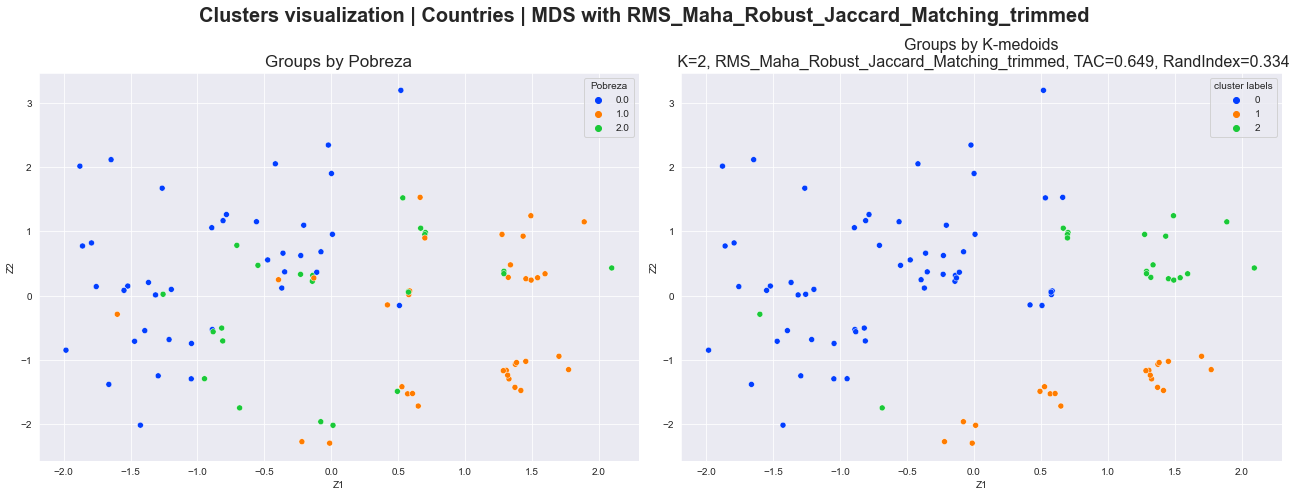

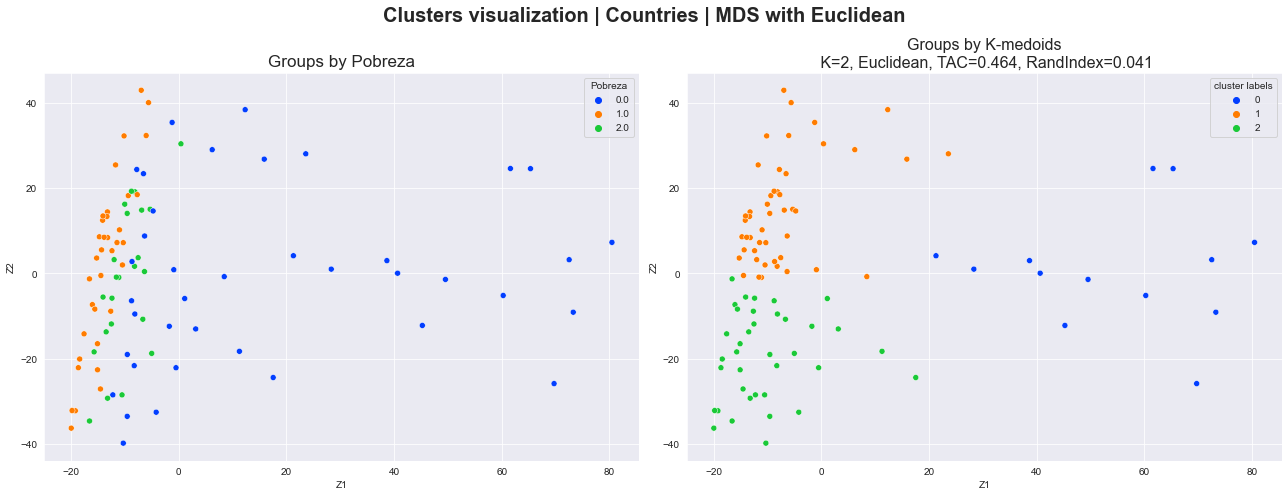

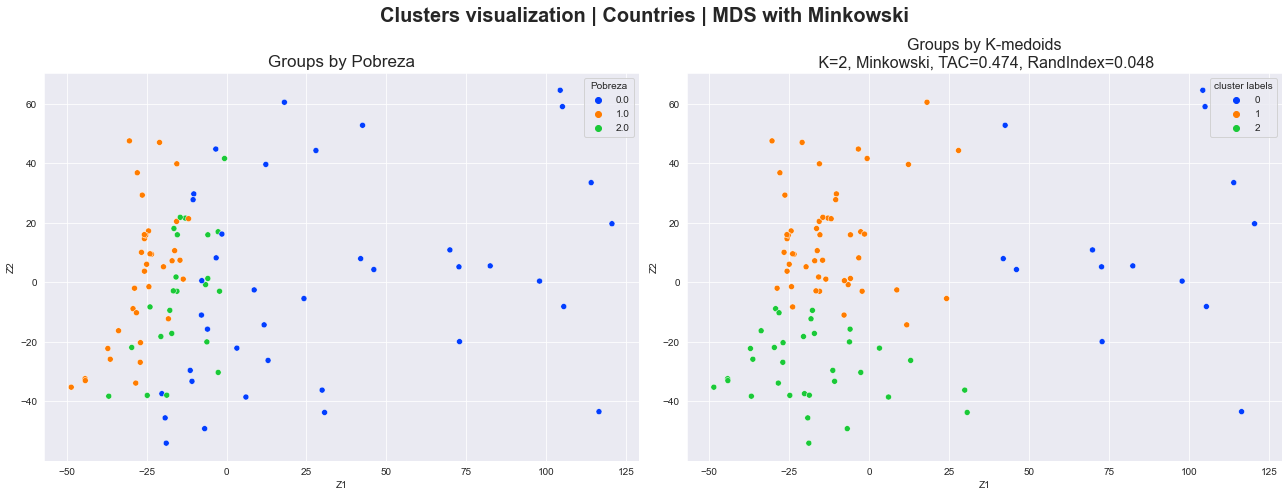

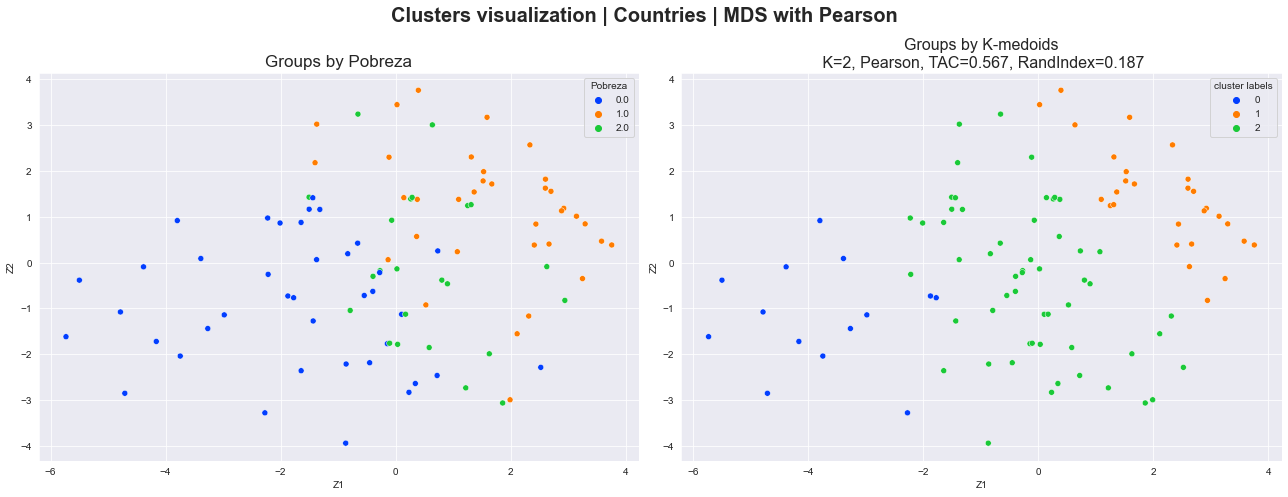

In [16]:
Empirical_test_init.get_plots()
# 10 seg

## Data synthetic (I)

In [294]:
Empirical_test_init = Empirical_test()

In [295]:
X,y = Empirical_test_init.get_data(data='Synthetic I')

In [20]:
X

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8
0,5.253672,-7.689328,-1.783321,0.087619,1,1,1,0
1,-1.980758,-1.243098,-3.975092,5.929425,1,0,3,2
2,1.970278,-3.652849,-4.467229,10.637741,1,1,3,3
3,-4.352624,-1.078641,-10.335118,4.370958,0,1,2,3
4,15.685852,-16.427488,-7.117687,-2.286353,1,1,3,1
...,...,...,...,...,...,...,...,...
495,15.683956,-10.779279,-2.979792,1.310347,1,1,3,0
496,7.621759,-6.115961,2.476059,7.840561,0,0,0,2
497,6.347899,4.554363,-3.618666,-2.641057,1,0,3,3
498,-3.845866,-1.382289,-11.152833,-0.022163,0,0,0,2


In [219]:
y

0      0
1      0
2      0
3      1
4      0
      ..
495    0
496    1
497    0
498    1
499    1
Name: Y, Length: 500, dtype: int32

In [296]:
dic_distance_matrix = Empirical_test_init.get_distance_matrix(alpha_=0.1, only_maha_robust=False)
# Time : 3.51, 3.39 mins

Al calcular Minkowski se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-17.24682435300508, -4.8339644307460565, -3.0029561451267957, -1.7316815772896477, -1.267051843554093, -1.0117403199402712, -0.5706437777519454]
G_1 ha sido transformada y ahora es SDP
Al calcular Minkowski se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-17.24682435300508, -4.8339644307460565, -3.0029561451267957, -1.7316815772896477, -1.267051843554093, -1.0117403199402712, -0.5706437777519454]
G_1 ha sido transformada y ahora es SDP
Al calcular Canberra se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-9.544235283242443, -8.25583187133897, -7.5093019967132575, -6.917604423425638, -6.512120788256739, -5.649356449512628, -5.3

In [292]:
dict(list(dic_distance_matrix.items())[0:3]) # It's a head(6) of the dictionary dic_distance_matrix

{'Euclidean': array([[ 0.        , 11.90887982, 12.59294622, ..., 13.26346308,
         14.74381696,  9.4763868 ],
        [11.90887982,  0.        ,  6.76963971, ..., 13.32506223,
         10.02194453,  4.56675232],
        [12.59294622,  6.76963971,  0.        , ..., 16.26555968,
         14.46768212,  5.73941312],
        ...,
        [13.26346308, 13.32506223, 16.26555968, ...,  0.        ,
         14.62118229, 12.71766914],
        [14.74381696, 10.02194453, 14.46768212, ..., 14.62118229,
          0.        , 12.05955252],
        [ 9.4763868 ,  4.56675232,  5.73941312, ..., 12.71766914,
         12.05955252,  0.        ]]),
 'Minkowski': array([[ 0.        , 26.71423697, 25.55390434, ..., 23.90193756,
         29.88587033, 19.6076126 ],
        [26.71423697,  0.        , 13.56124   , ..., 24.0530261 ,
         19.13362844, 10.23295814],
        [25.55390434, 13.56124   ,  0.        , ..., 27.71219486,
         31.43221145, 13.93987367],
        ...,
        [23.90193756, 24.053

In [297]:
df_distance_tunning_TAC, df_distance_tunning_RandIndex = Empirical_test_init.get_tables()
# < 10 seg

In [119]:
tables_results['df_distance_tunning_TAC_Synthetic_I'] = df_distance_tunning_TAC
tables_results['df_distance_tunning_RandIndex_Synthetic_I'] = df_distance_tunning_RandIndex
# You can see these tables in '## Tables with TAC and Rand Index' section , at the bottom of the notebook.

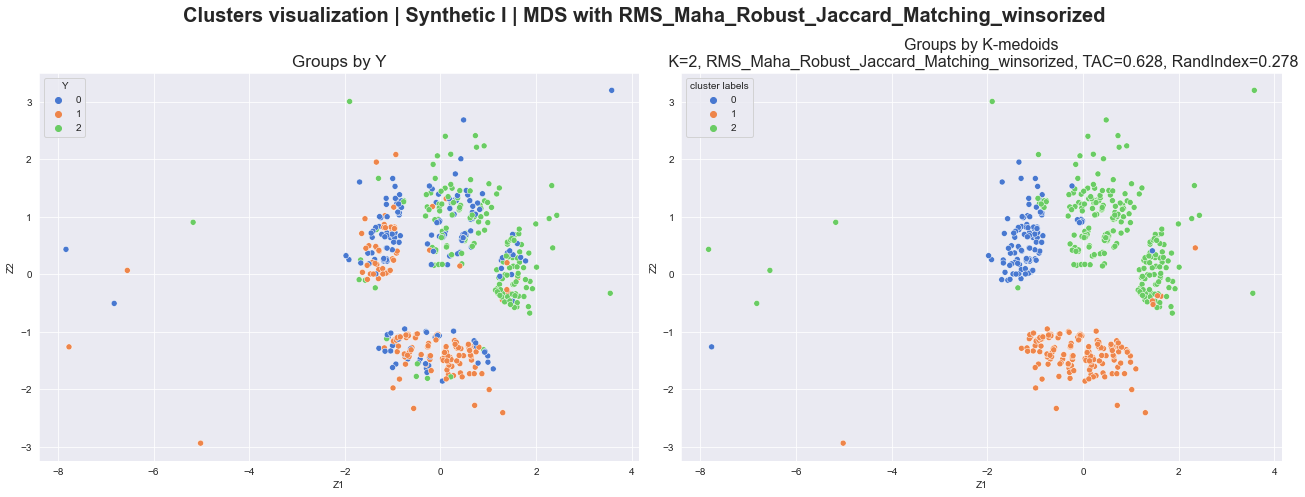

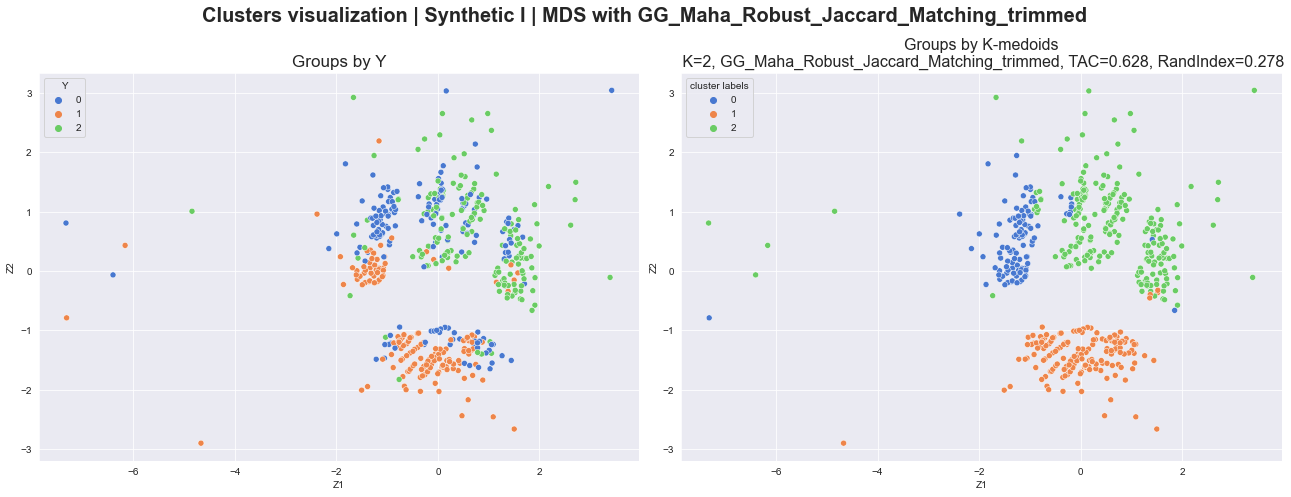

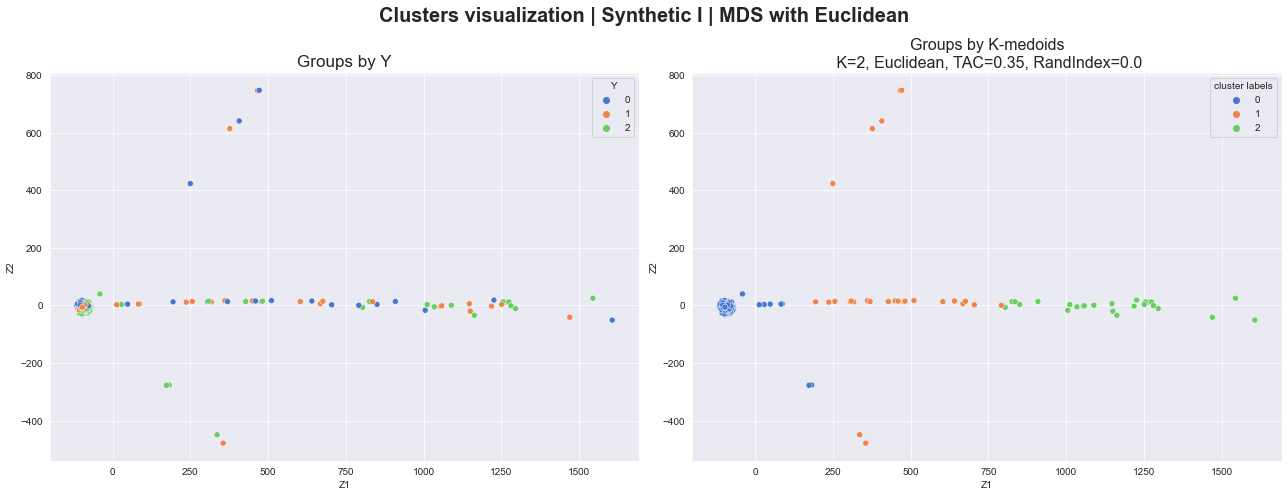

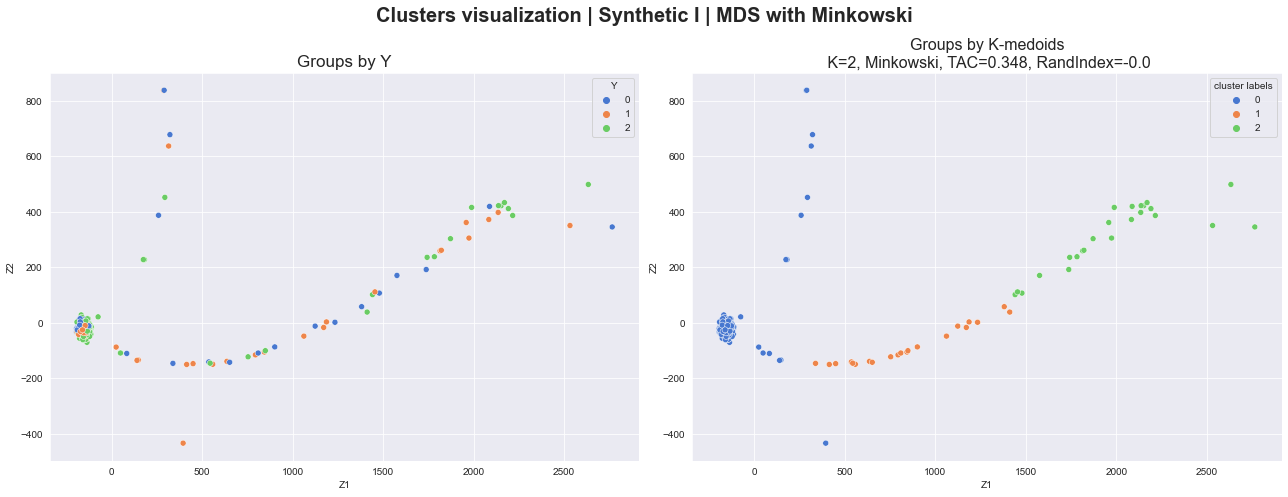

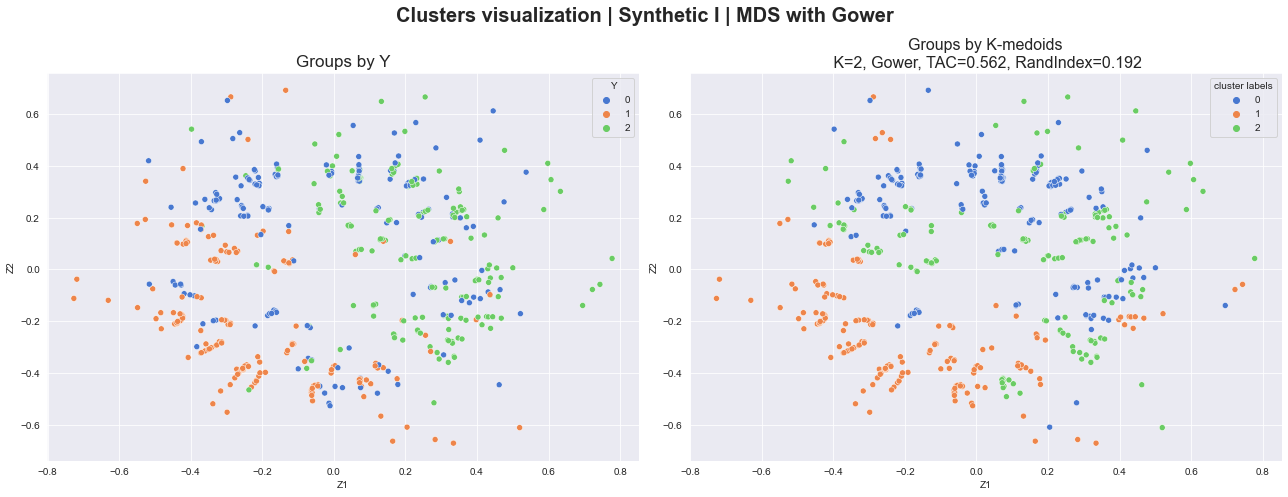

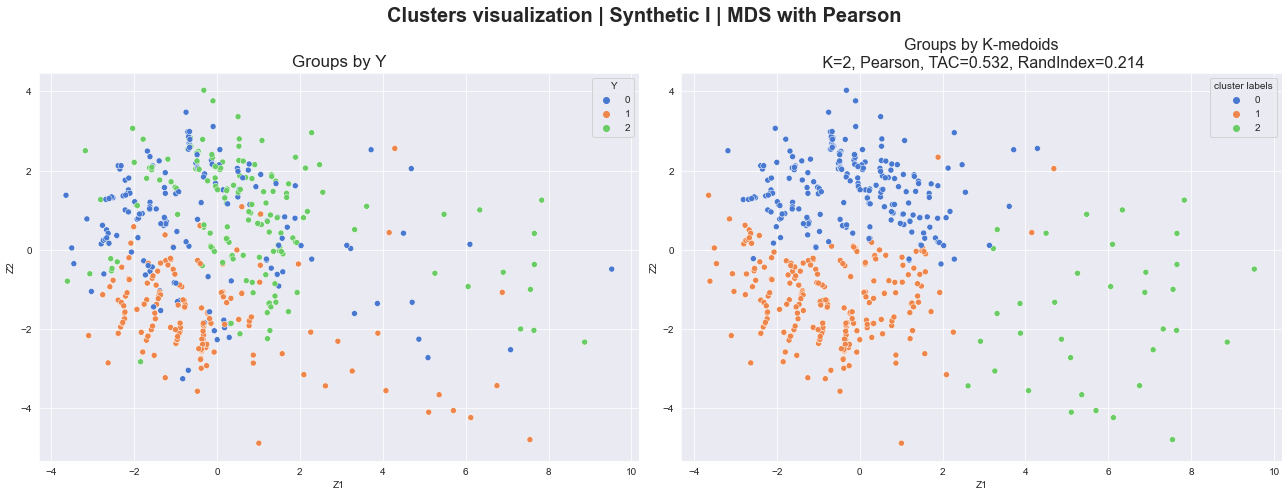

In [298]:
Empirical_test_init.get_plots()
# 1 min

## Synthetic Data II

In [121]:
Empirical_test_init = Empirical_test()

In [122]:
X,y = Empirical_test_init.get_data(data='Synthetic II')

In [123]:
dic_distance_matrix = Empirical_test_init.get_distance_matrix(alpha_=0.1, only_maha_robust=False)
# Time : 6.20, 6.16min, 5.38 min

Al calcular Minkowski se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-13.110254818267869, -3.3454725231331404, -1.4658942745970776, -1.2642920270137832, -1.0503164079966116, -0.8951645096582783, -0.7249247784835732]
G_1 ha sido transformada y ahora es SDP
Al calcular Minkowski se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-13.110254818267869, -3.3454725231331404, -1.4658942745970776, -1.2642920270137832, -1.0503164079966116, -0.8951645096582783, -0.7249247784835732]
G_1 ha sido transformada y ahora es SDP
Al calcular Canberra se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-18.7892081109319, -13.090680454552778, -11.506877104527364, -8.930968085384926, -8.448645196311784, -6.750120981550313,

In [93]:
dict(list(dic_distance_matrix.items())[0:3]) # It's a head(3) of the dictionary dic_distance_matrix

{'Euclidean': array([[ 0.        ,  6.22532074,  3.55397266, ...,  7.68166604,
         10.48723983,  2.0931303 ],
        [ 6.22532074,  0.        ,  3.46564695, ...,  4.30229474,
          6.63816143,  4.42782223],
        [ 3.55397266,  3.46564695,  0.        , ...,  4.28383647,
          7.47399742,  2.19344043],
        ...,
        [ 7.68166604,  4.30229474,  4.28383647, ...,  0.        ,
          5.86906839,  6.42329809],
        [10.48723983,  6.63816143,  7.47399742, ...,  5.86906839,
          0.        ,  8.92692556],
        [ 2.0931303 ,  4.42782223,  2.19344043, ...,  6.42329809,
          8.92692556,  0.        ]]),
 'Minkowski': array([[ 0.        , 15.9365329 ,  7.76921756, ..., 17.22167094,
         20.97679665,  4.08919273],
        [15.9365329 ,  0.        ,  8.19412459, ..., 11.01760873,
         14.61334027, 11.84734017],
        [ 7.76921756,  8.19412459,  0.        , ...,  9.79635694,
         13.55148265,  4.97078587],
        ...,
        [17.22167094, 11.017

In [124]:
df_distance_tunning_TAC, df_distance_tunning_RandIndex = Empirical_test_init.get_tables()

In [126]:
tables_results['df_distance_tunning_TAC_Synthetic_II'] = df_distance_tunning_TAC
tables_results['df_distance_tunning_RandIndex_Synthetic_II'] = df_distance_tunning_RandIndex
# You can see these tables in '## Tables with TAC and Rand Index' section , at the bottom of the notebook.

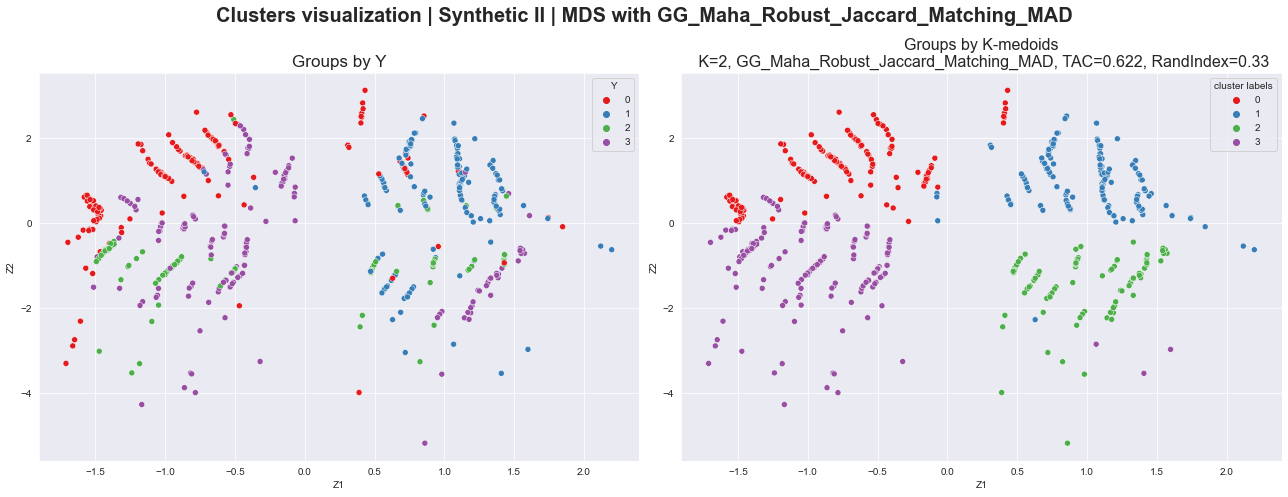

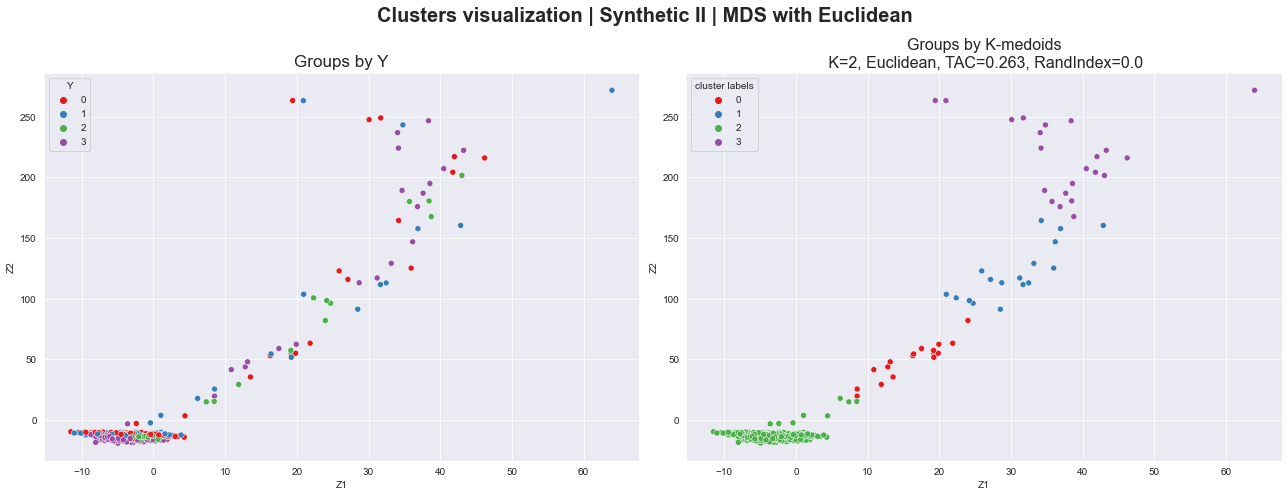

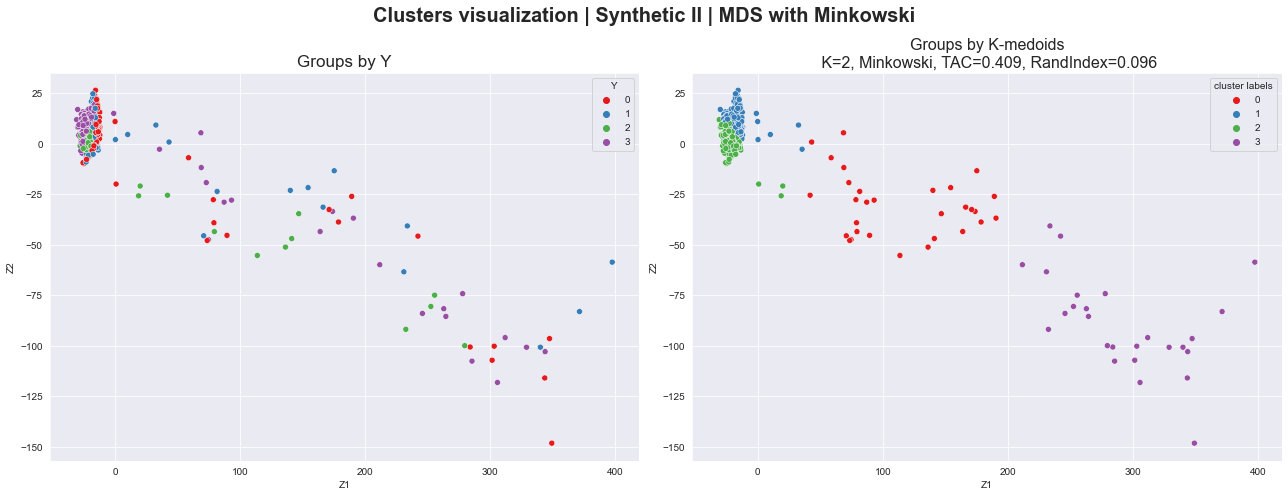

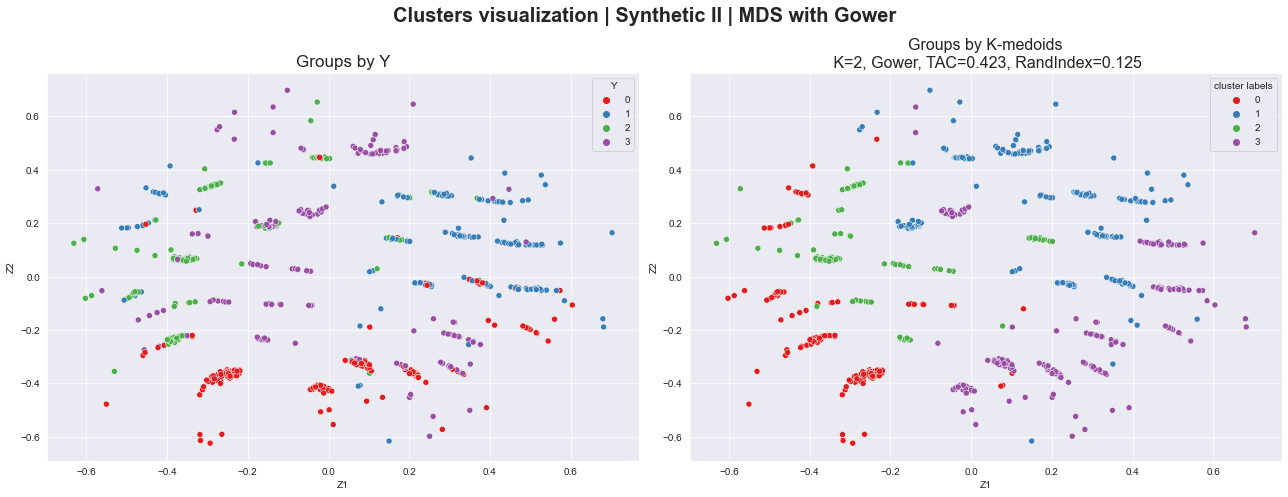

In [127]:
Empirical_test_init.get_plots()
# 1.10min

## Synthetic Data III

In [135]:
Empirical_test_init = Empirical_test()

In [136]:
X,y = Empirical_test_init.get_data(data='Synthetic III')

In [137]:
dic_distance_matrix = Empirical_test_init.get_distance_matrix(alpha_=0.08, only_maha_robust=False)
# Time : 5.20, 4.50, 5.37 min

Al calcular Minkowski se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-26.69819867942431, -14.4816050908678, -9.136906482289437, -3.9371999445196653, -3.551850784370158, -2.574782950060748, -2.471996160866164]
G_1 ha sido transformada y ahora es SDP
Al calcular Minkowski se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-26.69819867942431, -14.4816050908678, -9.136906482289437, -3.9371999445196653, -3.551850784370158, -2.574782950060748, -2.471996160866164]
G_1 ha sido transformada y ahora es SDP
Al calcular Canberra se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-24.33245459405751, -14.441402705116488, -10.561492332624766, -8.896436765606339, -8.114981466766652, -6.430842693912945, -5.925313990

In [ ]:
dict(list(dic_distance_matrix.items())[0:3]) # It's a head(3) of the dictionary dic_distance_matrix

In [138]:
df_distance_tunning_TAC, df_distance_tunning_RandIndex = Empirical_test_init.get_tables()

In [139]:
tables_results['df_distance_tunning_TAC_Synthetic_III'] = df_distance_tunning_TAC
tables_results['df_distance_tunning_RandIndex_Synthetic_III'] = df_distance_tunning_RandIndex
# You can see these tables in '## Tables with TAC and Rand Index' section , at the bottom of the notebook.

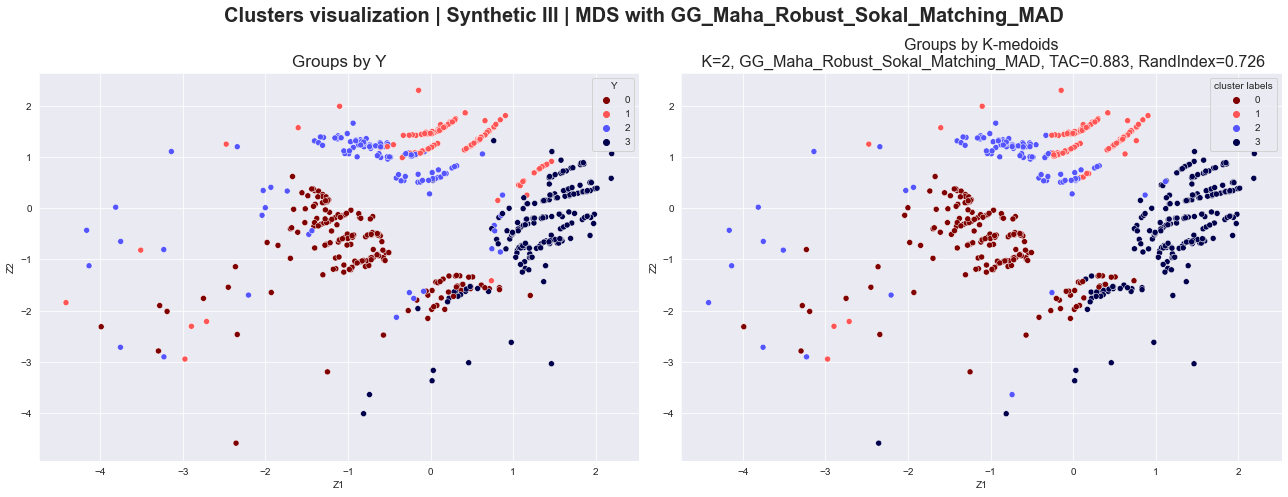

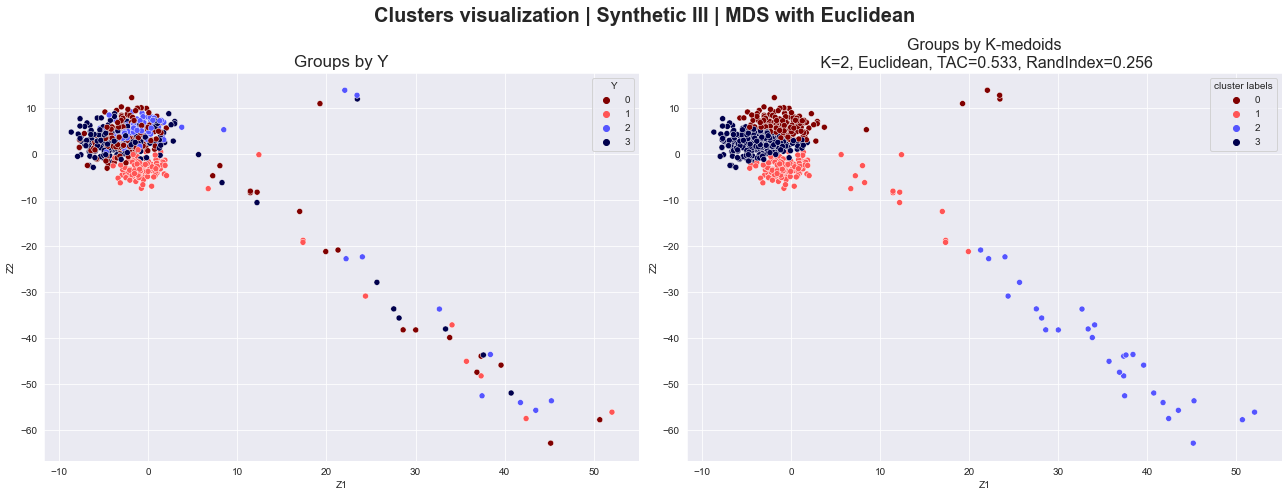

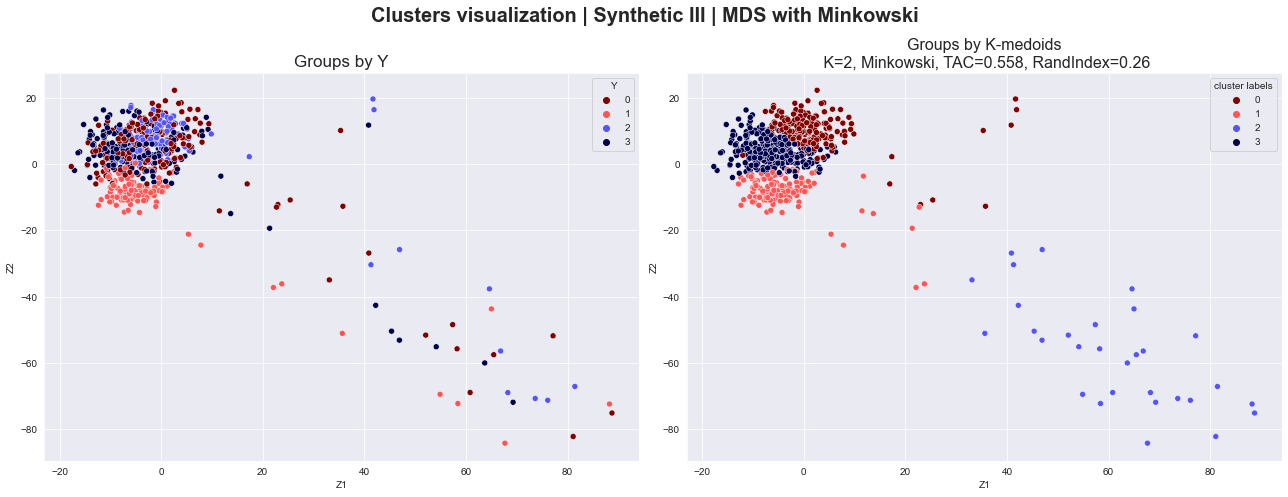

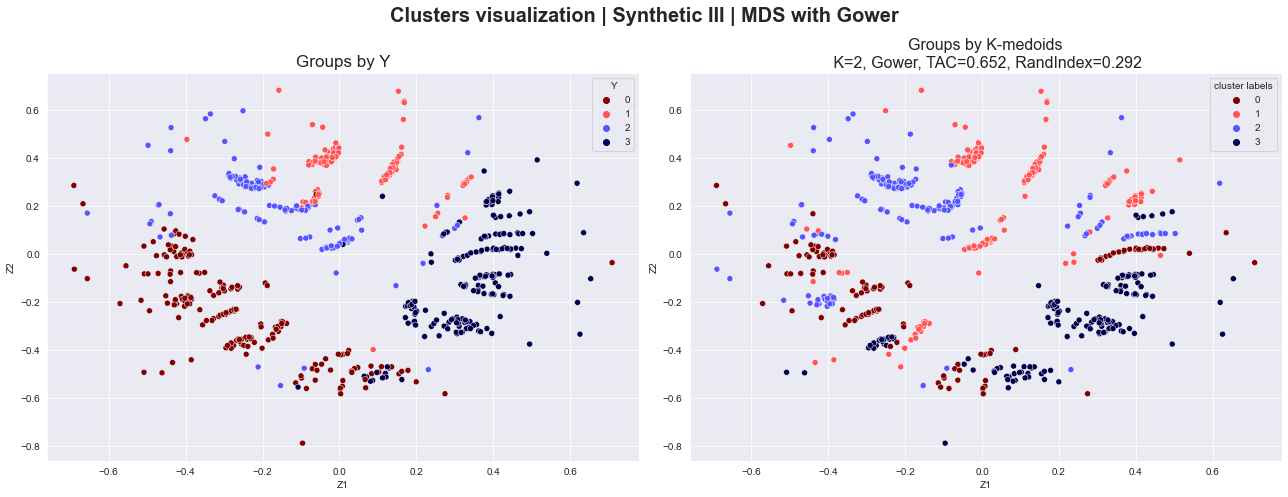

In [140]:
Empirical_test_init.get_plots()
# 1.14 mins

## Houses data

In [103]:
Empirical_test_init = Empirical_test()

In [104]:
X,y = Empirical_test_init.get_data(data='Houses')

In [105]:
dic_distance_matrix = Empirical_test_init.get_distance_matrix(alpha_=0.1, only_maha_robust=False)
# Time : 55, 58, 49 mins

Al calcular Canberra se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-41.21786017614964, -40.92363609037929, -21.99314454793849, -15.910881088207788, -14.5521469840294, -13.174538297454411, -8.94615501523856]
G_1 ha sido transformada y ahora es SDP
Al calcular Canberra se ha comprobado que G_1 no es semidefinida positiva, y debe serlo. Se le aplicara una transformacion.
Autovalores negativos de G_1 (primeros 7): [-41.21786017614964, -40.92363609037929, -21.99314454793849, -15.910881088207788, -14.5521469840294, -13.174538297454411, -8.94615501523856]
G_1 ha sido transformada y ahora es SDP


In [ ]:
dict(list(dic_distance_matrix.items())[0:3]) # It's a head(3) of the dictionary dic_distance_matrix

In [106]:
df_distance_tunning_TAC, df_distance_tunning_RandIndex = Empirical_test_init.get_tables()
# 50 seg

In [107]:
tables_results['df_distance_tunning_TAC_Houses'] = df_distance_tunning_TAC
tables_results['df_distance_tunning_RandIndex_Houses'] = df_distance_tunning_RandIndex
# You can see these tables in '## Tables with TAC and Rand Index' section , at the bottom of the notebook.

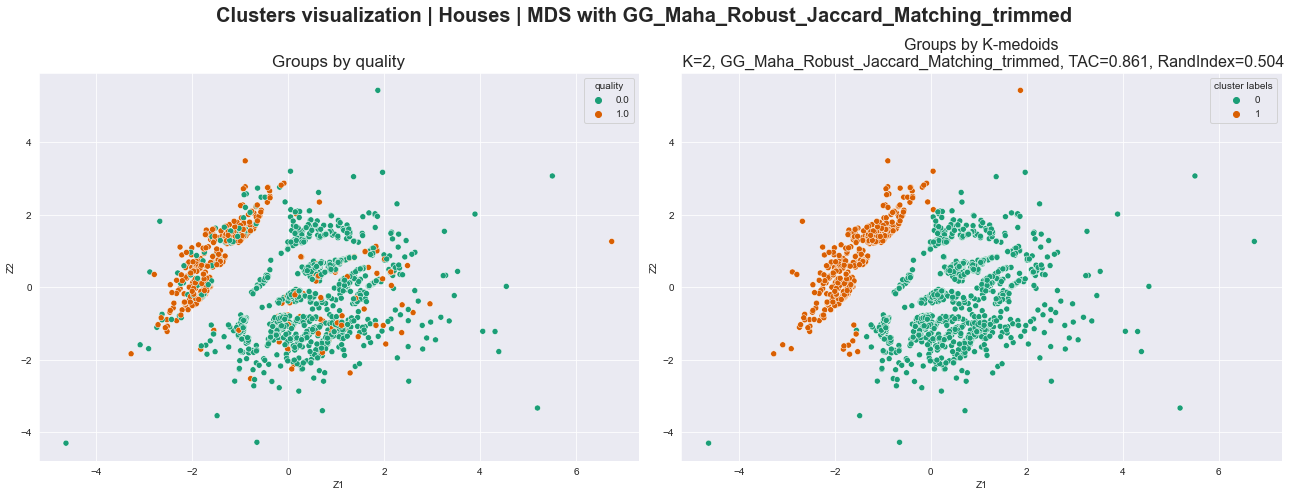

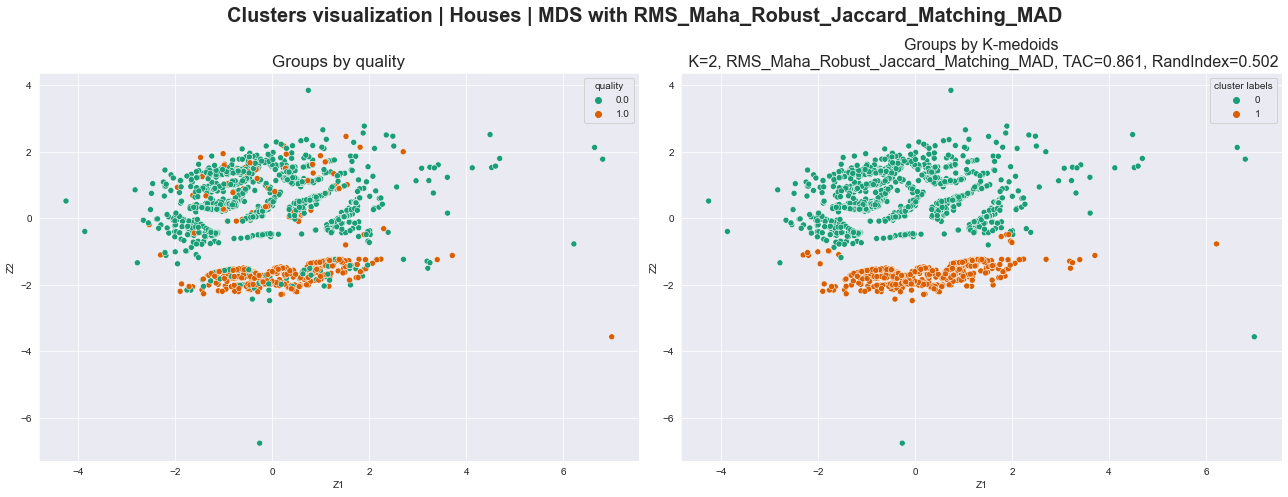

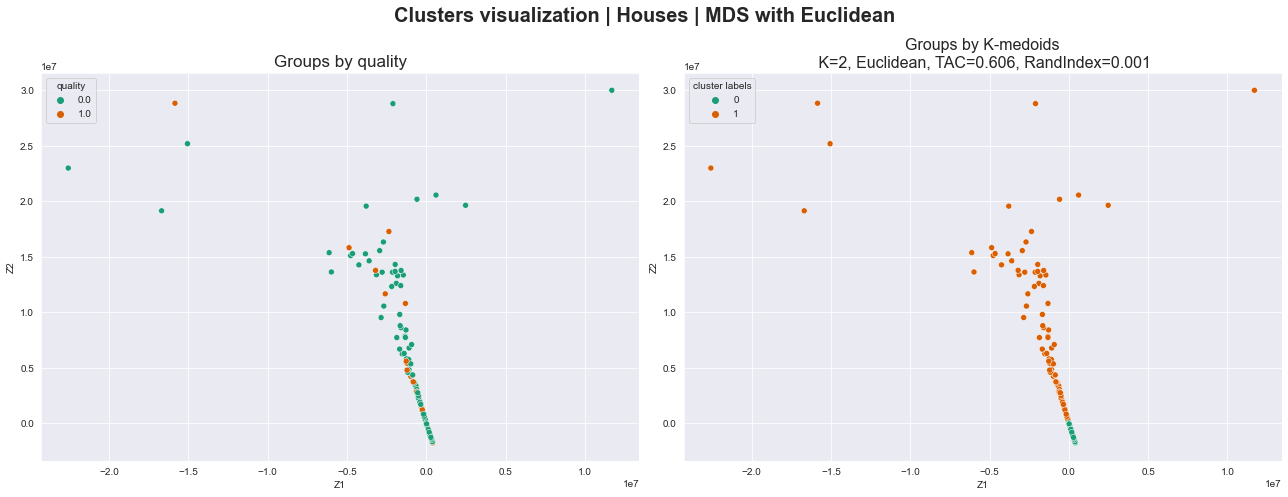

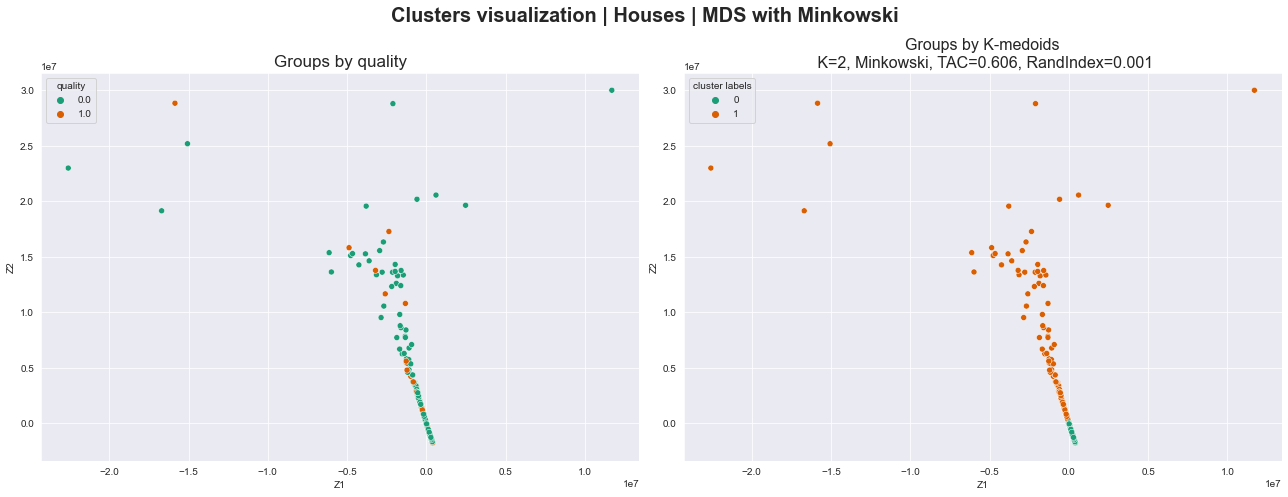

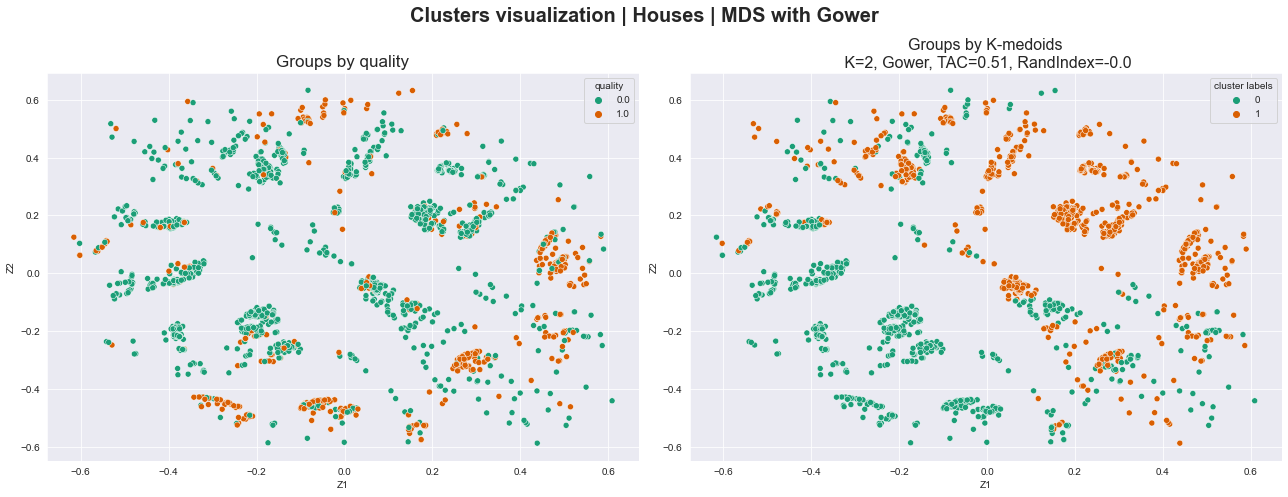

In [108]:
Empirical_test_init.get_plots()
# 15 mins

### Saving the tables in a pickle

In [142]:
with open("tables_results.pickle", "wb") as outfile:
    pickle.dump(tables_results, outfile)


## Tables with TAC and Rand Index

In [2]:
with open("tables_results.pickle", "rb") as infile:
    tables_results = pickle.load(infile)

### Tables for Countries Data

In [3]:
tables_results['df_distance_tunning_TAC_Countries']

,distance,TAC,cluster labels recoded
14,GG_Canberra_Jaccard_Matching,0.659794,"{2: 0, 1: 1, 0: 2}"
20,GG_Maha_Robust_Sokal_Matching_winsorized,0.649485,"{1: 0, 2: 1, 0: 2}"
39,RMS_Maha_Robust_Jaccard_Matching_winsorized,0.649485,"{1: 0, 2: 1, 0: 2}"
38,RMS_Maha_Robust_Jaccard_Matching_trimmed,0.649485,"{1: 0, 2: 1, 0: 2}"
23,GG_Maha_Robust_Jaccard_Matching_winsorized,0.649485,"{1: 0, 2: 1, 0: 2}"
19,GG_Maha_Robust_Sokal_Matching_trimmed,0.649485,"{1: 0, 2: 1, 0: 2}"
34,RMS_Mahalanobis_Jaccard_Matching,0.649485,"{1: 0, 2: 1, 0: 2}"
17,GG_Mahalanobis_Sokal_Matching,0.649485,"{1: 0, 2: 1, 0: 2}"
30,RMS_Canberra_Jaccard_Matching,0.649485,"{2: 0, 1: 1, 0: 2}"
16,GG_Pearson_Jaccard_Matching,0.649485,"{0: 0, 2: 1, 1: 2}"


In [4]:
tables_results['df_distance_tunning_RandIndex_Countries']

,distance,Rand Index
14,GG_Canberra_Jaccard_Matching,0.405188
30,RMS_Canberra_Jaccard_Matching,0.397914
13,GG_Canberra_Sokal_Matching,0.382536
15,GG_Pearson_Sokal_Matching,0.375701
19,GG_Maha_Robust_Sokal_Matching_trimmed,0.375463
17,GG_Mahalanobis_Sokal_Matching,0.354318
20,GG_Maha_Robust_Sokal_Matching_winsorized,0.354318
26,RMS_Euclidea_Jaccard_Matching,0.353248
10,GG_Euclidea_Jaccard_Matching,0.353248
2,Canberra,0.350875


In [5]:
join = pd.merge(tables_results['df_distance_tunning_TAC_Countries'],tables_results['df_distance_tunning_RandIndex_Countries'], on='distance', how='inner' ).loc[:,['distance','TAC', 'Rand Index']]
join

,distance,TAC,Rand Index
0,GG_Canberra_Jaccard_Matching,0.659794,0.405188
1,GG_Maha_Robust_Sokal_Matching_winsorized,0.649485,0.354318
2,RMS_Maha_Robust_Jaccard_Matching_winsorized,0.649485,0.334477
3,RMS_Maha_Robust_Jaccard_Matching_trimmed,0.649485,0.334477
4,GG_Maha_Robust_Jaccard_Matching_winsorized,0.649485,0.334477
5,GG_Maha_Robust_Sokal_Matching_trimmed,0.649485,0.375463
6,RMS_Mahalanobis_Jaccard_Matching,0.649485,0.334477
7,GG_Mahalanobis_Sokal_Matching,0.649485,0.354318
8,RMS_Canberra_Jaccard_Matching,0.649485,0.397914
9,GG_Pearson_Jaccard_Matching,0.649485,0.315937


### Tables for Houses Data

In [146]:
tables_results['df_distance_tunning_TAC_Houses']

,distance,TAC,cluster labels recoded
18,GG_Mahalanobis_Jaccard_Matching,0.861942,"{0: 0, 1: 1}"
22,GG_Maha_Robust_Jaccard_Matching_trimmed,0.861417,"{0: 0, 1: 1}"
23,GG_Maha_Robust_Jaccard_Matching_winsorized,0.861417,"{0: 0, 1: 1}"
24,GG_Maha_Robust_Jaccard_Matching_MAD,0.861417,"{0: 0, 1: 1}"
34,RMS_Mahalanobis_Jaccard_Matching,0.860892,"{0: 0, 1: 1}"
14,GG_Canberra_Jaccard_Matching,0.860892,"{0: 0, 1: 1}"
30,RMS_Canberra_Jaccard_Matching,0.860892,"{0: 0, 1: 1}"
40,RMS_Maha_Robust_Jaccard_Matching_MAD,0.860892,"{0: 0, 1: 1}"
32,RMS_Pearson_Jaccard_Matching,0.860892,"{1: 0, 0: 1}"
16,GG_Pearson_Jaccard_Matching,0.860367,"{1: 0, 0: 1}"


In [147]:
tables_results['df_distance_tunning_RandIndex_Houses']

,distance,Rand Index
18,GG_Mahalanobis_Jaccard_Matching,0.505161
22,GG_Maha_Robust_Jaccard_Matching_trimmed,0.503672
23,GG_Maha_Robust_Jaccard_Matching_winsorized,0.503672
24,GG_Maha_Robust_Jaccard_Matching_MAD,0.503672
34,RMS_Mahalanobis_Jaccard_Matching,0.502544
14,GG_Canberra_Jaccard_Matching,0.502365
30,RMS_Canberra_Jaccard_Matching,0.502365
40,RMS_Maha_Robust_Jaccard_Matching_MAD,0.502365
32,RMS_Pearson_Jaccard_Matching,0.502365
16,GG_Pearson_Jaccard_Matching,0.500702


In [6]:
join = pd.merge(tables_results['df_distance_tunning_TAC_Houses'],tables_results['df_distance_tunning_RandIndex_Houses'], on='distance', how='inner' ).loc[:,['distance','TAC', 'Rand Index']]
join

,distance,TAC,Rand Index
0,GG_Mahalanobis_Jaccard_Matching,0.861942,0.505161
1,GG_Maha_Robust_Jaccard_Matching_trimmed,0.861417,0.503672
2,GG_Maha_Robust_Jaccard_Matching_winsorized,0.861417,0.503672
3,GG_Maha_Robust_Jaccard_Matching_MAD,0.861417,0.503672
4,RMS_Mahalanobis_Jaccard_Matching,0.860892,0.502544
5,GG_Canberra_Jaccard_Matching,0.860892,0.502365
6,RMS_Canberra_Jaccard_Matching,0.860892,0.502365
7,RMS_Maha_Robust_Jaccard_Matching_MAD,0.860892,0.502365
8,RMS_Pearson_Jaccard_Matching,0.860892,0.502365
9,GG_Pearson_Jaccard_Matching,0.860367,0.500702


### Tables for Synthetic Data I

In [289]:
tables_results['df_distance_tunning_TAC_Synthetic_I']

,distance,TAC,cluster labels recoded
34,RMS_Mahalanobis_Jaccard_Matching,0.630,"{1: 2, 2: 0, 0: 1}"
22,GG_Maha_Robust_Jaccard_Matching_trimmed,0.628,"{2: 2, 0: 0, 1: 1}"
39,RMS_Maha_Robust_Jaccard_Matching_winsorized,0.628,"{2: 2, 0: 0, 1: 1}"
18,GG_Mahalanobis_Jaccard_Matching,0.628,"{1: 2, 2: 0, 0: 1}"
23,GG_Maha_Robust_Jaccard_Matching_winsorized,0.628,"{2: 2, 0: 0, 1: 1}"
30,RMS_Canberra_Jaccard_Matching,0.622,"{1: 0, 0: 2, 2: 1}"
14,GG_Canberra_Jaccard_Matching,0.620,"{2: 0, 0: 2, 1: 1}"
13,GG_Canberra_Sokal_Matching,0.620,"{0: 0, 1: 2, 2: 1}"
29,RMS_Canberra_Sokal_Matching,0.612,"{2: 2, 0: 0, 1: 1}"
2,Canberra,0.610,"{1: 2, 2: 1, 0: 0}"


In [149]:
tables_results['df_distance_tunning_RandIndex_Synthetic_I']

,distance,Rand Index
22,GG_Maha_Robust_Jaccard_Matching_trimmed,0.278432
23,GG_Maha_Robust_Jaccard_Matching_winsorized,0.278432
39,RMS_Maha_Robust_Jaccard_Matching_winsorized,0.277728
34,RMS_Mahalanobis_Jaccard_Matching,0.273666
18,GG_Mahalanobis_Jaccard_Matching,0.268592
38,RMS_Maha_Robust_Jaccard_Matching_trimmed,0.255065
32,RMS_Pearson_Jaccard_Matching,0.244771
30,RMS_Canberra_Jaccard_Matching,0.238612
2,Canberra,0.235004
14,GG_Canberra_Jaccard_Matching,0.230389


In [7]:
join = pd.merge(tables_results['df_distance_tunning_TAC_Synthetic_I'],tables_results['df_distance_tunning_RandIndex_Synthetic_I'], on='distance', how='inner' ).loc[:,['distance','TAC', 'Rand Index']]
join

,distance,TAC,Rand Index
0,RMS_Mahalanobis_Jaccard_Matching,0.630,0.273666
1,GG_Maha_Robust_Jaccard_Matching_trimmed,0.628,0.278432
2,RMS_Maha_Robust_Jaccard_Matching_winsorized,0.628,0.277728
3,GG_Mahalanobis_Jaccard_Matching,0.628,0.268592
4,GG_Maha_Robust_Jaccard_Matching_winsorized,0.628,0.278432
5,RMS_Canberra_Jaccard_Matching,0.622,0.238612
6,GG_Canberra_Jaccard_Matching,0.620,0.230389
7,GG_Canberra_Sokal_Matching,0.620,0.218362
8,RMS_Canberra_Sokal_Matching,0.612,0.212984
9,Canberra,0.610,0.235004


### Tables for Synthetic Data II

In [22]:
tables_results['df_distance_tunning_TAC_Synthetic_II']

,distance,TAC,cluster labels recoded
24,GG_Maha_Robust_Jaccard_Matching_MAD,0.621538,"{3: 0, 0: 1, 2: 3, 1: 2}"
17,GG_Mahalanobis_Sokal_Matching,0.592308,"{0: 0, 2: 1, 3: 2, 1: 3}"
40,RMS_Maha_Robust_Jaccard_Matching_MAD,0.590769,"{3: 0, 0: 1, 1: 3, 2: 2}"
37,RMS_Maha_Robust_Sokal_Matching_MAD,0.567692,"{3: 0, 0: 1, 2: 2, 1: 3}"
33,RMS_Mahalanobis_Sokal_Matching,0.567692,"{1: 3, 2: 1, 3: 2, 0: 0}"
6,Mahalanobis_Robust_winsorized,0.563077,"{1: 3, 2: 1, 0: 2, 3: 0}"
13,GG_Canberra_Sokal_Matching,0.561538,"{1: 3, 0: 1, 3: 2, 2: 0}"
36,RMS_Maha_Robust_Sokal_Matching_winsorized,0.558462,"{2: 3, 1: 1, 3: 2, 0: 0}"
35,RMS_Maha_Robust_Sokal_Matching_trimmed,0.558462,"{2: 3, 1: 1, 3: 2, 0: 0}"
31,RMS_Pearson_Sokal_Matching,0.552308,"{2: 3, 3: 1, 1: 2, 0: 0}"


In [24]:
tables_results['df_distance_tunning_RandIndex_Synthetic_II']

,distance,Rand Index
24,GG_Maha_Robust_Jaccard_Matching_MAD,0.329944
17,GG_Mahalanobis_Sokal_Matching,0.324297
37,RMS_Maha_Robust_Sokal_Matching_MAD,0.297498
40,RMS_Maha_Robust_Jaccard_Matching_MAD,0.260597
6,Mahalanobis_Robust_winsorized,0.248570
4,Mahalanobis,0.247289
25,RMS_Euclidea_Sokal_Matching,0.244515
5,Mahalanobis_Robust_trimmed,0.238187
11,GG_Minkowski_Sokal_Matching,0.232898
9,GG_Euclidea_Sokal_Matching,0.232898


In [8]:
join = pd.merge(tables_results['df_distance_tunning_TAC_Synthetic_II'],tables_results['df_distance_tunning_RandIndex_Synthetic_II'], on='distance', how='inner' ).loc[:,['distance','TAC', 'Rand Index']]
join

,distance,TAC,Rand Index
0,GG_Maha_Robust_Jaccard_Matching_MAD,0.621538,0.329944
1,GG_Mahalanobis_Sokal_Matching,0.592308,0.324297
2,RMS_Maha_Robust_Jaccard_Matching_MAD,0.590769,0.260597
3,RMS_Maha_Robust_Sokal_Matching_MAD,0.567692,0.297498
4,RMS_Mahalanobis_Sokal_Matching,0.567692,0.228790
5,Mahalanobis_Robust_winsorized,0.563077,0.248570
6,GG_Canberra_Sokal_Matching,0.561538,0.221440
7,RMS_Maha_Robust_Sokal_Matching_winsorized,0.558462,0.216499
8,RMS_Maha_Robust_Sokal_Matching_trimmed,0.558462,0.216499
9,RMS_Pearson_Sokal_Matching,0.552308,0.202442


##### Tables for Synthetic Data III

In [39]:
tables_results['df_distance_tunning_TAC_Synthetic_III']

,distance,TAC,cluster labels recoded
21,GG_Maha_Robust_Sokal_Matching_MAD,0.883333,"{2: 3, 0: 2, 3: 0, 1: 1}"
15,GG_Pearson_Sokal_Matching,0.881667,"{3: 3, 1: 2, 2: 0, 0: 1}"
2,Canberra,0.880000,"{3: 3, 0: 2, 1: 0, 2: 1}"
14,GG_Canberra_Jaccard_Matching,0.880000,"{0: 0, 1: 2, 2: 1, 3: 3}"
13,GG_Canberra_Sokal_Matching,0.880000,"{2: 0, 1: 2, 0: 1, 3: 3}"
29,RMS_Canberra_Sokal_Matching,0.866667,"{2: 3, 0: 2, 3: 1, 1: 0}"
6,Mahalanobis_Robust_winsorized,0.853333,"{2: 3, 0: 2, 1: 1, 3: 0}"
30,RMS_Canberra_Jaccard_Matching,0.850000,"{1: 2, 3: 1, 2: 0, 0: 3}"
37,RMS_Maha_Robust_Sokal_Matching_MAD,0.731667,"{0: 3, 1: 1, 3: 0, 2: 2}"
31,RMS_Pearson_Sokal_Matching,0.730000,"{0: 3, 3: 1, 1: 0, 2: 2}"


In [42]:
tables_results['df_distance_tunning_RandIndex_Synthetic_III']

,distance,Rand Index
21,GG_Maha_Robust_Sokal_Matching_MAD,0.726101
15,GG_Pearson_Sokal_Matching,0.723303
14,GG_Canberra_Jaccard_Matching,0.704662
13,GG_Canberra_Sokal_Matching,0.703744
2,Canberra,0.702686
29,RMS_Canberra_Sokal_Matching,0.683853
30,RMS_Canberra_Jaccard_Matching,0.657553
6,Mahalanobis_Robust_winsorized,0.656277
25,RMS_Euclidea_Sokal_Matching,0.615708
27,RMS_Minkowski_Sokal_Matching,0.615395


In [9]:
join = pd.merge(tables_results['df_distance_tunning_TAC_Synthetic_III'],tables_results['df_distance_tunning_RandIndex_Synthetic_III'], on='distance', how='inner' ).loc[:,['distance','TAC', 'Rand Index']]
join

,distance,TAC,Rand Index
0,GG_Maha_Robust_Sokal_Matching_MAD,0.883333,0.726101
1,GG_Pearson_Sokal_Matching,0.881667,0.723303
2,Canberra,0.880000,0.702686
3,GG_Canberra_Jaccard_Matching,0.880000,0.704662
4,GG_Canberra_Sokal_Matching,0.880000,0.703744
5,RMS_Canberra_Sokal_Matching,0.866667,0.683853
6,Mahalanobis_Robust_winsorized,0.853333,0.656277
7,RMS_Canberra_Jaccard_Matching,0.850000,0.657553
8,RMS_Maha_Robust_Sokal_Matching_MAD,0.731667,0.613787
9,RMS_Pearson_Sokal_Matching,0.730000,0.611196


## Analysing the influence of $\alpha$ in Mahalanobis robust

### Countries

In [ ]:
alpha_comparison = dict()

Empirical_test_init = Empirical_test()
X,y = Empirical_test_init.get_data(data='Countries')

for a in [0.03,0.05,0.08,0.1,0.12,0.15,0.2,0.25,0.30,0.35] :
    dic_distance_matrix = Empirical_test_init.get_distance_matrix(alpha_=a, only_maha_robust=True)
    df_distance_tunning_TAC, df_distance_tunning_RandIndex = Empirical_test_init.get_tables()
    alpha_comparison['alpha='+str(a)] = df_distance_tunning_TAC.loc[df_distance_tunning_TAC['distance'].str.contains('trimmed|winsorized'),:]

In [75]:
alpha_comparison_Countries = alpha_comparison
dict(list(alpha_comparison_Countries.items())[0:3]) 

{'alpha=0.03':                                        distance       TAC  \
 3         GG_Maha_Robust_Sokal_Matching_trimmed  0.649485   
 4      GG_Maha_Robust_Sokal_Matching_winsorized  0.649485   
 6       GG_Maha_Robust_Jaccard_Matching_trimmed  0.649485   
 7    GG_Maha_Robust_Jaccard_Matching_winsorized  0.649485   
 12     RMS_Maha_Robust_Jaccard_Matching_trimmed  0.649485   
 13  RMS_Maha_Robust_Jaccard_Matching_winsorized  0.649485   
 9        RMS_Maha_Robust_Sokal_Matching_trimmed  0.628866   
 10    RMS_Maha_Robust_Sokal_Matching_winsorized  0.628866   
 0                    Mahalanobis_Robust_trimmed  0.556701   
 1                 Mahalanobis_Robust_winsorized  0.453608   
 
    cluster labels recoded  
 3      {1: 0, 2: 1, 0: 2}  
 4      {1: 0, 0: 1, 2: 2}  
 6      {1: 0, 2: 1, 0: 2}  
 7      {2: 0, 0: 1, 1: 2}  
 12     {1: 0, 2: 1, 0: 2}  
 13     {0: 0, 1: 1, 2: 2}  
 9      {0: 0, 1: 1, 2: 2}  
 10     {0: 0, 1: 1, 2: 2}  
 0      {0: 0, 2: 1, 1: 2}  
 1      {1: 

In [78]:
with open("alpha_comparison_Countries.pickle", "wb") as outfile:
    pickle.dump(alpha_comparison_Countries, outfile)

In [81]:
with open("alpha_comparison_Countries.pickle", "rb") as infile:
    alpha_comparison_Countries = pickle.load(infile)

### Synthetic I

In [154]:
alpha_comparison = dict()

Empirical_test_init = Empirical_test()
X,y = Empirical_test_init.get_data(data='Synthetic I')

for a in [0.05,0.1,0.15,0.2,0.25] :
    dic_distance_matrix = Empirical_test_init.get_distance_matrix(alpha_=a, only_maha_robust=True)
    df_distance_tunning_TAC, df_distance_tunning_RandIndex = Empirical_test_init.get_tables()
    alpha_comparison['alpha='+str(a)] = df_distance_tunning_TAC.loc[df_distance_tunning_TAC['distance'].str.contains('trimmed|winsorized'),:]
# 6.33 mins

In [155]:
alpha_comparison_Syn_I = alpha_comparison

In [ ]:
dict(list(alpha_comparison_Syn_I.items())[0:3]) 

In [156]:
with open("alpha_comparison_Syn_I.pickle", "wb") as outfile:
    pickle.dump(alpha_comparison_Syn_I, outfile)

### Synthetic II

In [157]:
alpha_comparison = dict()

Empirical_test_init = Empirical_test()
X,y = Empirical_test_init.get_data(data='Synthetic II')

for a in [0.05,0.1,0.15,0.2,0.25] :
    dic_distance_matrix = Empirical_test_init.get_distance_matrix(alpha_=a, only_maha_robust=True)
    df_distance_tunning_TAC, df_distance_tunning_RandIndex = Empirical_test_init.get_tables()
    alpha_comparison['alpha='+str(a)] = df_distance_tunning_TAC.loc[df_distance_tunning_TAC['distance'].str.contains('trimmed|winsorized'),:]
# 11.50 mins

In [158]:
alpha_comparison_Syn_II = alpha_comparison

In [ ]:
dict(list(alpha_comparison_Syn_II.items())[0:3]) 

In [159]:
with open("alpha_comparison_Syn_II.pickle", "wb") as outfile:
    pickle.dump(alpha_comparison_Syn_II, outfile)

### Synthetic III

In [160]:
alpha_comparison = dict()

Empirical_test_init = Empirical_test()
X,y = Empirical_test_init.get_data(data='Synthetic III')

for a in [0.05,0.1,0.15,0.2,0.25] :
    dic_distance_matrix = Empirical_test_init.get_distance_matrix(alpha_=a, only_maha_robust=True)
    df_distance_tunning_TAC, df_distance_tunning_RandIndex = Empirical_test_init.get_tables()
    alpha_comparison['alpha='+str(a)] = df_distance_tunning_TAC.loc[df_distance_tunning_TAC['distance'].str.contains('trimmed|winsorized'),:]

# 10.21 min

In [161]:
alpha_comparison_Syn_III = alpha_comparison

In [ ]:
dict(list(alpha_comparison_Syn_III.items())[0:3]) 

In [162]:
with open("alpha_comparison_Syn_III.pickle", "wb") as outfile:
    pickle.dump(alpha_comparison_Syn_III, outfile)

### Houses

In [10]:
alpha_comparison = dict()

Empirical_test_init = Empirical_test()
X,y = Empirical_test_init.get_data(data='Houses')

for a in [0.05,0.1,0.15,0.2,0.25] :
    dic_distance_matrix = Empirical_test_init.get_distance_matrix(alpha_=a, only_maha_robust=True)
    df_distance_tunning_TAC, df_distance_tunning_RandIndex = Empirical_test_init.get_tables()
    alpha_comparison['alpha='+str(a)] = df_distance_tunning_TAC.loc[df_distance_tunning_TAC['distance'].str.contains('trimmed|winsorized'),:]
# 89.40 mins

In [11]:
alpha_comparison_Houses = alpha_comparison
dict(list(alpha_comparison_Houses.items())[0:3]) 

{'alpha=0.05':                                        distance       TAC  \
 6       GG_Maha_Robust_Jaccard_Matching_trimmed  0.861417   
 7    GG_Maha_Robust_Jaccard_Matching_winsorized  0.861417   
 12     RMS_Maha_Robust_Jaccard_Matching_trimmed  0.859843   
 13  RMS_Maha_Robust_Jaccard_Matching_winsorized  0.859318   
 3         GG_Maha_Robust_Sokal_Matching_trimmed  0.858268   
 4      GG_Maha_Robust_Sokal_Matching_winsorized  0.858268   
 9        RMS_Maha_Robust_Sokal_Matching_trimmed  0.858268   
 10    RMS_Maha_Robust_Sokal_Matching_winsorized  0.858268   
 0                    Mahalanobis_Robust_trimmed  0.821522   
 1                 Mahalanobis_Robust_winsorized  0.694488   
 
    cluster labels recoded  
 6            {0: 0, 1: 1}  
 7            {0: 0, 1: 1}  
 12           {0: 0, 1: 1}  
 13           {0: 0, 1: 1}  
 3            {0: 0, 1: 1}  
 4            {1: 0, 0: 1}  
 9            {0: 0, 1: 1}  
 10           {0: 0, 1: 1}  
 0            {1: 1, 0: 0}  
 1          

In [12]:
with open("alpha_comparison_Houses.pickle", "wb") as outfile:
    pickle.dump(alpha_comparison_Houses, outfile)

## Tables alpha

### Houses data

In [4]:
with open("alpha_comparison_Houses.pickle", "rb") as infile:
    alpha_comparison_Houses = pickle.load(infile)

In [5]:
keys = alpha_comparison_Houses.keys()
keys = list(keys)

df = pd.merge(alpha_comparison_Houses[keys[0]], alpha_comparison_Houses[keys[1]], on='distance', how='inner')
df = df.rename(columns={'TAC_x' : keys[0], 'TAC_y' : keys[1], 'cluster labels recoded_y' : 'Recodificación'})
recode = df['Recodificación']
df = df.loc[:, ['distance', keys[0], keys[1]]]

for x in keys[2:] :

    df = pd.merge(df, alpha_comparison_Houses[x], on='distance', how='inner')
    df = df.rename(columns={'TAC' : x})
    df = df.drop(columns=['cluster labels recoded'])  

df['Recodificación'] = recode

In [6]:
df_alpha_Houses = df
df_alpha_Houses

,distance,alpha=0.05,alpha=0.1,alpha=0.15,alpha=0.2,alpha=0.25,Recodificación
0,GG_Maha_Robust_Jaccard_Matching_trimmed,0.861417,0.861417,0.861417,0.861942,0.861417,"{0: 0, 1: 1}"
1,GG_Maha_Robust_Jaccard_Matching_winsorized,0.861417,0.861417,0.861417,0.861417,0.861417,"{0: 0, 1: 1}"
2,RMS_Maha_Robust_Jaccard_Matching_trimmed,0.859843,0.859318,0.859843,0.860892,0.862467,"{0: 0, 1: 1}"
3,RMS_Maha_Robust_Jaccard_Matching_winsorized,0.859318,0.859843,0.859843,0.859843,0.859843,"{0: 0, 1: 1}"
4,GG_Maha_Robust_Sokal_Matching_trimmed,0.858268,0.858268,0.858268,0.858268,0.858268,"{0: 0, 1: 1}"
5,GG_Maha_Robust_Sokal_Matching_winsorized,0.858268,0.858268,0.858268,0.858268,0.858268,"{0: 0, 1: 1}"
6,RMS_Maha_Robust_Sokal_Matching_trimmed,0.858268,0.858268,0.858268,0.858268,0.858268,"{0: 0, 1: 1}"
7,RMS_Maha_Robust_Sokal_Matching_winsorized,0.858268,0.858268,0.858268,0.858268,0.858268,"{0: 0, 1: 1}"
8,Mahalanobis_Robust_trimmed,0.821522,0.844619,0.845669,0.845669,0.847769,"{0: 0, 1: 1}"
9,Mahalanobis_Robust_winsorized,0.694488,0.827297,0.841470,0.760105,0.733333,"{0: 0, 1: 1}"


In [8]:
max_min = df_alpha_Houses.max(axis=1) - df_alpha_Houses.min(axis=1)
max_min.sort_values(ascending=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20848\417905288.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  max_min = df_alpha_Houses.max(axis=1) - df_alpha_Houses.min(axis=1)


9    0.146982
8    0.026247
2    0.003150
0    0.000525
3    0.000525
1    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
dtype: float64

#### Countries data

In [3]:
with open("alpha_comparison_Countries.pickle", "rb") as infile:
    alpha_comparison_Countries = pickle.load(infile)

In [81]:
keys = alpha_comparison_Countries.keys()
keys = list(keys)

df = pd.merge(alpha_comparison_Countries[keys[0]], alpha_comparison_Countries[keys[1]], on='distance', how='inner')
df = df.rename(columns={'TAC_x' : keys[0], 'TAC_y' : keys[1], 'cluster labels recoded_y' : 'Recodificación'})
recode = df['Recodificación']
df = df.loc[:, ['distance', keys[0], keys[1]]]

for x in keys[2:] :

    df = pd.merge(df, alpha_comparison_Countries[x], on='distance', how='inner')
    df = df.rename(columns={'TAC' : x})
    df = df.drop(columns=['cluster labels recoded'])  

df['Recodificación'] = recode

In [82]:
df_alpha_Countries = df
df_alpha_Countries

,distance,alpha=0.03,alpha=0.05,alpha=0.08,alpha=0.1,alpha=0.12,alpha=0.15,alpha=0.2,alpha=0.25,alpha=0.3,alpha=0.35,Recodificación
0,GG_Maha_Robust_Sokal_Matching_trimmed,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.639175,0.639175,0.639175,0.639175,"{1: 0, 2: 1, 0: 2}"
1,GG_Maha_Robust_Sokal_Matching_winsorized,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.639175,0.639175,"{1: 0, 2: 1, 0: 2}"
2,GG_Maha_Robust_Jaccard_Matching_trimmed,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.628866,0.649485,"{1: 0, 2: 1, 0: 2}"
3,GG_Maha_Robust_Jaccard_Matching_winsorized,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.649485,0.628866,"{1: 0, 2: 1, 0: 2}"
4,RMS_Maha_Robust_Jaccard_Matching_trimmed,0.649485,0.649485,0.649485,0.649485,0.649485,0.639175,0.639175,0.639175,0.639175,0.649485,"{1: 0, 2: 1, 0: 2}"
5,RMS_Maha_Robust_Jaccard_Matching_winsorized,0.649485,0.649485,0.649485,0.649485,0.649485,0.639175,0.639175,0.649485,0.649485,0.628866,"{1: 0, 2: 1, 0: 2}"
6,RMS_Maha_Robust_Sokal_Matching_trimmed,0.628866,0.628866,0.628866,0.628866,0.628866,0.628866,0.628866,0.628866,0.628866,0.628866,"{1: 0, 0: 1, 2: 2}"
7,RMS_Maha_Robust_Sokal_Matching_winsorized,0.628866,0.628866,0.628866,0.628866,0.628866,0.628866,0.628866,0.628866,0.628866,0.628866,"{0: 0, 1: 1, 2: 2}"
8,Mahalanobis_Robust_trimmed,0.556701,0.515464,0.525773,0.525773,0.525773,0.474227,0.515464,0.484536,0.432990,0.494845,"{0: 0, 2: 1, 1: 2}"
9,Mahalanobis_Robust_winsorized,0.453608,0.556701,0.525773,0.422680,0.556701,0.494845,0.505155,0.494845,0.474227,0.463918,"{2: 2, 0: 0, 1: 1}"


In [14]:
0.649485 - 0.639

0.010484999999999967

In [109]:
max_min = df_alpha_Countries.max(axis=1) - df_alpha_Countries.min(axis=1)
max_min.sort_values(ascending=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_22284\3417194727.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  max_min = df_alpha_Countries.max(axis=1) - df_alpha_Countries.min(axis=1)


9    0.134021
8    0.123711
2    0.020619
3    0.020619
5    0.020619
0    0.010309
1    0.010309
4    0.010309
6    0.000000
7    0.000000
dtype: float64

#### Synthetic data (I)

In [45]:
with open("alpha_comparison_Syn_I.pickle", "rb") as infile:
    alpha_comparison_Syn_I = pickle.load(infile)

In [46]:
keys = alpha_comparison_Syn_I.keys()
keys = list(keys)

df = pd.merge(alpha_comparison_Syn_I[keys[0]], alpha_comparison_Syn_I[keys[1]], on='distance', how='inner')
df = df.rename(columns={'TAC_x' : keys[0], 'TAC_y' : keys[1], 'cluster labels recoded_y' : 'Recodificación'})
recode = df['Recodificación']
df = df.loc[:, ['distance', keys[0], keys[1]]]

for x in keys[2:] :

    df = pd.merge(df, alpha_comparison_Syn_I[x], on='distance', how='inner')
    df = df.rename(columns={'TAC' : x})
    df = df.drop(columns=['cluster labels recoded'])  

df['Recodificación'] = recode

In [47]:
df_alpha_Syn_I = df
df_alpha_Syn_I

,distance,alpha=0.05,alpha=0.1,alpha=0.15,alpha=0.2,alpha=0.25,Recodificación
0,GG_Maha_Robust_Jaccard_Matching_trimmed,0.630,0.628,0.554,0.558,0.556,"{2: 2, 0: 0, 1: 1}"
1,RMS_Maha_Robust_Jaccard_Matching_winsorized,0.630,0.628,0.604,0.548,0.544,"{2: 2, 0: 0, 1: 1}"
2,RMS_Maha_Robust_Jaccard_Matching_trimmed,0.626,0.598,0.538,0.546,0.546,"{0: 2, 1: 0, 2: 1}"
3,GG_Maha_Robust_Jaccard_Matching_winsorized,0.604,0.628,0.628,0.556,0.554,"{2: 2, 0: 0, 1: 1}"
4,RMS_Maha_Robust_Sokal_Matching_trimmed,0.586,0.584,0.580,0.596,0.594,"{1: 2, 2: 0, 0: 1}"
5,RMS_Maha_Robust_Sokal_Matching_winsorized,0.582,0.586,0.580,0.592,0.592,"{1: 2, 2: 0, 0: 1}"
6,Mahalanobis_Robust_trimmed,0.524,0.576,0.600,0.564,0.490,"{0: 2, 2: 0, 1: 1}"
7,Mahalanobis_Robust_winsorized,0.516,0.520,0.570,0.556,0.540,"{1: 2, 2: 1, 0: 0}"
8,GG_Maha_Robust_Sokal_Matching_winsorized,0.508,0.506,0.508,0.602,0.604,"{1: 2, 0: 0, 2: 1}"
9,GG_Maha_Robust_Sokal_Matching_trimmed,0.506,0.508,0.504,0.602,0.604,"{0: 2, 1: 0, 2: 1}"


In [49]:
max_min = df_alpha_Syn_I.max(axis=1) - df_alpha_Syn_I.min(axis=1)
max_min.sort_values(ascending=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17452\3279132963.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  max_min = df_alpha_Syn_I.max(axis=1) - df_alpha_Syn_I.min(axis=1)


6    0.110
9    0.100
8    0.098
2    0.088
1    0.086
0    0.076
3    0.074
7    0.054
4    0.016
5    0.012
dtype: float64

#### Synthetic data (II)

In [50]:
with open("alpha_comparison_Syn_II.pickle", "rb") as infile:
    alpha_comparison_Syn_II = pickle.load(infile)

In [51]:
keys = alpha_comparison_Syn_I.keys()
keys = list(keys)

df = pd.merge(alpha_comparison_Syn_II[keys[0]], alpha_comparison_Syn_II[keys[1]], on='distance', how='inner')
df = df.rename(columns={'TAC_x' : keys[0], 'TAC_y' : keys[1], 'cluster labels recoded_y' : 'Recodificación'})
recode = df['Recodificación']
df = df.loc[:, ['distance', keys[0], keys[1]]]

for x in keys[2:] :

    df = pd.merge(df, alpha_comparison_Syn_II[x], on='distance', how='inner')
    df = df.rename(columns={'TAC' : x})
    df = df.drop(columns=['cluster labels recoded'])  

df['Recodificación'] = recode

In [52]:
df_alpha_Syn_II = df
df_alpha_Syn_II

,distance,alpha=0.05,alpha=0.1,alpha=0.15,alpha=0.2,alpha=0.25,Recodificación
0,Mahalanobis_Robust_winsorized,0.567692,0.563077,0.560000,0.541538,0.489231,"{1: 3, 2: 1, 0: 2, 3: 0}"
1,RMS_Maha_Robust_Sokal_Matching_trimmed,0.558462,0.558462,0.558462,0.553846,0.555385,"{2: 3, 1: 1, 3: 2, 0: 0}"
2,RMS_Maha_Robust_Sokal_Matching_winsorized,0.558462,0.558462,0.558462,0.483077,0.553846,"{2: 3, 1: 1, 3: 2, 0: 0}"
3,GG_Maha_Robust_Sokal_Matching_trimmed,0.552308,0.552308,0.552308,0.547692,0.549231,"{3: 3, 2: 1, 1: 2, 0: 0}"
4,GG_Maha_Robust_Sokal_Matching_winsorized,0.552308,0.552308,0.552308,0.521538,0.547692,"{3: 3, 2: 1, 0: 2, 1: 0}"
5,Mahalanobis_Robust_trimmed,0.541538,0.536923,0.475385,0.455385,0.506154,"{0: 3, 1: 1, 2: 2, 3: 0}"
6,GG_Maha_Robust_Jaccard_Matching_trimmed,0.540000,0.540000,0.540000,0.521538,0.524615,"{2: 3, 1: 1, 3: 2, 0: 0}"
7,GG_Maha_Robust_Jaccard_Matching_winsorized,0.540000,0.540000,0.540000,0.449231,0.521538,"{0: 3, 1: 1, 3: 2, 2: 0}"
8,RMS_Maha_Robust_Jaccard_Matching_trimmed,0.480000,0.481538,0.480000,0.553846,0.560000,"{3: 3, 0: 1, 1: 2, 2: 0}"
9,RMS_Maha_Robust_Jaccard_Matching_winsorized,0.476923,0.478462,0.480000,0.441538,0.553846,"{3: 3, 0: 1, 1: 2, 2: 0}"


In [54]:
max_min = df_alpha_Syn_II.max(axis=1) - df_alpha_Syn_II.min(axis=1)
max_min.sort_values(ascending=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17452\31950821.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  max_min = df_alpha_Syn_II.max(axis=1) - df_alpha_Syn_II.min(axis=1)


9    0.112308
7    0.090769
5    0.086154
8    0.080000
0    0.078462
2    0.075385
4    0.030769
6    0.018462
1    0.004615
3    0.004615
dtype: float64

#### Synthetic data (III)

In [55]:
with open("alpha_comparison_Syn_III.pickle", "rb") as infile:
    alpha_comparison_Syn_III = pickle.load(infile)

In [56]:
keys = alpha_comparison_Syn_III.keys()
keys = list(keys)

df = pd.merge(alpha_comparison_Syn_III[keys[0]], alpha_comparison_Syn_III[keys[1]], on='distance', how='inner')
df = df.rename(columns={'TAC_x' : keys[0], 'TAC_y' : keys[1], 'cluster labels recoded_y' : 'Recodificación'})
recode = df['Recodificación']
df = df.loc[:, ['distance', keys[0], keys[1]]]

for x in keys[2:] :

    df = pd.merge(df, alpha_comparison_Syn_III[x], on='distance', how='inner')
    df = df.rename(columns={'TAC' : x})
    df = df.drop(columns=['cluster labels recoded'])  

df['Recodificación'] = recode

In [57]:
df_alpha_Syn_III = df
df_alpha_Syn_III

,distance,alpha=0.05,alpha=0.1,alpha=0.15,alpha=0.2,alpha=0.25,Recodificación
0,Mahalanobis_Robust_trimmed,0.906667,0.881667,0.726667,0.690000,0.741667,"{0: 0, 1: 2, 2: 3, 3: 1}"
1,Mahalanobis_Robust_winsorized,0.856667,0.858333,0.865000,0.728333,0.720000,"{2: 0, 0: 2, 3: 3, 1: 1}"
2,GG_Maha_Robust_Jaccard_Matching_winsorized,0.690000,0.686667,0.821667,0.840000,0.840000,"{2: 2, 3: 1, 1: 0, 0: 3}"
3,RMS_Maha_Robust_Jaccard_Matching_winsorized,0.690000,0.683333,0.791667,0.811667,0.811667,"{3: 2, 2: 1, 1: 0, 0: 3}"
4,GG_Maha_Robust_Jaccard_Matching_trimmed,0.688333,0.833333,0.836667,0.843333,0.685000,"{0: 0, 3: 2, 2: 1, 1: 3}"
5,RMS_Maha_Robust_Jaccard_Matching_trimmed,0.686667,0.815000,0.811667,0.685000,0.686667,"{1: 0, 2: 2, 3: 1, 0: 3}"
6,RMS_Maha_Robust_Sokal_Matching_trimmed,0.593333,0.868333,0.878333,0.876667,0.878333,"{2: 3, 1: 2, 0: 0, 3: 1}"
7,GG_Maha_Robust_Sokal_Matching_trimmed,0.591667,0.853333,0.885000,0.883333,0.885000,"{0: 0, 3: 2, 2: 1, 1: 3}"
8,GG_Maha_Robust_Sokal_Matching_winsorized,0.588333,0.590000,0.865000,0.885000,0.883333,"{2: 0, 3: 2, 0: 3, 1: 1}"
9,RMS_Maha_Robust_Sokal_Matching_winsorized,0.585000,0.600000,0.856667,0.878333,0.875000,"{3: 0, 1: 2, 0: 3, 2: 1}"


In [60]:
max_min = df_alpha_Syn_III.max(axis=1) - df_alpha_Syn_III.min(axis=1)
max_min.sort_values(ascending=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17452\3614697653.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  max_min = df_alpha_Syn_III.max(axis=1) - df_alpha_Syn_III.min(axis=1)


8    0.296667
7    0.293333
9    0.293333
6    0.285000
0    0.216667
4    0.158333
2    0.153333
1    0.145000
5    0.130000
3    0.128333
dtype: float64

## Descriptive summary of each data-set

In [5]:
def prop_outliers(Data, column_name) :
    
    Q25 = Data[column_name].quantile(0.25)
    Q75 = Data[column_name].quantile(0.75)
    IQR = Q75-Q25
    lower_bound = Q25 - 1.5*IQR
    upper_bound = Q75 + 1.5*IQR
    n_outliers_below = np.sum(Data[column_name] < lower_bound)
    n_outliers_above = np.sum(Data[column_name] > upper_bound)
    n_outliers = n_outliers_above + n_outliers_below
    prop_outliers_ = n_outliers/len(Data)
    prop_outliers_below = n_outliers_below/len(Data)
    porp_outliers_above = n_outliers_above/len(Data)

    return prop_outliers_, prop_outliers_below, porp_outliers_above, lower_bound, upper_bound

### Countries Data

In [176]:
Country_data = pd.read_csv('World_Development.csv')

Country_data['Inseguridad'] = OrdinalEncoder().fit_transform(Country_data[['Inseguridad']])
Country_data['Contaminacion'] = OrdinalEncoder().fit_transform(Country_data[['Contaminacion']])
Country_data['Inversion_Edcucacion_Sanidad'] = OrdinalEncoder().fit_transform(Country_data[['Inversion_Edcucacion_Sanidad']])
Country_data['Sistema_Sanitario'] = OrdinalEncoder().fit_transform(Country_data[['Sistema_Sanitario']])
Country_data['Pobreza'] = OrdinalEncoder().fit_transform(Country_data[['Pobreza']])

Country_data = Country_data.drop(columns={'Country', 'Homicidios (por 100,000 habitantes , 2015)', 'Inversion en Salud (% del PIB, 2019)', 'Inversion Estatal en Educacion (% del PIB, 2020)', 'Medicos por 1000 habitantes (2014-2019)', 'Enfermeras por 1000 habitantes (2014-2019)', 'Emisiones CO2 (metric tons per capita)', 'Poblacion con menos de 3.20$ por dia (%, 2011 PPP)', 'Tasa Mortalidad Infantil (por 1000 nacimientos vivos, 2020)'})
X = Country_data.drop(columns={'Pobreza'})

y = Country_data['Pobreza']
y = pd.DataFrame(y)

In [177]:
Country_data['Sistema_Sanitario'] = Country_data['Sistema_Sanitario'].astype('object')
Country_data['Inversion_Edcucacion_Sanidad'] = Country_data['Inversion_Edcucacion_Sanidad'].astype('object')
Country_data['Contaminacion'] = Country_data['Contaminacion'].astype('object')
Country_data['Inseguridad'] = Country_data['Inseguridad'].astype('object')
Country_data['Pobreza'] = Country_data['Pobreza'].astype('object')

In [178]:
Country_data.describe()

,"Acceso a electricidad (%, 2017)","Esperanza de vida (ages, 2019)","Alimentacion Insuficiente (%, 2019)","Terreno Cultivable (%, 2014-16)"
count,97.000000,97.000000,97.000000,97.000000
mean,89.444330,74.639175,7.774227,41.360825
std,21.392371,6.251976,8.243347,19.741130
min,12.700000,55.000000,2.500000,1.000000
25%,93.000000,72.000000,2.500000,28.000000
50%,99.900000,75.000000,4.300000,43.000000
75%,100.000000,79.000000,8.700000,55.000000
max,100.000000,84.000000,46.800000,83.000000


In [179]:
Country_data.loc[:,['Acceso a electricidad (%, 2017)', 'Esperanza de vida (ages, 2019)', 'Alimentacion Insuficiente (%, 2019)', 'Terreno Cultivable (%, 2014-16)']].corr()

,"Acceso a electricidad (%, 2017)","Esperanza de vida (ages, 2019)","Alimentacion Insuficiente (%, 2019)","Terreno Cultivable (%, 2014-16)"
"Acceso a electricidad (%, 2017)",1.000000,0.756639,-0.791163,-0.170963
"Esperanza de vida (ages, 2019)",0.756639,1.000000,-0.650845,-0.230779
"Alimentacion Insuficiente (%, 2019)",-0.791163,-0.650845,1.000000,0.117242
"Terreno Cultivable (%, 2014-16)",-0.170963,-0.230779,0.117242,1.000000


In [180]:
prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, lower_bound_X1, upper_bound_X1 = prop_outliers(Data=X, column_name='Acceso a electricidad (%, 2017)')
X1_list = [prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, round(lower_bound_X1,2), round(upper_bound_X1,2) ]

prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, lower_bound_X2, upper_bound_X2 = prop_outliers(Data=X, column_name='Esperanza de vida (ages, 2019)')
X2_list = [prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, round(lower_bound_X2,2), round(upper_bound_X2,2) ]

prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, lower_bound_X3, upper_bound_X3 = prop_outliers(Data=X, column_name='Alimentacion Insuficiente (%, 2019)')
X3_list = [prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, round(lower_bound_X3,2), round(upper_bound_X3,2) ]

prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4 , lower_bound_X4, upper_bound_X4= prop_outliers(Data=X, column_name='Terreno Cultivable (%, 2014-16)')
X4_list = [prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4, round(lower_bound_X4,2), round(upper_bound_X4,2) ]

In [182]:
outliers_df = pd.DataFrame({'Acceso electricidad': X1_list, 'Esperanza de vida': X2_list, 'Alimentacion Insuficiente': X3_list, 'Terreno Cultivable': X4_list}, index=['prop','prop below', 'prop above','lower bound','upper bound'])
outliers_df

,Acceso electricidad,Esperanza de vida,Alimentacion Insuficiente,Terreno Cultivable
prop,0.164948,0.030928,0.092784,0.0
prop below,0.164948,0.030928,0.000000,0.0
prop above,0.000000,0.000000,0.092784,0.0
lower bound,82.500000,61.500000,-6.800000,-12.5
upper bound,110.500000,89.500000,18.000000,95.5


In [183]:
Country_data.loc[:,['Sistema_Sanitario', 'Inversion_Edcucacion_Sanidad', 'Contaminacion', 'Inseguridad', 'Pobreza']].describe()

,Sistema_Sanitario,Inversion_Edcucacion_Sanidad,Contaminacion,Inseguridad,Pobreza
count,97.0,97.0,97.0,97.0,97.0
unique,2.0,2.0,3.0,3.0,3.0
top,1.0,1.0,1.0,1.0,0.0
freq,56.0,69.0,65.0,66.0,39.0


In [184]:
y.value_counts()/len(Country_data)

Pobreza
0.0        0.402062
1.0        0.360825
2.0        0.237113
dtype: float64

In [185]:
Country_data['Sistema_Sanitario'].value_counts()/len(Country_data)

1.0    0.57732
0.0    0.42268
Name: Sistema_Sanitario, dtype: float64

In [186]:
Country_data['Inversion_Edcucacion_Sanidad'].value_counts()/len(Country_data)

1.0    0.71134
0.0    0.28866
Name: Inversion_Edcucacion_Sanidad, dtype: float64

In [187]:
Country_data['Contaminacion'].value_counts()/len(Country_data)

1.0    0.670103
2.0    0.247423
0.0    0.082474
Name: Contaminacion, dtype: float64

In [188]:
Country_data['Inseguridad'].value_counts()/len(Country_data)

1.0    0.680412
0.0    0.164948
2.0    0.154639
Name: Inseguridad, dtype: float64

### Houses Data

In [190]:
Houses_data = pd.read_csv('House_Price.csv')
Houses_data['quality_recode'] = Houses_data['quality_recode'].replace({3:0, 2:0}) # 0: medium or upper , 1: low
Houses_data = Houses_data.rename(columns={'quality_recode':'quality'})
Houses_data = Houses_data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2', 'balcony_recode', 'barbecue_area_recode', 'private_pool_recode',  'no_of_bedrooms', 'no_of_bathrooms','quality']]
y = Houses_data['quality']
X = Houses_data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2', 'balcony_recode', 'barbecue_area_recode', 'private_pool_recode',  'no_of_bedrooms', 'no_of_bathrooms']]

In [191]:
Houses_data['balcony_recode'] = Houses_data['balcony_recode'].astype('object')
Houses_data['barbecue_area_recode'] = Houses_data['barbecue_area_recode'].astype('object')
Houses_data['private_pool_recode'] = Houses_data['private_pool_recode'].astype('object')
Houses_data['no_of_bedrooms'] = Houses_data['no_of_bedrooms'].astype('object')
Houses_data['no_of_bathrooms'] = Houses_data['no_of_bathrooms'].astype('object')
Houses_data['quality'] = Houses_data['quality'].astype('object')

In [192]:
Houses_data.describe()

,latitude,longitude,price,size_in_m_2
count,1905.000000,1905.000000,1.905000e+03,1905.000000
mean,25.116538,55.212338,2.085830e+06,131.648233
std,0.062647,0.068794,2.913200e+06,82.821876
min,24.865992,55.069311,2.200000e+05,27.313482
25%,25.072791,55.145389,8.900000e+05,78.038520
50%,25.096700,55.207506,1.400000e+06,118.079713
75%,25.188130,55.271797,2.200000e+06,158.213809
max,25.273623,55.441623,3.500000e+07,889.639128


In [201]:
prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, lower_bound_X1, upper_bound_X1 = prop_outliers(Data=X, column_name='latitude')
X1_list = [prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, round(lower_bound_X1,2), round(upper_bound_X1,2) ]

prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, lower_bound_X2, upper_bound_X2 = prop_outliers(Data=X, column_name='longitude')
X2_list = [prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, round(lower_bound_X2,2), round(upper_bound_X2,2) ]

prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, lower_bound_X3, upper_bound_X3 = prop_outliers(Data=X, column_name='price')
X3_list = [prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, round(lower_bound_X3,2), round(upper_bound_X3,2) ]

prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4 , lower_bound_X4, upper_bound_X4= prop_outliers(Data=X, column_name='size_in_m_2')
X4_list = [prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4, round(lower_bound_X4,2), round(upper_bound_X4,2) ]

In [202]:
outliers_df = pd.DataFrame({'latitude': X1_list, 'longitude': X2_list, 'price': X3_list, 'size_in_m_2': X4_list}, index=['prop','prop below', 'prop above','lower bound','upper bound'])
outliers_df

,latitude,longitude,price,size_in_m_2
prop,0.000525,0.00,6.719160e-02,0.046194
prop below,0.000525,0.00,0.000000e+00,0.000000
prop above,0.000000,0.00,6.719160e-02,0.046194
lower bound,24.900000,54.96,-1.075000e+06,-42.220000
upper bound,25.360000,55.46,4.165000e+06,278.480000


In [193]:
Houses_data.loc[:,['balcony_recode', 'barbecue_area_recode', 'private_pool_recode', 'no_of_bedrooms', 'no_of_bathrooms','quality']].describe()

,balcony_recode,barbecue_area_recode,private_pool_recode,no_of_bedrooms,no_of_bathrooms,quality
count,1905.0,1905.0,1905.0,1905,1905,1905.0
unique,2.0,2.0,2.0,6,6,2.0
top,1.0,0.0,0.0,2,2,0.0
freq,1371.0,1636.0,1823.0,729,723,1361.0


In [194]:
Houses_data['balcony_recode'].value_counts()/len(X)

1.0    0.719685
0.0    0.280315
Name: balcony_recode, dtype: float64

In [195]:
Houses_data['barbecue_area_recode'].value_counts()/len(X)

0.0    0.858793
1.0    0.141207
Name: barbecue_area_recode, dtype: float64

In [196]:
Houses_data['private_pool_recode'].value_counts()/len(X)

0.0    0.956955
1.0    0.043045
Name: private_pool_recode, dtype: float64

In [197]:
Houses_data['no_of_bedrooms'].value_counts()/len(X)

2    0.382677
1    0.335433
3    0.177428
0    0.065092
4    0.036745
5    0.002625
Name: no_of_bedrooms, dtype: float64

In [198]:
Houses_data['no_of_bathrooms'].value_counts()/len(X)

2    0.379528
3    0.290289
1    0.163255
4    0.120735
5    0.040420
6    0.005774
Name: no_of_bathrooms, dtype: float64

In [199]:
y.value_counts()/len(Houses_data)

0.0    0.714436
1.0    0.285564
Name: quality, dtype: float64

In [200]:
Houses_data.loc[:,['latitude', 'longitude', 'price', 'size_in_m_2']].corr()

,latitude,longitude,price,size_in_m_2
latitude,1.000000,0.605875,0.206775,0.137518
longitude,0.605875,1.000000,-0.015395,-0.066657
price,0.206775,-0.015395,1.000000,0.808595
size_in_m_2,0.137518,-0.066657,0.808595,1.000000


### Synthetic Data (I)

In [37]:
X, y = make_blobs(n_samples=500, centers=3, cluster_std=[6,5,7],  n_features=8, random_state=123)
X = pd.DataFrame(X)
y = pd.DataFrame(y, columns=['Y'])
X.columns = [f"X_{i}" for i in range(1, X.shape[1]+1)]
X['X_5'] = pd.cut(X['X_5'], bins=[X['X_5'].min()-1, X['X_5'].mean(), X['X_5'].max()+1], labels=False)
X['X_6'] = pd.cut(X['X_6'], bins=[X['X_6'].min()-1, X['X_6'].mean(), X['X_6'].max()+1], labels=False)
X['X_7'] = pd.cut(X['X_7'], bins=[X['X_7'].min()-1, X['X_7'].quantile(0.25), X['X_7'].quantile(0.50), X['X_7'].quantile(0.75), X['X_7'].max()+1], labels=False)
X['X_8'] = pd.cut(X['X_8'], bins=[X['X_8'].min()-1, X['X_8'].quantile(0.25), X['X_8'].quantile(0.50), X['X_8'].quantile(0.75), X['X_8'].max()+1], labels=False)

##### Outliers analysis before outliers contamination

In [282]:
prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, lower_bound_X1, upper_bound_X1 = prop_outliers(Data=X, column_name='X_1')
X1_list = [prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, round(lower_bound_X1,2), round(upper_bound_X1,2) ]

prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, lower_bound_X2, upper_bound_X2 = prop_outliers(Data=X, column_name='X_2')
X2_list = [prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, round(lower_bound_X2,2), round(upper_bound_X2,2) ]

prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, lower_bound_X3, upper_bound_X3 = prop_outliers(Data=X, column_name='X_3')
X3_list = [prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, round(lower_bound_X3,2), round(upper_bound_X3,2) ]

prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4 , lower_bound_X4, upper_bound_X4= prop_outliers(Data=X, column_name='X_4')
X4_list = [prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4, round(lower_bound_X4,2), round(upper_bound_X4,2) ]

In [283]:
initial_outliers_df = pd.DataFrame({'X1': X1_list, 'X2': X2_list, 'X3': X3_list, 'X4': X4_list}, index=['prop','prop below', 'prop above','lower bound','upper bound'])

In [284]:
initial_outliers_df

,X1,X2,X3,X4
prop,0.014,0.01,0.020,0.016
prop below,0.010,0.01,0.002,0.012
prop above,0.004,0.00,0.018,0.004
lower bound,-19.210,-20.75,-18.200,-13.840
upper bound,17.910,11.47,11.740,18.580


##### Outliers analysis withe outliers contamination 

In [26]:
def outlier_contamination(X, variable_name, below, above, prop_below, prop_above, dil, seed) :
    # Se calcula los cuantiles 25%, 75% y el rango intercuartilico de la variable.
    Q25 = X[variable_name].quantile(0.25)
    Q75 = X[variable_name].quantile(0.75)
    IQR = Q75 - Q25
    # Se definen las cotas inferior y superior qie definen los outliers.
    lower_bound = Q25 - 1.5*IQR
    upper_bound = Q75 + 1.5*IQR

    if below == True :
        # Se define el numero de outliers inferiores.
        n_outliers_below = int(len(X)*prop_below)
        np.random.seed(seed)
        # Se definen aleatoriamente los indices de las observaciones que seran sustituidas por los outiliers inferiores.
        outlier_indices_below = np.random.choice(len(X), size=n_outliers_below, replace=False)
        # Se generarn aleatoriamente outliers inferiores.
        outliers_below = np.random.uniform(lower_bound - dil*np.abs(lower_bound), lower_bound, size=n_outliers_below)
        # Se contamina la variable con outliers inferiores.
        X.loc[outlier_indices_below, variable_name] = outliers_below

    elif above == True : 
        # Se define el numero de outliers superiores.
        n_outliers_above = int(len(X)*prop_above)
        np.random.seed(seed)
        # Se definen aleatoriamente los indices de las observaciones que seran sustituidas por los outiliers superiores.
        outlier_indices_above = np.random.choice(len(X), size=n_outliers_above, replace=False)
        # Se generarn aleatoriamente outliers superiores.
        outliers_above = np.random.uniform(lower_bound - dil*np.abs(lower_bound), lower_bound, size=n_outliers_above)
        # Se contamina la variable con outliers superiores.
        X.loc[outlier_indices_above, variable_name] = outliers_above

In [38]:
outlier_contamination(X=X, variable_name='X_1', below=True, above=False, prop_below=0.12, prop_above=None, dil=50, seed=123) 
outlier_contamination(X=X, variable_name='X_2', below=True, above=False, prop_below=0.1, prop_above=None, dil=50, seed=123) 
outlier_contamination(X=X, variable_name='X_3', below=True, above=False, prop_below=0.1, prop_above=None, dil=50, seed=123) 

In [39]:
Data_Synthetic_I = pd.concat([X,y], axis=1)
Data_Synthetic_I.to_csv('Synthetic_I.csv')

In [40]:
Data_Synthetic_I

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,Y
0,5.253672,-7.689328,-1.783321,0.087619,1,1,1,0,0
1,-1.980758,-1.243098,-3.975092,5.929425,1,0,3,2,0
2,1.970278,-3.652849,-4.467229,10.637741,1,1,3,3,0
3,-4.352624,-1.078641,-10.335118,4.370958,0,1,2,3,1
4,15.685852,-16.427488,-7.117687,-2.286353,1,1,3,1,0
...,...,...,...,...,...,...,...,...,...
495,15.683956,-10.779279,-2.979792,1.310347,1,1,3,0,0
496,7.621759,-6.115961,2.476059,7.840561,0,0,0,2,1
497,6.347899,4.554363,-3.618666,-2.641057,1,0,3,3,0
498,-3.845866,-1.382289,-11.152833,-0.022163,0,0,0,2,1


In [210]:
prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, lower_bound_X1, upper_bound_X1 = prop_outliers(Data=X, column_name='X_1')
X1_list = [prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, round(lower_bound_X1,2), round(upper_bound_X1,2) ]

prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, lower_bound_X2, upper_bound_X2 = prop_outliers(Data=X, column_name='X_2')
X2_list = [prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, round(lower_bound_X2,2), round(upper_bound_X2,2) ]

prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, lower_bound_X3, upper_bound_X3 = prop_outliers(Data=X, column_name='X_3')
X3_list = [prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, round(lower_bound_X3,2), round(upper_bound_X3,2) ]

In [211]:
final_outliers_df = pd.DataFrame({'X1': X1_list, 'X2': X2_list, 'X3': X3_list, 'X4': X4_list}, index=['prop','prop below', 'prop above','lower bound','upper bound'])

In [212]:
final_outliers_df

,X1,X2,X3,X4
prop,0.12,0.102,0.114,0.016
prop below,0.12,0.102,0.100,0.012
prop above,0.00,0.000,0.014,0.004
lower bound,-26.78,-24.430,-21.490,-13.840
upper bound,20.65,13.140,12.820,18.580


In [213]:
X['X_5'] = X['X_5'].astype('object')
X['X_6'] = X['X_6'].astype('object')
X['X_7'] = X['X_7'].astype('object')
X['X_8'] = X['X_8'].astype('object')
y['Y'] = y['Y'].astype('object')

In [214]:
X.describe()

,X_1,X_2,X_3,X_4
count,500.000000,500.000000,500.000000,500.000000
mean,-62.246592,-57.318077,-49.374271,2.359693
std,188.995394,179.950839,158.098332,6.043900
min,-974.010894,-1052.189757,-922.749509,-16.323358
25%,-8.992418,-10.344616,-8.625363,-1.679626
50%,-1.163073,-5.079440,-4.263251,2.244149
75%,2.865952,-0.952556,-0.048591,6.425428
max,19.288485,11.312610,21.986312,19.221183


In [215]:
X.loc[:,['X_5', 'X_6', 'X_7', 'X_8']].describe()

,X_5,X_6,X_7,X_8
count,500,500,500,500
unique,2,2,4,4
top,1,0,1,0
freq,255,267,125,125


In [216]:
X.corr()

,X_1,X_2,X_3,X_4
X_1,1.000000,0.866571,0.864686,-0.026438
X_2,0.866571,1.000000,0.998783,-0.013505
X_3,0.864686,0.998783,1.000000,-0.014263
X_4,-0.026438,-0.013505,-0.014263,1.000000


In [217]:
y.value_counts()/len(X)

Y
0    0.334
1    0.334
2    0.332
dtype: float64

In [218]:

X['X_5'].value_counts()/len(X)

1    0.51
0    0.49
Name: X_5, dtype: float64

In [219]:

X['X_6'].value_counts()/len(X)

0    0.534
1    0.466
Name: X_6, dtype: float64

In [220]:
X['X_7'].value_counts()/len(X)

1    0.25
3    0.25
2    0.25
0    0.25
Name: X_7, dtype: float64

In [221]:
X['X_8'].value_counts()/len(X)

0    0.25
2    0.25
3    0.25
1    0.25
Name: X_8, dtype: float64

### Synthetic Data (II)

In [41]:
X, y = make_classification(n_samples=650, n_informative=3, n_redundant=5, n_classes=4, n_clusters_per_class=1, n_features=8, random_state=123)
X = pd.DataFrame(X)
X.columns = [f"X_{i}" for i in range(1, X.shape[1]+1)]
y = pd.DataFrame(y, columns=['Y'])

# Se convierten dos variables cuantitativas a binarias, y otras dos a multiclase, discretizandolas.
X['X_5'] = pd.cut(X['X_5'], bins=[X['X_5'].min()-1, X['X_5'].mean(), X['X_5'].max()+1], labels=False)
X['X_6'] = pd.cut(X['X_6'], bins=[X['X_6'].min()-1, X['X_6'].mean(), X['X_6'].max()+1], labels=False)
X['X_7'] = pd.cut(X['X_7'], bins=[X['X_7'].min()-1, X['X_7'].quantile(0.25), X['X_7'].quantile(0.50), X['X_7'].quantile(0.75), X['X_7'].max()+1], labels=False)
X['X_8'] = pd.cut(X['X_8'], bins=[X['X_8'].min()-1, X['X_8'].quantile(0.25), X['X_8'].quantile(0.50), X['X_8'].quantile(0.75), X['X_8'].max()+1], labels=False)

In [10]:
prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, lower_bound_X1, upper_bound_X1 = prop_outliers(Data=X, column_name='X_1')
X1_list = [prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, round(lower_bound_X1,2), round(upper_bound_X1,2) ]

prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, lower_bound_X2, upper_bound_X2 = prop_outliers(Data=X, column_name='X_2')
X2_list = [prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, round(lower_bound_X2,2), round(upper_bound_X2,2) ]

prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, lower_bound_X3, upper_bound_X3 = prop_outliers(Data=X, column_name='X_3')
X3_list = [prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, round(lower_bound_X3,2), round(upper_bound_X3,2) ]

prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4 , lower_bound_X4, upper_bound_X4= prop_outliers(Data=X, column_name='X_4')
X4_list = [prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4, round(lower_bound_X4,2), round(upper_bound_X4,2) ]

In [11]:
initial_outliers_df = pd.DataFrame({'X1': X1_list, 'X2': X2_list, 'X3': X3_list, 'X4': X4_list}, index=['prop','prop below', 'prop above','lower bound','upper bound'])

In [12]:
initial_outliers_df

,X1,X2,X3,X4
prop,0.009231,0.001538,0.010769,0.013846
prop below,0.003077,0.001538,0.000000,0.003077
prop above,0.006154,0.000000,0.010769,0.010769
lower bound,-4.140000,-4.010000,-4.730000,-3.920000
upper bound,3.020000,4.030000,3.980000,3.720000


In [42]:
# Se contaminan algunas variables cuantitativas con valores extremos (outliers).
outlier_contamination(X=X, variable_name='X_1', below=False, above=True, prop_below=None, prop_above=0.1, dil=50, seed=123) 
outlier_contamination(X=X, variable_name='X_2', below=False, above=True, prop_below=None, prop_above=0.1, dil=50, seed=123) 

In [43]:
Data_Synthetic_II = pd.concat([X,y], axis=1)
Data_Synthetic_II.to_csv('Synthetic_II.csv')

In [44]:
Data_Synthetic_II

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,Y
0,-2.414139,0.536851,-2.137625,-2.502389,0,1,3,0,0
1,-0.296517,-1.455551,1.273000,0.913495,1,0,1,1,0
2,-0.283113,0.364899,-0.566483,-0.607292,0,1,2,1,3
3,-0.364607,0.810849,-0.907458,0.018712,0,0,1,3,2
4,0.964946,-2.786742,3.479665,3.253624,1,0,0,2,1
...,...,...,...,...,...,...,...,...,...
645,-22.190906,-21.522211,-2.220726,-1.348450,0,1,2,2,2
646,-0.505429,-1.147877,0.878977,0.840333,1,0,1,1,0
647,1.873819,0.929814,0.399167,1.501569,0,1,0,3,3
648,0.642807,1.310899,-0.802278,0.119358,0,1,1,2,3


In [14]:
prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, lower_bound_X1, upper_bound_X1 = prop_outliers(Data=X, column_name='X_1')
X1_list = [prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, round(lower_bound_X1,2), round(upper_bound_X1,2) ]

prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, lower_bound_X2, upper_bound_X2 = prop_outliers(Data=X, column_name='X_2')
X2_list = [prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, round(lower_bound_X2,2), round(upper_bound_X2,2) ]

In [15]:
final_outliers_df = pd.DataFrame({'X1': X1_list, 'X2': X2_list, 'X3': X3_list, 'X4': X4_list}, index=['prop','prop below', 'prop above','lower bound','upper bound'])

In [16]:
final_outliers_df

,X1,X2,X3,X4
prop,0.104615,0.10,0.010769,0.013846
prop below,0.100000,0.10,0.000000,0.003077
prop above,0.004615,0.00,0.010769,0.010769
lower bound,-4.880000,-4.73,-4.730000,-3.920000
upper bound,3.170000,4.27,3.980000,3.720000


In [17]:
X['X_5'] = X['X_5'].astype('object')
X['X_6'] = X['X_6'].astype('object')
X['X_7'] = X['X_7'].astype('object')
X['X_8'] = X['X_8'].astype('object')
y['Y'] = y['Y'].astype('object')

In [246]:
X.describe()

,X_1,X_2,X_3,X_4
count,650.000000,650.000000,650.000000,650.000000
mean,-10.305016,-9.498099,-0.309992,-0.059217
std,34.845849,33.938050,1.606131,1.419236
min,-210.523690,-204.179820,-4.396736,-4.355679
25%,-1.859364,-1.352808,-1.461991,-1.052654
50%,-0.854148,-0.169925,-0.538011,-0.141402
75%,0.153027,0.896467,0.713590,0.857757
max,4.534598,4.018422,5.648877,4.670779


In [247]:
X.loc[:,['X_5', 'X_6', 'X_7', 'X_8']].describe()

,X_5,X_6,X_7,X_8
count,650,650,650,650
unique,2,2,4,4
top,0,1,3,0
freq,352,337,163,163


In [248]:
X.corr()

,X_1,X_2,X_3,X_4
X_1,1.000000,0.998537,0.018456,0.030950
X_2,0.998537,1.000000,-0.032469,-0.014912
X_3,0.018456,-0.032469,1.000000,0.838066
X_4,0.030950,-0.014912,0.838066,1.000000


In [249]:
y.value_counts()/len(X)

Y
1    0.253846
0    0.249231
3    0.249231
2    0.247692
dtype: float64

In [250]:
X['X_5'].value_counts()/len(X)

0    0.541538
1    0.458462
Name: X_5, dtype: float64

In [251]:
X['X_6'].value_counts()/len(X)

1    0.518462
0    0.481538
Name: X_6, dtype: float64

In [252]:
X['X_7'].value_counts()/len(X)

3    0.250769
0    0.250769
1    0.249231
2    0.249231
Name: X_7, dtype: float64

In [253]:
X['X_8'].value_counts()/len(X)

0    0.250769
3    0.250769
1    0.249231
2    0.249231
Name: X_8, dtype: float64

### Synthetic Data (III)

In [46]:
X, y = make_classification(n_samples=600, n_features=8, n_informative=6, n_redundant=2, n_clusters_per_class=1, n_classes=4, weights=[0.3, 0.2, 0.2, 0.3], class_sep=3, random_state=123)
X = pd.DataFrame(X)
X.columns = [f"X_{i}" for i in range(1, X.shape[1]+1)]
y = pd.DataFrame(y, columns=['Y'])

# Se convierten dos variables cuantitativas a binarias, y otras dos a multiclase, discretizandolas.
X['X_5'] = pd.cut(X['X_5'], bins=[X['X_5'].min()-1, X['X_5'].mean(), X['X_5'].max()+1], labels=False)
X['X_6'] = pd.cut(X['X_6'], bins=[X['X_6'].min()-1, X['X_6'].mean(), X['X_6'].max()+1], labels=False)
X['X_7'] = pd.cut(X['X_7'], bins=[X['X_7'].min()-1, X['X_7'].quantile(0.25), X['X_7'].quantile(0.50), X['X_7'].quantile(0.75), X['X_7'].max()+1], labels=False)
X['X_8'] = pd.cut(X['X_8'], bins=[X['X_8'].min()-1, X['X_8'].quantile(0.25), X['X_8'].quantile(0.50), X['X_8'].quantile(0.75), X['X_8'].max()+1], labels=False)
     

In [27]:
prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, lower_bound_X1, upper_bound_X1 = prop_outliers(Data=X, column_name='X_1')
X1_list = [prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, round(lower_bound_X1,2), round(upper_bound_X1,2) ]

prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, lower_bound_X2, upper_bound_X2 = prop_outliers(Data=X, column_name='X_2')
X2_list = [prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, round(lower_bound_X2,2), round(upper_bound_X2,2) ]

prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, lower_bound_X3, upper_bound_X3 = prop_outliers(Data=X, column_name='X_3')
X3_list = [prop_outliers_X3, prop_outliers_below_X3, porp_outliers_above_X3, round(lower_bound_X3,2), round(upper_bound_X3,2) ]

prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4 , lower_bound_X4, upper_bound_X4= prop_outliers(Data=X, column_name='X_4')
X4_list = [prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4, round(lower_bound_X4,2), round(upper_bound_X4,2) ]

In [28]:
initial_outliers_df = pd.DataFrame({'X1': X1_list, 'X2': X2_list, 'X3': X3_list, 'X4': X4_list}, index=['prop','prop below', 'prop above','lower bound','upper bound'])

In [34]:
initial_outliers_df

,X1,X2,X3,X4
prop,0.006667,0.011667,0.00,0.073333
prop below,0.005000,0.008333,0.00,0.071667
prop above,0.001667,0.003333,0.00,0.001667
lower bound,-0.760000,-0.860000,-4.58,-3.560000
upper bound,6.690000,6.860000,7.94,8.160000


In [47]:
# Se contaminan algunas variables cuantitativas con valores extremos (outliers).
outlier_contamination(X=X, variable_name='X_1', below=False, above=True, prop_below=None, prop_above=0.08, dil=20, seed=123) 
outlier_contamination(X=X, variable_name='X_2', below=False, above=True, prop_below=None, prop_above=0.08, dil=20, seed=123) 
outlier_contamination(X=X, variable_name='X_4', below=False, above=True, prop_below=None, prop_above=0.07, dil=20, seed=123)

In [48]:
Data_Synthetic_III = pd.concat([X,y], axis=1)
Data_Synthetic_III.to_csv('Synthetic_III.csv')

In [49]:
Data_Synthetic_III

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,Y
0,1.356198,2.110677,0.997123,3.664186,0,0,1,2,0
1,4.066502,3.790905,0.951519,1.554342,1,1,3,1,2
2,0.306201,-0.261027,-1.941727,6.775701,0,0,0,2,0
3,4.617877,4.749937,4.787866,-3.251719,1,1,3,0,1
4,2.565291,1.955073,1.398466,1.800156,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...
595,-7.958407,-9.053164,3.452524,-37.447340,1,1,2,0,1
596,3.310898,1.568866,3.273591,-3.778668,1,1,2,0,1
597,1.195317,3.066188,0.661933,4.822332,0,0,0,3,0
598,4.399657,2.213733,-0.064639,3.694846,1,1,2,1,2


In [31]:
prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, lower_bound_X1, upper_bound_X1 = prop_outliers(Data=X, column_name='X_1')
X1_list = [prop_outliers_X1, prop_outliers_below_X1, porp_outliers_above_X1, round(lower_bound_X1,2), round(upper_bound_X1,2) ]

prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, lower_bound_X2, upper_bound_X2 = prop_outliers(Data=X, column_name='X_2')
X2_list = [prop_outliers_X2, prop_outliers_below_X2, porp_outliers_above_X2, round(lower_bound_X2,2), round(upper_bound_X2,2) ]

prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4 , lower_bound_X4, upper_bound_X4= prop_outliers(Data=X, column_name='X_4')
X4_list = [prop_outliers_X4, prop_outliers_below_X4, porp_outliers_above_X4, round(lower_bound_X4,2), round(upper_bound_X4,2) ]

In [32]:
final_outliers_df = pd.DataFrame({'X1': X1_list, 'X2': X2_list, 'X3': X3_list, 'X4': X4_list}, index=['prop','prop below', 'prop above','lower bound','upper bound'])

In [35]:
final_outliers_df

,X1,X2,X3,X4
prop,0.081667,0.080000,0.00,0.066667
prop below,0.080000,0.078333,0.00,0.066667
prop above,0.001667,0.001667,0.00,0.000000
lower bound,-1.330000,-1.600000,-4.58,-7.410000
upper bound,6.850000,7.140000,7.94,10.270000


In [36]:
X['X_5'] = X['X_5'].astype('object')
X['X_6'] = X['X_6'].astype('object')
X['X_7'] = X['X_7'].astype('object')
X['X_8'] = X['X_8'].astype('object')
y['Y'] = y['Y'].astype('object')

In [273]:
X.describe()

,X_1,X_2,X_3,X_4
count,600.000000,600.000000,600.000000,600.000000
mean,1.993934,1.941924,1.665306,-1.122953
std,3.744696,4.152678,2.180546,12.623419
min,-15.672176,-17.828039,-4.119670,-73.743566
25%,1.735887,1.676095,0.112928,-0.778696
50%,2.778098,2.831402,1.746476,2.352649
75%,3.780851,3.859843,3.242283,3.641223
max,7.121462,7.836265,7.631598,9.036722


In [274]:
X.loc[:,['X_5', 'X_6', 'X_7', 'X_8']].describe()

,X_5,X_6,X_7,X_8
count,600,600,600,600
unique,2,2,4,4
top,1,1,1,2
freq,393,356,150,150


In [275]:
X.corr()

,X_1,X_2,X_3,X_4
X_1,1.000000,0.863241,-0.017332,0.811898
X_2,0.863241,1.000000,0.159922,0.818872
X_3,-0.017332,0.159922,1.000000,-0.155379
X_4,0.811898,0.818872,-0.155379,1.000000


In [276]:
y.value_counts()/len(X)

Y
0    0.303333
3    0.300000
1    0.198333
2    0.198333
dtype: float64

In [277]:
X['X_5'].value_counts()/len(X)

1    0.655
0    0.345
Name: X_5, dtype: float64

In [278]:
X['X_6'].value_counts()/len(X)

1    0.593333
0    0.406667
Name: X_6, dtype: float64

In [279]:
X['X_7'].value_counts()/len(X)

1    0.25
3    0.25
0    0.25
2    0.25
Name: X_7, dtype: float64

In [280]:
X['X_8'].value_counts()/len(X)

2    0.25
1    0.25
0    0.25
3    0.25
Name: X_8, dtype: float64